# Blueberry ionomics, part 1 - yield modelling

This notebook contains the scripts to:

1. Create a plot to compare yield in our database to yield in the literature
1. Download weather data from Environment Canada and generate weather indices
1. Preprocess compositional data
1. Compute Bayesian investigative linear models
1. Compute predictive models
1. Compute a Markov chain alogorithm seeking for optimal ionomes given localized conditions
1. Analyse the results of the optimization


In [1]:
#Sys.setlocale("LC_ALL","English")
library("tidyverse")
library("ggpubr")
library("ggrepel")
library("patchwork")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



## Literature yields

How does yields obtained in our data set compare to the literature?

Parsed with column specification:
cols(
  Author = col_character(),
  Min = col_double(),
  Max = col_double()
)



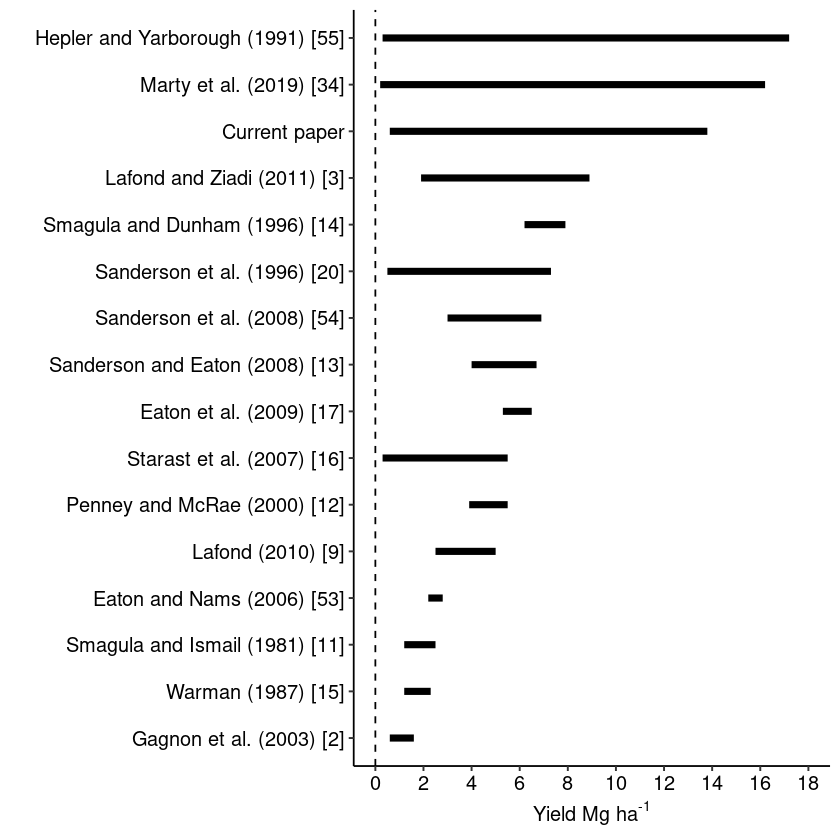

In [2]:
litterature_yields <- read_csv("data/literature-yield.csv")

litterature_yields %>%
  mutate(Author = fct_reorder(Author, Max)) %>%
  ggplot(aes(x = Min, y = Author)) +
  geom_segment(aes(xend = Max, yend = Author), lwd = 2) +
  scale_x_continuous(limits = c(0, 18), breaks = seq(from = 0, to = 18, by = 2)) +
  geom_vline(xintercept = 0, linetype = 2) +
  labs(x = expression("Yield Mg ha"^"-1"), y = "") +
  theme_pubr() +
  ggsave("images/litterature-yields.png", height = 4, width = 8, dpi = 300)

## Blueberry data

Data are stored in a single data set.

In [3]:
library("lubridate")
library("tidymodels")
df_source <- read_csv("data/data.csv", na = c("", "."))
phenology_table <- read_csv("data/phenology.csv") %>%
  mutate(phenology = fct_relevel(phenology, phenology)) # ordering factor levels


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.8      ✔ rsample   0.0.7 
✔ infer     0.5.3      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.1.3 
✔ parsnip   0.1.3      ✔ yardstick 0.0.7 

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks readr::spec()
✖ recipes::step()   masks stats::step()

Parsed with column specification:
cols(
  .default = col_double(),
  Project = col_character(),
  Site = col_character(),
  Coordinates = col_character()
)

See spec(...) for full column specifications.

Parsed with column specification:
cols(
  pheno

There are a lot of missing data in the Mo leaf content and the berry dry matter fraction. But oligo-elements are important information. We will proceed to missing data imputation further on. 

Dosage is put on element scale.

In [4]:
df_source <- df_source %>%
  mutate(
    id = 1:nrow(.),
    `P dose (kg/ha)` = `P2O5 dose (kg/ha)` / 2.29,
    `K dose (kg/ha)` = `K2O dose (kg/ha)` / 1.2
  )

## Weather

Weather indices are genereted from data fetched from Environment Canada with the **`weathercan`** package. The **`sp`** package is needed as dependency of **`weathercan`** to look for the closest stations.

In [5]:
library("weathercan")
library("sp")


Attaching package: ‘weathercan’


The following object is masked from ‘package:dials’:

    stations




Coordinates are stored by site in `sites.csv`.

In [6]:
sites <- read_csv("data/sites.csv")
df_source <-
  df_source %>%
  left_join(sites, by = "Site")

Parsed with column specification:
cols(
  Site = col_character(),
  Latitude = col_double(),
  Longitude = col_double()
)



### Select weather stations

We have the following Year/Site combinaisons.

In [7]:
year_site <- df_source %>%
  distinct(Year, Site, Latitude, Longitude)

We look for the closest stations with data starting 6 years before observations. To make this number dynamic, we set it as a variable `nyears_before`.

In [8]:
nyears_before <- 6
blueberry_stations <- list()
for (i in 1:nrow(year_site)) {
  blueberry_stations[[i]] <- stations_search(
    coords = c(year_site$Latitude[i], year_site$Longitude[i]),
    starts_latest = year_site$Year[i] - nyears_before - 2,
    ends_earliest = year_site$Year[i] + 3,
    dist = 50, interval = "day"
  )
}

We selected the closest stations.

In [9]:
year_site$station_id <- NA
year_site$station_name <- NA
for (i in seq_along(blueberry_stations)) {
  year_site$station_id[i] <- blueberry_stations[[i]]$station_id[1]
  year_site$station_name[i] <- blueberry_stations[[i]]$station_name[1]
}
year_site

Site,Year,Latitude,Longitude,station_id,station_name
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Normandin,2001,48.98333,-72.53333,5909,HEMON
St-Eugène,2001,48.98333,-72.28333,5909,HEMON
St-Léon,2001,48.66667,-71.53333,5939,ST LEON DE LABRECQUE
Normandin,2003,48.98333,-72.53333,10872,NORMANDIN
St-Eugène,2003,48.98333,-72.28333,10872,NORMANDIN
St-Léon,2003,48.66667,-71.53333,10797,MISTOOK
Albanel,2005,48.88333,-72.45000,10872,NORMANDIN
St-Eugène,2004,48.98333,-72.28333,10872,NORMANDIN
St-Eugène,2005,48.98333,-72.28333,10872,NORMANDIN


Station `ST LEON DE LABRECQUE` seems to generate errors. The next closest one available in 2001 is `ST AMBROISE`.

In [10]:
blueberry_stations[[3]]$station_name

[1] "ST LEON DE LABRECQUE" "ST AMBROISE"          "FALARDEAU"           
[4] "LAC STE CROIX"        "PERIBONCA"            "JONQUIERE"

In [11]:
year_site$station_id[3] <- blueberry_stations[[3]]$station_id[2]
year_site$station_name[3] <- blueberry_stations[[3]]$station_name[2]

We will fetch weather by year and station ID.

In [12]:
year_station <- year_site %>% distinct(Year, station_id)

### Fetch weather

We suppose that seasons start on April 1st and end at mid-August. The first loop stores the weather of the year of the experiment. This will be used to asses feature importance.

#### Weather current

These data are the one that occured during the year of the experiment.

We unnest the list of lists, the old fashion way.

In [13]:
load("output/weather_current.RData")

#### Weather before

Now for each station, we fetch weather data 6 years before the experiment. These data will be used for prediction. Cells that fetch weather are deactivated since data have already been fetched and saved in a RData file.

We unnest the list of lists.

In [14]:
load("output/weather_before.RData")

#### Weather 2016 (for discussion)

There is a discussion in the paper about year 2016.

In [15]:
load("output/weather_2016.RData")

### Compute weather indices

#### Weather current

For each phenological stage, we compute total **precipitation** and **mean temperature**. 

In [16]:
weather_current_pheno <- weather_current %>%
  mutate(julian_day = yday(date),
         phenology = case_when(
             julian_day <= phenology_table$`julian day end`[1] ~ phenology_table$phenology[1],
             julian_day <= phenology_table$`julian day end`[2] ~ phenology_table$phenology[2],
             julian_day <= phenology_table$`julian day end`[3] ~ phenology_table$phenology[3],
             julian_day <= phenology_table$`julian day end`[4] ~ phenology_table$phenology[4],
             julian_day <= phenology_table$`julian day end`[5] ~ phenology_table$phenology[5]
         ),
         phenology = fct_relevel(phenology, levels(phenology_table$phenology)))

In [17]:
temp_prec_current <- weather_current_pheno %>%
  group_by(station_id, year, phenology) %>%
  summarise(
    total_precip = sum(total_precip, na.rm = TRUE),
    mean_temp = mean(mean_temp, na.rm = TRUE),
    .groups = "drop"
  ) %>%
  pivot_wider(names_from = phenology, values_from = c(total_precip, mean_temp))

We compute the number of days per month were air temerature falls under a freezing temperature.

In [18]:
frozen_delimiter <- -5
frozen_current <- weather_current_pheno %>%
  group_by(station_id, year, phenology) %>%
  summarise(frozen = sum(mean_temp < frozen_delimiter, na.rm = TRUE), .groups = "drop") %>% 
  pivot_wider(names_from = phenology, values_from = frozen)
names(frozen_current)[-c(1, 2)] <- paste0("frozen_", names(frozen_current)[-c(1, 2)])

While the number of freezing days can affect flowering, the number of days with mean temperature > 26 °C can affect pollination.

In [19]:
toowarm_delimiter <- 26
toowarm_current <- weather_current_pheno %>%
  group_by(station_id, year, phenology) %>%
  summarise(toowarm = sum(mean_temp >= toowarm_delimiter, na.rm = TRUE), .groups = "drop") %>% 
  pivot_wider(names_from = phenology, values_from = toowarm)
names(toowarm_current)[-c(1, 2)] <- paste0("toowarm_", names(toowarm_current)[-c(1, 2)])

Lastly, the degree days are computed.

In [20]:
GDD_delimiter <- 4.4
GDD_current <- weather_current_pheno %>%
  mutate(GDD_daily = case_when(mean_temp >= GDD_delimiter ~ mean_temp - GDD_delimiter, TRUE ~ 0)) %>%
  group_by(station_id, year, phenology) %>%
  summarise(GDD = sum(GDD_daily, na.rm = TRUE), .groups = "drop") %>% 
  pivot_wider(names_from = phenology, values_from = GDD)
names(GDD_current)[-c(1, 2)] <- paste0("GDD_", names(GDD_current)[-c(1, 2)])

All indices in the same table. Too warm is eliminated from now on.

In [21]:
weather_indices_current <- temp_prec_current %>%
  left_join(frozen_current, by = c("station_id", "year")) %>% 
  #left_join(toowarm_current, by = c("station_id", "year")) %>% 
  left_join(GDD_current, by = c("station_id", "year")) %>%
  ungroup() %>% 
  mutate(year = as.numeric(year)) %>% 
  rename(Year = year)
names(weather_indices_current)[-c(1, 2)] <- paste0("weather_current.", 
                                                   names(weather_indices_current)[-c(1, 2)])

#### Weather summary

The table must be organized...

In [22]:
weather_indices_current_tidy <- weather_indices_current %>%
  pivot_longer(cols = -c(station_id, Year)) %>%
  mutate(category = case_when(
    str_detect(name, "precip") ~ "Total\nprecipitations (mm)",
    str_detect(name, "temp") ~ "Mean\ntemperature (°C)",
    str_detect(name, "frozen") ~ "Number of\nfreezing days",
    str_detect(name, "GDD") ~ "Growing\ndegree-days (°C)"
  ),
         phenology = case_when(
    str_detect(name, "Before") ~ "Before flower bud opening",
    str_detect(name, "Flower bud opening") ~ "Flower bud opening",
    str_detect(name, "Flower open") ~ "Flower open",
    str_detect(name, "Fruit maturation") ~ "Fruit maturation",
    str_detect(name, "After fruit") ~ "After fruit maturation",
  )) %>%
  left_join(phenology_table, by = "phenology") %>%
  mutate(phenology = fct_relevel(phenology, levels(phenology_table$phenology)))

... to be plotted.

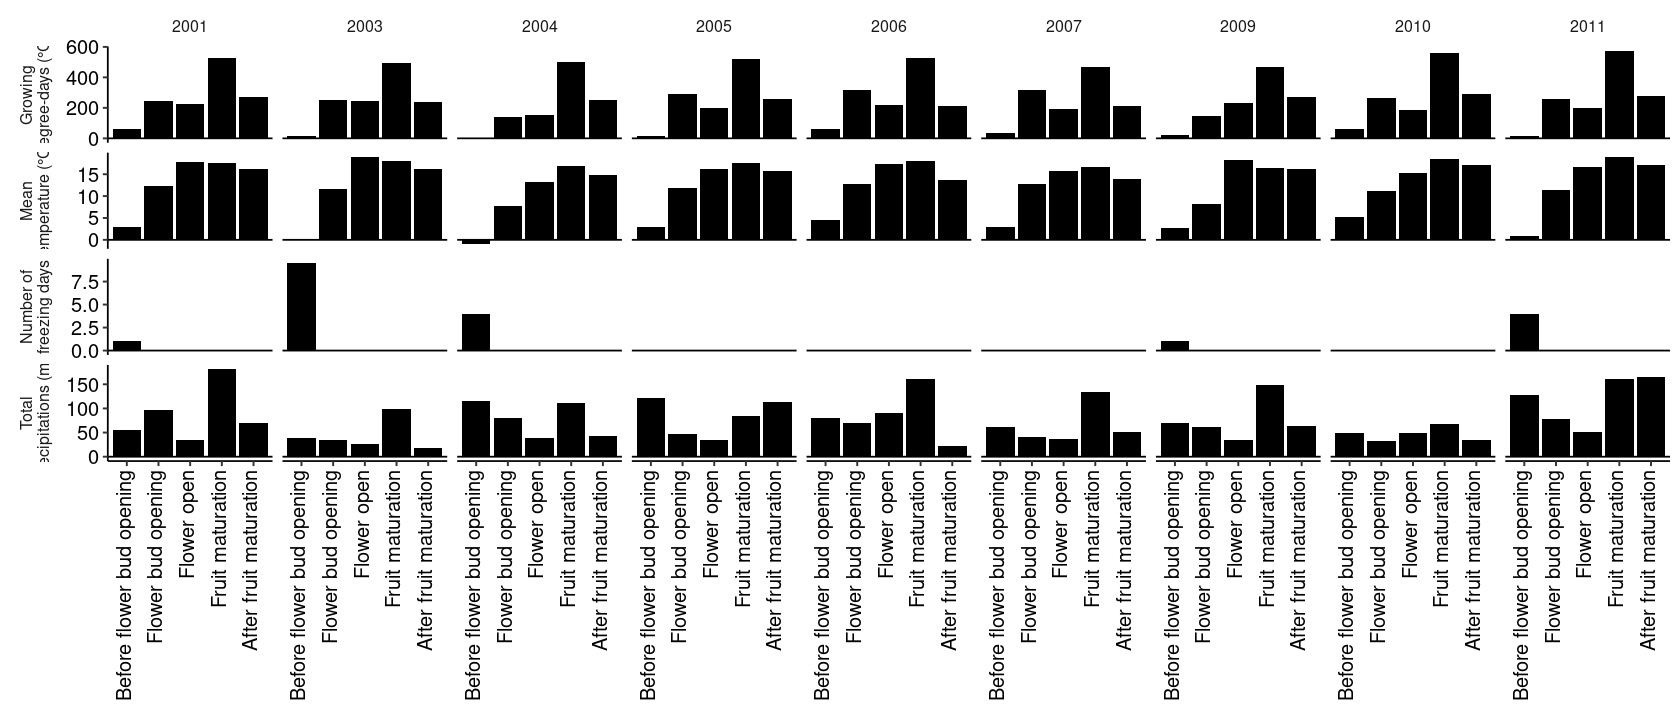

In [23]:
options(repr.plot.height = 6, repr.plot.width = 14)
weather_indices_current_tidy %>%
  group_by(category, year = Year, phenology) %>%
  summarize(value = mean(value), .groups = "drop") %>%
  drop_na() %>%
  ggplot(aes(x = phenology, y = value)) +
  facet_grid(category ~ year, scales = "free", switch="y") +
  expand_limits(y = 0) +
  geom_col(fill = "black") +
  geom_hline(yintercept = 0) +
  theme_pubr() +
  theme(panel.grid.minor.y = element_blank(),
        panel.grid.minor.x = element_blank(),
        panel.grid.major.x = element_blank(),
        strip.placement = "outside",
        axis.title.x = element_blank(),
        axis.title.y = element_blank(),
        axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.25),
        strip.background = element_rect(fill = "transparent", colour = "transparent")) +
  ggsave("images/weather-statistics.png", height = 8, width = 14, dpi = 120)

Growing degree days and mean temperatures carry the same information. Only one of them is necessary.

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



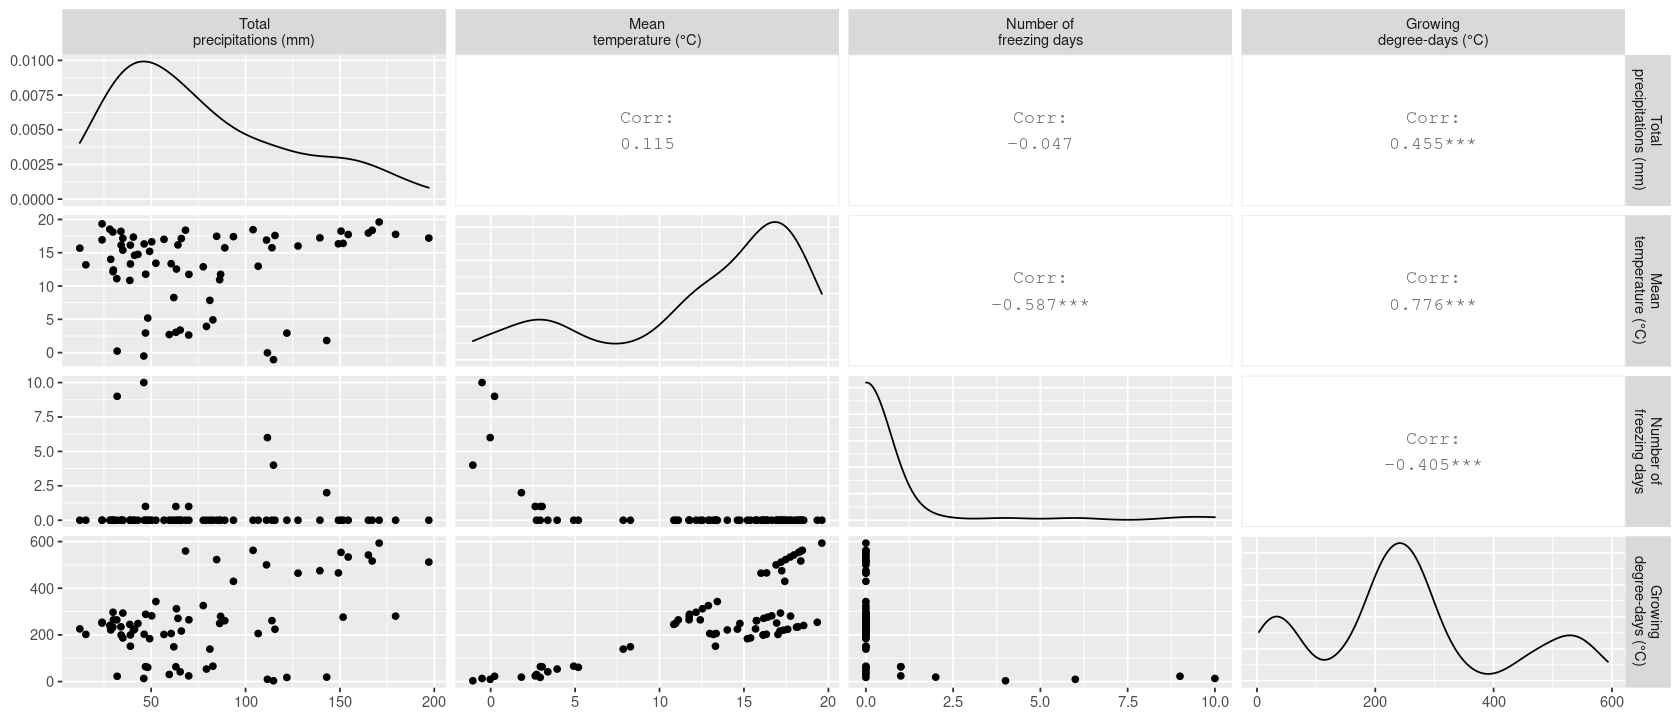

In [24]:
library("GGally")
weather_indices_current_tidy %>%
  select(-name) %>%
  pivot_wider(names_from = category, values_from = value) %>%
  select(contains(c("Total", "Mean", "Number", "Growing"))) %>%
  ggpairs()

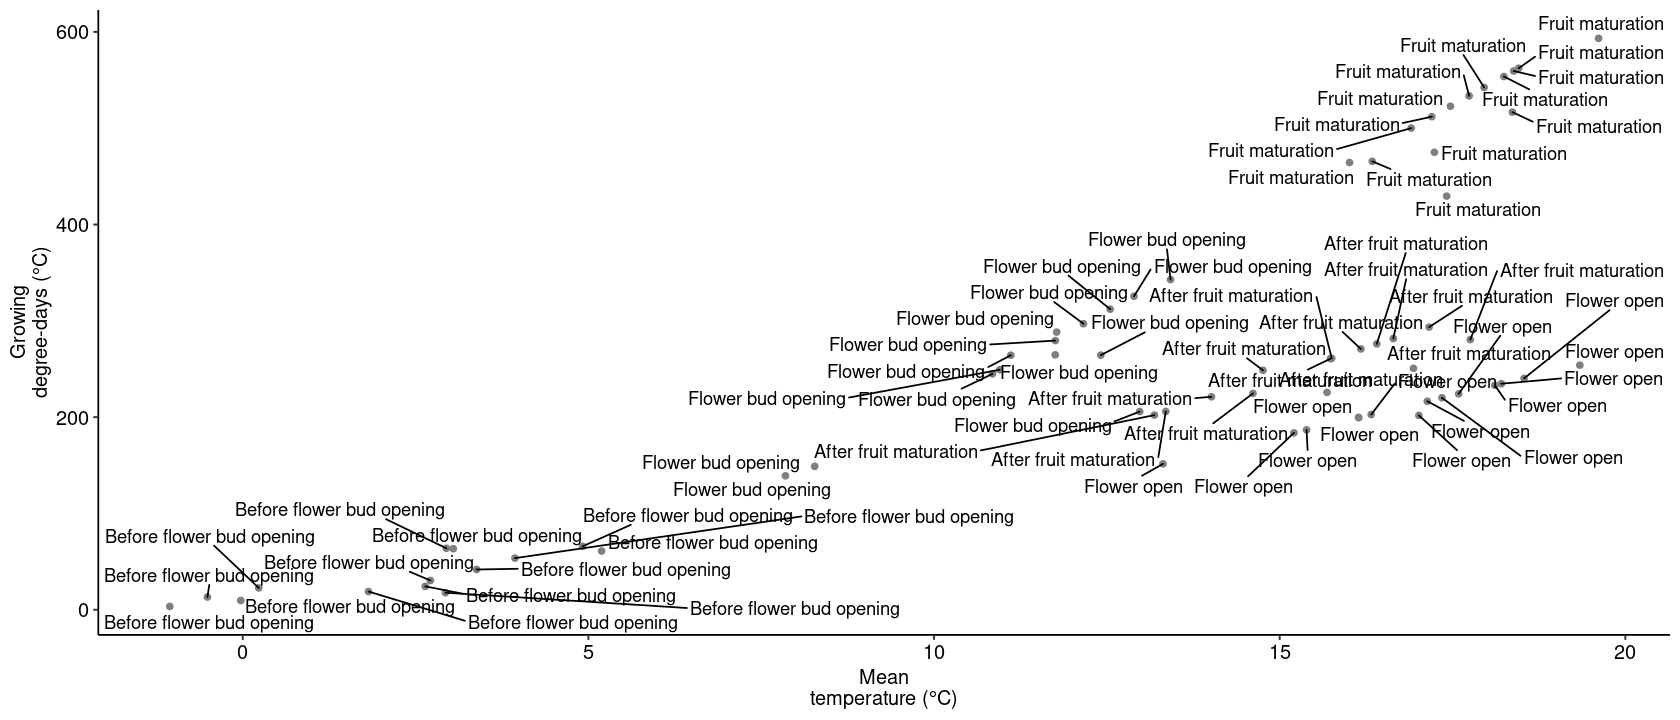

In [25]:
library("ggrepel")
weather_indices_current_tidy %>%
  filter(str_detect(name, 'mean_temp|GDD')) %>%
  select(-name) %>%
  pivot_wider(names_from = category, values_from = value) %>%
  ggplot(aes(x = `Mean\ntemperature (°C)`, y = `Growing\ndegree-days (°C)`)) +
  geom_point(colour = "grey50") +
  geom_text_repel(aes(label = phenology)) +
  theme_pubr() +
  ggsave("images/gdd-mt.png", height = 10, width = 10, dpi = 300)

We will keep on with mean temperatures, which are simpler.

#### Weather, 6 years before

For each phenological stage, we compute total precipitation and mean temperature 6 years (`nyears_before`) before the growing season. 

In [26]:
weather_before_pheno <- weather_before %>%
  mutate(julian_day = yday(date),
         phenology = case_when(
             julian_day <= phenology_table$`julian day end`[1] ~ phenology_table$phenology[1],
             julian_day <= phenology_table$`julian day end`[2] ~ phenology_table$phenology[2],
             julian_day <= phenology_table$`julian day end`[3] ~ phenology_table$phenology[3],
             julian_day <= phenology_table$`julian day end`[4] ~ phenology_table$phenology[4],
             julian_day <= phenology_table$`julian day end`[5] ~ phenology_table$phenology[5]
         ))

In [27]:
temp_prec_before <- list()

# Each element of the list corresponds to a row in year_station
for (i in 1:nrow(year_station)) {
  temp_prec_before[[i]] <-
    weather_before_pheno %>%
    # filter to keep the station ID and the 6 years preceeding the 
    # year of the experiment
    filter(
      station_id == year_station$station_id[i],
      year %in% (year_station$Year[i] - nyears_before):(year_station$Year[i] - 1)
    ) %>%
    # Group by year and phenology...
    group_by(year, phenology) %>%
    # to compute indices for each month of the 6 preceeeding years
    summarise(
      total_precip = sum(total_precip, na.rm = TRUE),
      mean_temp = mean(mean_temp, na.rm = TRUE),
      .groups = "drop"
    ) %>%
    # then regroup by phenology, excluding the year
    group_by(phenology) %>%
    # to summarise mean indices per month
    summarise(
      total_precip = mean(total_precip, na.rm = TRUE),
      mean_temp = mean(mean_temp, na.rm = TRUE),
      .groups = "drop"
    ) %>%
    # and pivot to a single row corresponding to the year_station table
    pivot_wider(names_from = phenology, values_from = c(total_precip, mean_temp))
}

# merge all rows together
temp_prec_before <- do.call(rbind, temp_prec_before)

We compute the number of days per phenological stage where air temerature falls under 0 degrees, a condition altering flowers.

In [28]:
frozen_before <- list()
for (i in 1:nrow(year_station)) {
  frozen_before[[i]] <- weather_before_pheno %>%
    filter(
      station_id == year_station$station_id[i],
      year %in% (year_station$Year[i] - nyears_before):(year_station$Year[i] - 1),
    ) %>%
    group_by(year, phenology) %>%
    summarise(frozen = sum(mean_temp <= frozen_delimiter, na.rm = TRUE),
             .groups = "drop") %>%
    group_by(phenology) %>%
    summarise(frozen = mean(frozen),
             .groups = "drop") %>%
    pivot_wider(names_from = phenology, values_from = frozen)
}
frozen_before <- do.call(rbind, frozen_before)
names(frozen_before) <- paste0("frozen_", names(frozen_before))

The number of days with mean temperature > 26 °C:

In [29]:
toowarm_before <- list()
for (i in 1:nrow(year_station)) {
  toowarm_before[[i]] <- weather_before_pheno %>%
    filter(
      station_id == year_station$station_id[i],
      year %in% (year_station$Year[i] - nyears_before):(year_station$Year[i] - 1),
    ) %>%
    group_by(year, phenology) %>%
    summarise(toowarm = sum(mean_temp <= toowarm_delimiter, na.rm = TRUE),
             .groups = "drop") %>%
    group_by(phenology) %>%
    summarise(toowarm = mean(toowarm),
             .groups = "drop") %>%
    pivot_wider(names_from = phenology, values_from = toowarm)
}
toowarm_before <- do.call(rbind, toowarm_before)
names(toowarm_before) <- paste0("toowarm_", names(toowarm_before))

And GDD.

In [30]:
GDD_before <- list()
for (i in 1:nrow(year_station)) {
  GDD_before[[i]] <-
    weather_before_pheno %>%
    mutate(GDD_daily = case_when(mean_temp >= GDD_delimiter ~ mean_temp - GDD_delimiter, TRUE ~ 0)) %>%
    filter(
      station_id == year_station$station_id[i],
      year %in% (year_station$Year[i] - nyears_before):(year_station$Year[i] - 1),
    ) %>%
    group_by(year, phenology) %>%
    summarise(GDD = sum(GDD_daily, na.rm = TRUE), .groups = "drop") %>% 
    group_by(phenology) %>%
    summarise(GDD = mean(GDD),
             .groups = "drop") %>% 
    pivot_wider(names_from = phenology, values_from = GDD)
}
GDD_before <- do.call(rbind, GDD_before)
names(GDD_before) <- paste0("GDD_", names(GDD_before))

All indices in the same table.

In [31]:
weather_indices_before <- year_station %>% 
  bind_cols(temp_prec_before) %>%
  bind_cols(frozen_before) %>% 
  #bind_cols(toowarm_before) %>% 
  bind_cols(GDD_before)
names(weather_indices_before)[-c(1, 2)] <- paste0("weather_before.", 
                                                  names(weather_indices_before)[-c(1, 2)])

#### Weather, all years
For the current year and the preceeding year, compute seasonnal weather indices.

In [32]:
weather_all <- bind_rows(weather_current, weather_before) %>%
  distinct()

Compute the indices for each row of the `year_station` table.

In [33]:
temp_prec_GDD_currseason <- weather_all %>%
  filter(paste(year, station_id) %in%
         paste(year_station$Year, year_station$station_id)) %>%
  group_by(station_id, year) %>%
  summarise(
    weather_2years.total_precip_curr = sum(total_precip, na.rm = TRUE),
    weather_2years.mean_temp_curr = mean(mean_temp, na.rm = TRUE),
    weather_2years.GDD_curr = sum(mean_temp >= GDD_delimiter, na.rm = TRUE),
    .groups = "drop"
  ) %>%
  ungroup()

And the number of freezing days.

In [34]:
frozen_currseason <- rep(0, nrow(year_station))
for (i in 1:nrow(year_station)) {
  frozen_currseason[i] <- weather_all %>%
    filter(
      station_id == year_station$station_id[i],
      year == year_station$Year[i]
    ) %>%
    group_by(year) %>%
    summarise(frozen = sum(mean_temp <= 0, na.rm = TRUE),
             .groups = "drop") %>%
    pull()
}

We compute the seasonnal indicies the same way, but for the previous year.

In [35]:
temp_prec_GDD_prevseason <- weather_all %>%
  filter(paste(year, station_id) %in%
         paste(year_station$Year-1, year_station$station_id)) %>% # minus one here
  mutate(GDD_daily = case_when(mean_temp >= GDD_delimiter ~ mean_temp - GDD_delimiter, TRUE ~ 0)) %>%
  group_by(station_id, year) %>%
  summarise(
    weather_2years.total_precip_prev = sum(total_precip, na.rm = TRUE),
    weather_2years.mean_temp_prev = mean(mean_temp, na.rm = TRUE),
    weather_2years.GDD_prev = sum(GDD_daily, na.rm = TRUE),
    .groups = "drop"
  ) %>%
  ungroup()

The number of freezing days.

In [36]:
frozen_prevseason <- rep(0, nrow(year_station))
for (i in 1:nrow(year_station)) {
  frozen_prevseason[i] <- weather_all %>%
    filter(
      station_id == year_station$station_id[i],
      year == year_station$Year[i] - 1
    ) %>%
    group_by(year) %>%
    summarise(frozen = sum(mean_temp <= 0, na.rm = TRUE),
             .groups = "drop") %>%
    pull()
}

We merge them together, in a similar manner than the previous `weather_indices_*` tables.

In [37]:
weather_indices_2years <- bind_cols(
  year_station,
  temp_prec_GDD_currseason %>%
    select(weather_2years.total_precip_curr, weather_2years.mean_temp_curr, weather_2years.GDD_curr),
  temp_prec_GDD_prevseason %>%
    select(weather_2years.total_precip_prev, weather_2years.mean_temp_prev, weather_2years.GDD_prev)
) %>%
  mutate(weather_2years.frozen_curr = frozen_currseason,
         weather_2years.frozen_prev = frozen_prevseason)

### Merge everything

In [38]:
year_station_ <- year_station %>% 
  left_join(weather_indices_current, by = c("Year", "station_id")) %>% 
  left_join(weather_indices_before, by = c("Year", "station_id")) %>%
  left_join(weather_indices_2years, by = c("Year", "station_id"))

year_site_ <- year_site %>% 
  left_join(year_station_, by = c("Year", "station_id")) %>% 
  select(-Latitude, -Longitude)

df_weather <- df_source %>%
  left_join(year_site_, by = c("Year", "Site"))

## Compositional preprocess

### Look up missing values

In leaves,

Loading required package: colorspace

Loading required package: grid

VIM is ready to use.


Suggestions and bug-reports can be submitted at: https://github.com/statistikat/VIM/issues


Attaching package: ‘VIM’


The following object is masked from ‘package:recipes’:

    prepare


The following object is masked from ‘package:datasets’:

    sleep





 Variables sorted by number of missings: 
      Variable        Count
 Leaf Mo (ppm) 0.5166223404
 Leaf Mn (ppm) 0.3557180851
 Leaf Zn (ppm) 0.3530585106
 Leaf Fe (ppm) 0.3523936170
 Leaf Cu (ppm) 0.3470744681
 Leaf Al (ppm) 0.1808510638
  Leaf B (ppm) 0.1801861702
    Leaf N (%) 0.0033244681
    Leaf P (%) 0.0033244681
    Leaf K (%) 0.0013297872
   Leaf Ca (%) 0.0006648936
   Leaf Mg (%) 0.0006648936


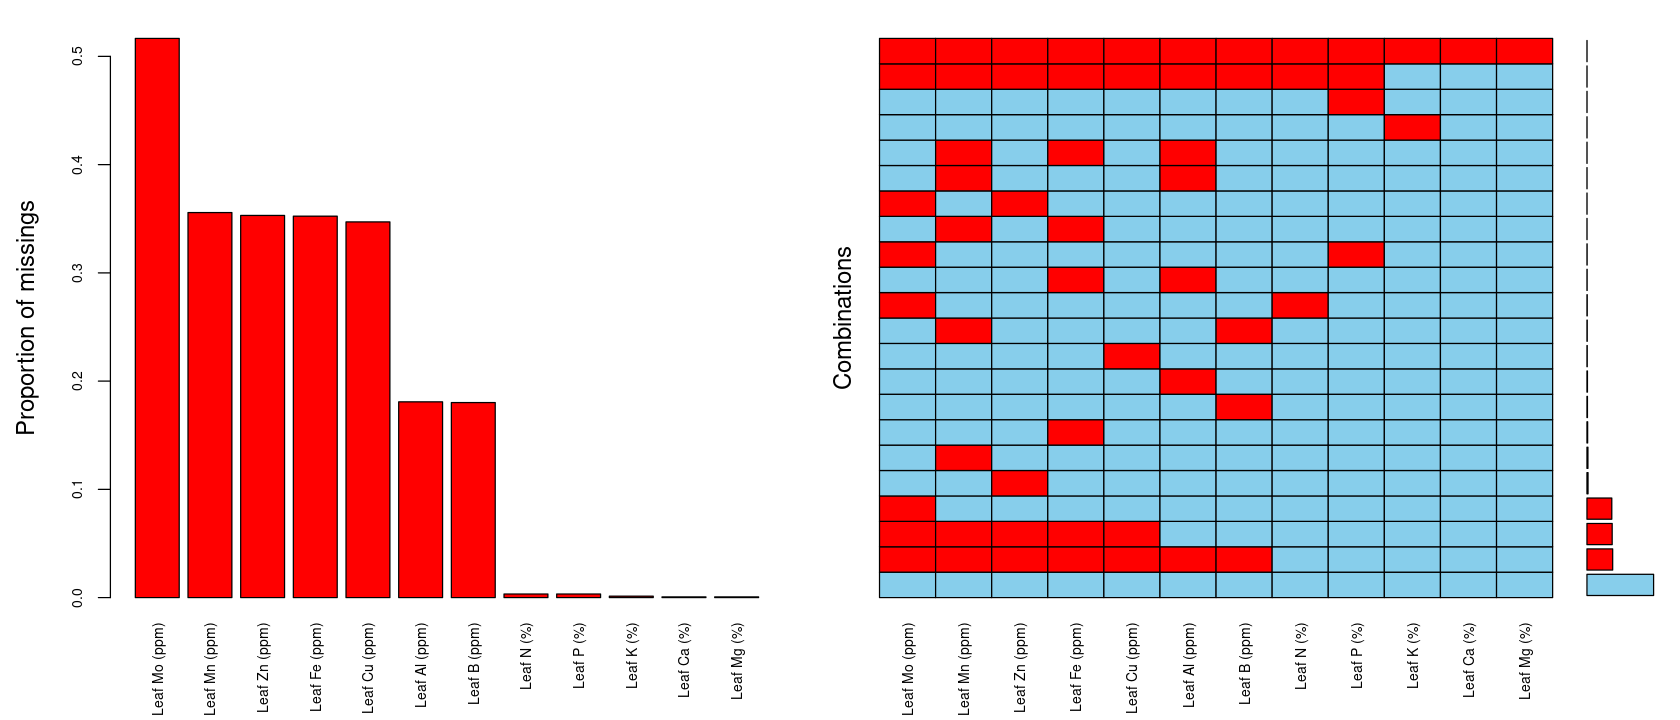

In [39]:
library("VIM")
comp_leaf <- df_source %>%
  select(starts_with("Leaf"))

aggr(comp_leaf, sortVar = TRUE, cex.axis = 0.7)

The proportion of NAs in the Mo (\~55%), Mn, Zn and Fe (\~35%) columns are too high to parse them through imputations. Although Al and B also have pretty high propostions of NAs (~18%), they are important components. They will be kept and imputed.

In soil,


 Variables sorted by number of missings: 
        Variable        Count
  Soil NO3 (ppm) 0.5146276596
  Soil NH4 (ppm) 0.5146276596
  Soil K (mg/kg) 0.0053191489
  Soil P (mg/kg) 0.0006648936
 Soil Ca (mg/kg) 0.0006648936
 Soil Mg (mg/kg) 0.0000000000


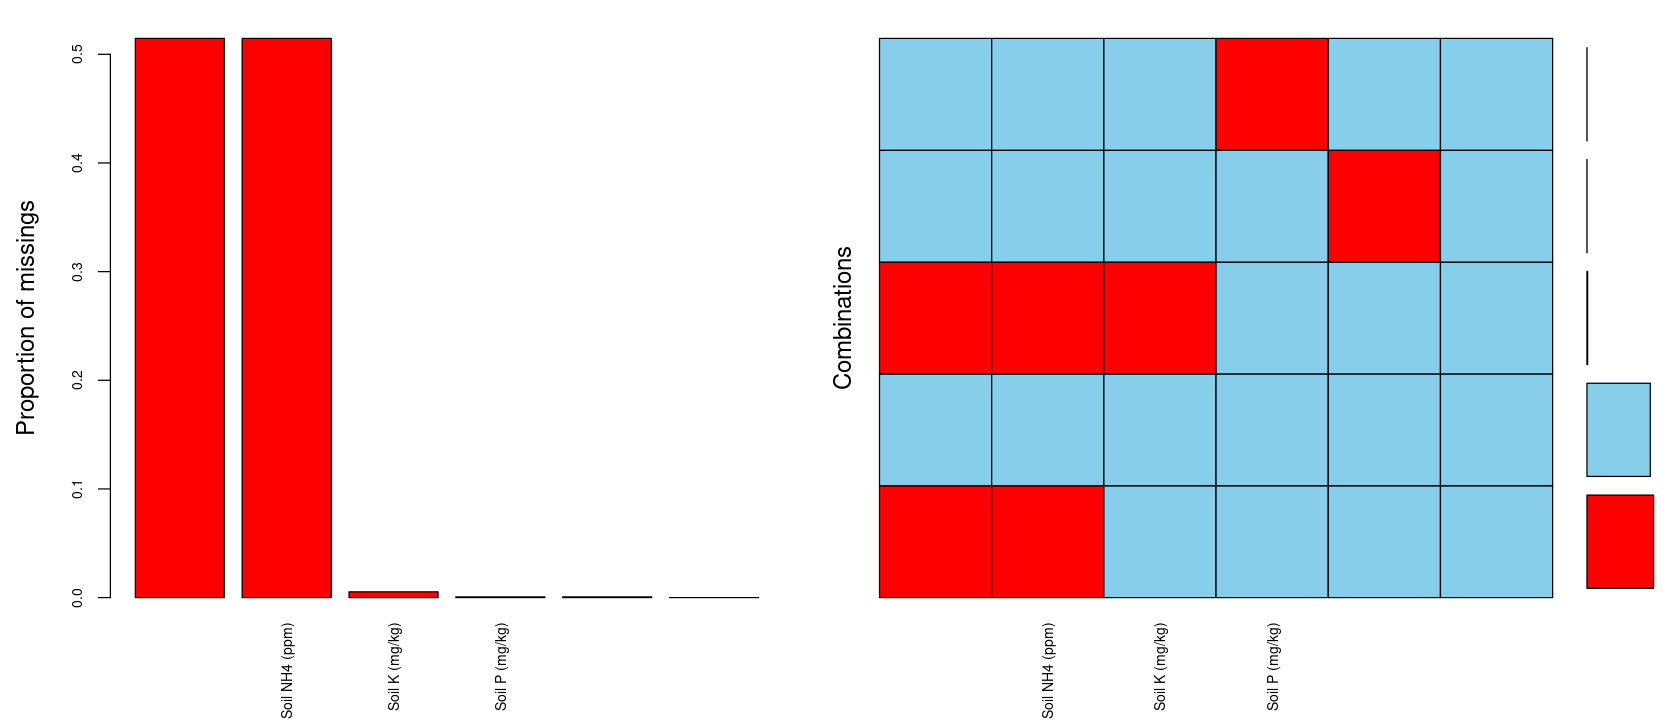

In [40]:
comp_soil <- df_source %>%
  select(starts_with("Soil"))

aggr(comp_soil, sortVar = TRUE, cex.axis = 0.7)

Nitrogen forms have been measured in less than 50%  of the obervations. Unfortunalty, we must rule them out of the analysis. K, P, Ca and Mg are kept.

### Imputations

The imputation is done with a random forest algorithm using the **`mice`** package. Leaves first.

In [41]:
library("mice")

comp_leaf_enough <- comp_leaf %>% 
  select(-`Leaf Mo (ppm)`, -`Leaf Mn (ppm)`, -`Leaf Zn (ppm)`, -`Leaf Cu (ppm)`, -`Leaf Fe (ppm)`)

leaf_comp_names <- names(comp_leaf_enough)
names(comp_leaf_enough) <- c("N", "P", "K", "Ca", "Mg", "Al", "B")

leaf_too_many_nas <- df_source %>% 
  select(id) %>% 
  filter(apply(comp_leaf_enough, 1, function(x) sum(is.na(x)) > 3)) %>% 
  pull()

leaf_imp <- comp_leaf_enough %>% 
  filter(!(df_source$id %in% leaf_too_many_nas)) %>%
  mice(., method = "rf") %>% 
  complete(.)

names(leaf_imp) <- leaf_comp_names


Attaching package: ‘mice’


The following objects are masked from ‘package:base’:

    cbind, rbind





 iter imp variable
  1   1  N  P  K  Al  B
  1   2  N  P  K  Al  B
  1   3  N  P  K  Al  B
  1   4  N  P  K  Al  B
  1   5  N  P  K  Al  B
  2   1  N  P  K  Al  B
  2   2  N  P  K  Al  B
  2   3  N  P  K  Al  B
  2   4  N  P  K  Al  B
  2   5  N  P  K  Al  B
  3   1  N  P  K  Al  B
  3   2  N  P  K  Al  B
  3   3  N  P  K  Al  B
  3   4  N  P  K  Al  B
  3   5  N  P  K  Al  B
  4   1  N  P  K  Al  B
  4   2  N  P  K  Al  B
  4   3  N  P  K  Al  B
  4   4  N  P  K  Al  B
  4   5  N  P  K  Al  B
  5   1  N  P  K  Al  B
  5   2  N  P  K  Al  B
  5   3  N  P  K  Al  B
  5   4  N  P  K  Al  B
  5   5  N  P  K  Al  B


Then soil.

In [42]:
comp_soil_enough <- comp_soil %>% 
  select(-`Soil NO3 (ppm)`, -`Soil NH4 (ppm)`)

soil_comp_names <- names(comp_soil_enough)
names(comp_soil_enough) <- c("P", "K", "Ca", "Mg")

soil_too_many_nas <- df_source %>% 
  select(id) %>% 
  filter(apply(comp_soil_enough, 1, function(x) sum(is.na(x)) > 3)) %>% 
  pull()

soil_imp <- comp_soil_enough %>% 
  filter(!(df_source$id %in% soil_too_many_nas)) %>%
  mice(., method = "rf") %>% 
  complete(.)

names(soil_imp) <- soil_comp_names


 iter imp variable
  1   1  P  K  Ca
  1   2  P  K  Ca
  1   3  P  K  Ca
  1   4  P  K  Ca
  1   5  P  K  Ca
  2   1  P  K  Ca
  2   2  P  K  Ca
  2   3  P  K  Ca
  2   4  P  K  Ca
  2   5  P  K  Ca
  3   1  P  K  Ca
  3   2  P  K  Ca
  3   3  P  K  Ca
  3   4  P  K  Ca
  3   5  P  K  Ca
  4   1  P  K  Ca
  4   2  P  K  Ca
  4   3  P  K  Ca
  4   4  P  K  Ca
  4   5  P  K  Ca
  5   1  P  K  Ca
  5   2  P  K  Ca
  5   3  P  K  Ca
  5   4  P  K  Ca
  5   5  P  K  Ca


### Compute balances

Load SBPs.

In [43]:
library("compositions")
sbp_soil <- read_csv("data/sbp-soil.csv")
sbp_leaf <- read_csv("data/sbp-leaf.csv")

Welcome to compositions, a package for compositional data analysis.
Find an intro with "? compositions"



Attaching package: ‘compositions’


The following objects are masked from ‘package:stats’:

    cor, cov, dist, var


The following objects are masked from ‘package:base’:

    %*%, norm, scale, scale.default


Parsed with column specification:
cols(
  P = col_double(),
  K = col_double(),
  Ca = col_double(),
  Mg = col_double(),
  Fv = col_double()
)

Parsed with column specification:
cols(
  N = col_double(),
  P = col_double(),
  K = col_double(),
  Ca = col_double(),
  Mg = col_double(),
  Al = col_double(),
  B = col_double(),
  Fv = col_double()
)



I have created a small snippet to generate balance definitions from SBPs.

In [44]:
source("lib/ilrDefinition.R")
soil_bal_def <- ilrDefinition(sbp_soil,
                              side = "-+", sep.elem = "",
                              sep.bal = ".", sep.left = "", sep.right = ""
)
leaf_bal_def <- ilrDefinition(sbp_leaf,
                              side = "-+", sep.elem = "",
                              sep.bal = ".", sep.left = "", sep.right = ""
)

Generate leaf balances.

In [45]:
comp_leaf <- leaf_imp %>% 
  mutate(`Leaf Al (%)` = `Leaf Al (ppm)` / 1e4,
         `Leaf B (%)` = `Leaf B (ppm)` / 1e4,) %>% 
  select(-`Leaf Al (ppm)`, -`Leaf B (ppm)`) %>% 
  mutate(Fv = 100 - `Leaf N (%)` - `Leaf P (%)` - `Leaf K (%)` -
           `Leaf Ca (%)` - `Leaf Mg (%)` - `Leaf Al (%)` - `Leaf B (%)`)
bal_leaf <- ilr(comp_leaf, V = gsi.buildilrBase(t(sbp_leaf))) %>% 
  data.frame()
names(bal_leaf) <- paste0("Leaf_", leaf_bal_def)

bal_leaf <- bal_leaf %>% 
  mutate(id = df_source$id[!(df_source$id %in% leaf_too_many_nas)])

Generate soil balances.

In [46]:
comp_soil <- soil_imp %>% 
  mutate(Fv = 1e6 - `Soil Ca (mg/kg)` - `Soil P (mg/kg)` - `Soil K (mg/kg)` - `Soil Mg (mg/kg)`)
bal_soil <- ilr(comp_soil, V = gsi.buildilrBase(t(sbp_soil))) %>% 
  data.frame()
names(bal_soil) <- paste0("Soil_", soil_bal_def)

bal_soil <- bal_soil %>% 
  mutate(id = df_source$id)

### Merge variables to a table for modelling

Tables for weather, soil balances et leaf balances are merged to a single table which will be used for statistical and predictive modelling.

In [47]:
df_ <- df_weather %>%
  select(-starts_with(c("Leaf", "Soil"))) %>%
  left_join(bal_leaf, by = "id") %>% 
  left_join(bal_soil, by = "id")

## Statistical modelling

I will first use a frequential modelling framework to make sure everything works, then use a bayesian framework to obtain posterior effects. I'm keeping only variables of interest.

### Weather 2 years

Since blueberry cycles last two years, we investigate on a two-years basis, but weather is agglomerated to the whole season, not monthly.

In [48]:
df_stats <- df_ %>%
  select(
    `Berry yield (kg/ha)`,
    `N dose (kg/ha)`,
    `P dose (kg/ha)`,
    `K dose (kg/ha)`,
    `pH H2O`,
    starts_with("Leaf_"),
    starts_with("Soil_"),
    starts_with("weather_2years"),
    # Random effects
    Year, Site, Block
  ) %>%
  rename(
    yield = `Berry yield (kg/ha)`,
    doseN = `N dose (kg/ha)`,
    doseP = `P dose (kg/ha)`,
    doseK = `K dose (kg/ha)`,
    pH = `pH H2O`
  ) %>%
  drop_na()

In [49]:
linmod_formula <- yield ~ doseN + doseP + doseK + pH +
  Leaf_Fv.BAlMgCaKPN + Leaf_Al.BMgCaKPN + Leaf_B.MgCaKPN + 
  Leaf_MgCaK.PN + Leaf_P.N + Leaf_MgCa.K + Leaf_Mg.Ca +
  Soil_Fv.MgCaKP + Soil_MgCaK.P + Soil_MgCa.K + Soil_Mg.Ca +
  weather_2years.total_precip_curr + weather_2years.mean_temp_curr + weather_2years.frozen_curr + 
  # + weather_2years.GDD_curr
  weather_2years.total_precip_prev + weather_2years.mean_temp_prev  + weather_2years.frozen_prev
  # + weather_2years.GDD_prev

df_stats_recipe <-
  df_stats %>%
  recipe(linmod_formula) %>%
  step_log(all_outcomes(), base = 10) %>% 
  step_normalize(-all_outcomes(), all_numeric()) %>%
  prep()

#### Frequential framework

In [50]:
lm_freq <- lm(linmod_formula, data = juice(df_stats_recipe))

Parsed with column specification:
cols(
  term = col_character(),
  english = col_character()
)



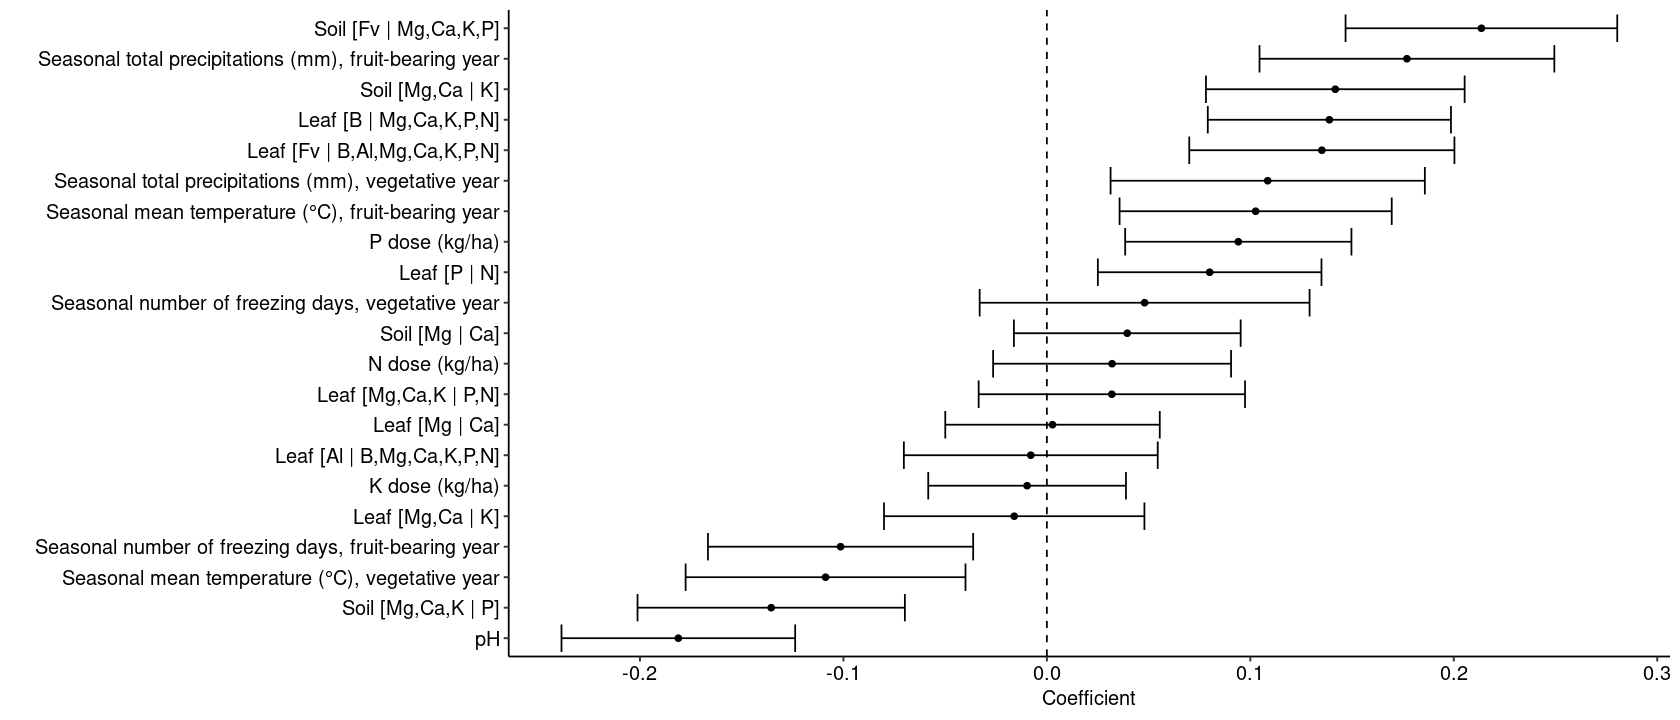

In [51]:
translate_df <- read_csv("data/translate_names.csv")

tidy(lm_freq, conf.int = TRUE) %>%
  filter(term != "(Intercept)") %>%
  left_join(translate_df, by = "term") %>%
  mutate(english = fct_reorder(english, estimate)) %>%
  ggplot(aes(estimate, english)) +
  geom_vline(xintercept = 0, linetype = 2) +
  geom_point() +
  geom_errorbarh(aes(xmin = conf.low, xmax = conf.high)) +
  labs(x = "Coefficient", y = "") +
  theme_pubr() +
  ggsave("images/modlin-freq_seasonal.png", width = 8, height = 8, dpi = 300)

#### Bayesian framework

In [52]:
library("rstanarm")
library("tidybayes")
library("bayesplot")

lm_bayes <- stan_glm(
  linmod_formula,
  data = juice(df_stats_recipe),
  family = gaussian(),
  prior = normal(0, 10),
  prior_intercept = normal(0, 10),
  iter = 4000,
  warmup = 1000,
  cores = 4,
  seed = 9265830
)

Loading required package: Rcpp


Attaching package: ‘Rcpp’


The following object is masked from ‘package:rsample’:

    populate


Registered S3 methods overwritten by 'lme4':
  method                          from
  cooks.distance.influence.merMod car 
  influence.merMod                car 
  dfbeta.influence.merMod         car 
  dfbetas.influence.merMod        car 

This is rstanarm version 2.21.1

- See https://mc-stan.org/rstanarm/articles/priors for changes to default priors!

- Default priors may change, so it's safest to specify priors, even if equivalent to the defaults.

- For execution on a local, multicore CPU with excess RAM we recommend calling

  options(mc.cores = parallel::detectCores())


Attaching package: ‘rstanarm’


The following object is masked from ‘package:compositions’:

    R2



Attaching package: ‘tidybayes’


The following object is masked from ‘package:tune’:

    parameters


The following object is masked from ‘package:dials’:

    parameters


This i

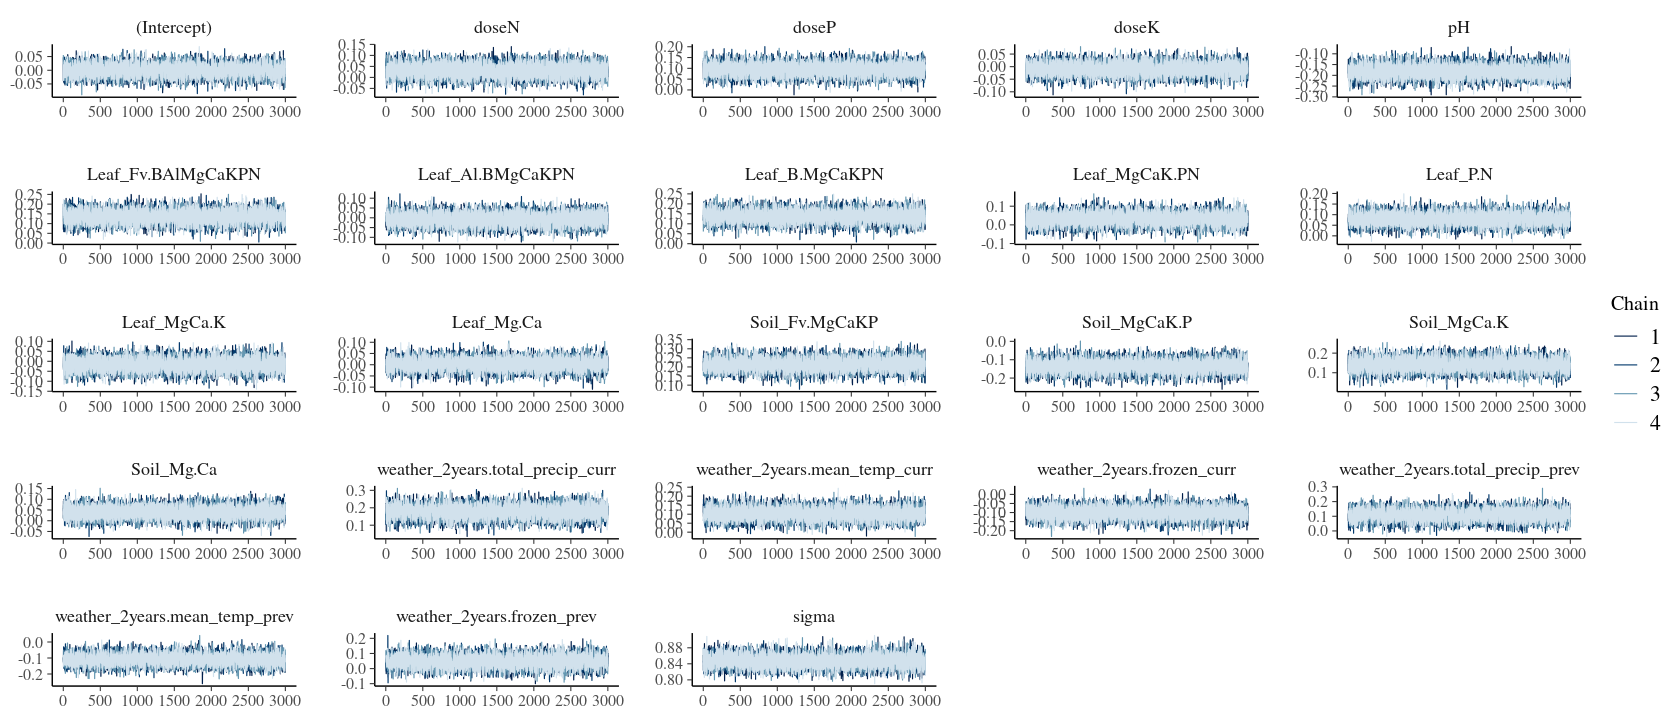

In [53]:
mcmc_trace(lm_bayes)

All caterpillars have constant noise. This is what we want.

A plot can show all effects at one.

In [54]:
lm_summary <- tibble(
  term = names(lm_bayes$coefficients)[-1],
  coefficient = lm_bayes$coefficients[-1]
) %>%
  left_join(translate_df, by = "term")

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



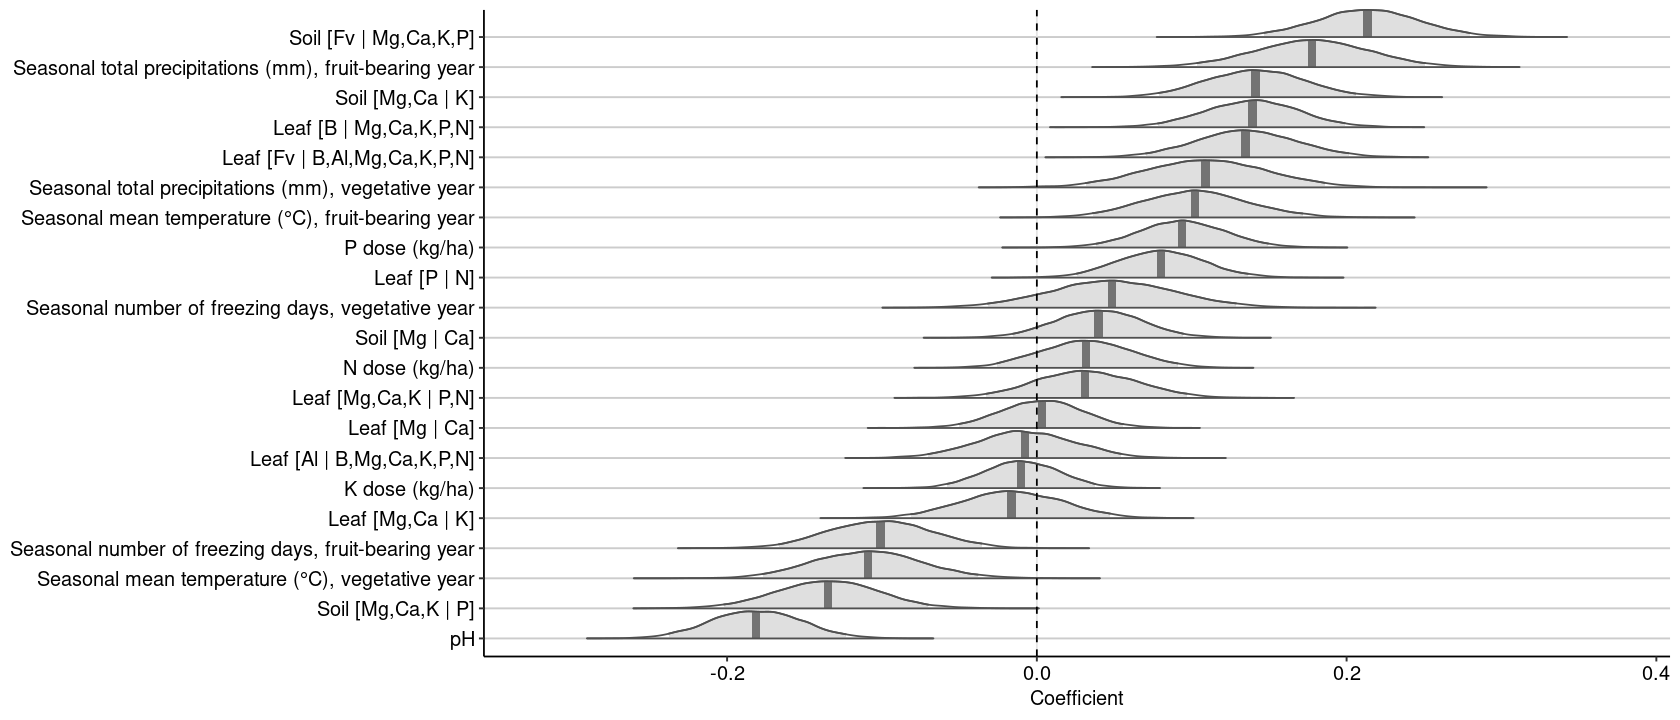

In [55]:
color_scheme_set("gray")
mcmc_areas(
    lm_bayes,
    prob = 0.95,
    pars = lm_summary$term[order(lm_summary$coefficient, decreasing = FALSE)],
    area_method = "equal height"
  ) +
  geom_vline(xintercept = 0, linetype = 2) +
  labs(x = "Coefficient") +
  scale_y_discrete(
    labels = lm_summary$english[order(lm_summary$coefficient, decreasing = FALSE)]
  ) +
  theme_pubr() +
  theme(panel.grid.major.y = element_line(colour = "grey80")) +
  ggsave("images/modlin-bayes_seasonal.png", width = 12, height = 6, dpi = 300)

A better visualisation with results facetted by category.

In [56]:
ggb_seasonnal_range <- c(-0.3, 0.4)

dose_filter <- str_detect(lm_summary$term, "dose")
dose_order <- order(lm_summary$coefficient[dose_filter], decreasing = FALSE)

ggb_doses <- mcmc_areas(
    lm_bayes,
    prob = 0.95,
    pars = lm_summary$term[dose_filter][dose_order],
    area_method = "equal height"
  ) +
  geom_vline(xintercept = 0, linetype = 2) +
  labs(x = "") +
  scale_y_discrete(
    labels = lm_summary$english[dose_filter][dose_order]
  ) +
  xlim(ggb_seasonnal_range) +
  theme_pubr() +
  theme(panel.grid.major.y = element_line(colour = "grey80"))

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.



In [57]:
weather_filter <- str_detect(lm_summary$term, "weather")
weather_order <- order(lm_summary$coefficient[weather_filter], decreasing = FALSE)

ggb_weather <- mcmc_areas(
    lm_bayes,
    prob = 0.95,
    pars = lm_summary$term[weather_filter][weather_order],
    area_method = "equal height"
  ) +
  geom_vline(xintercept = 0, linetype = 2) +
  labs(x = "") +
  scale_y_discrete(
    labels = lm_summary$english[weather_filter][weather_order]
  ) +
  xlim(ggb_seasonnal_range) +
  theme_pubr() +
  theme(panel.grid.major.y = element_line(colour = "grey80"))

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.



In [58]:
leaf_filter <- str_detect(lm_summary$term, "Leaf")
leaf_order <- order(lm_summary$coefficient[leaf_filter], decreasing = FALSE)

ggb_leaf <- mcmc_areas(
    lm_bayes,
    prob = 0.95,
    pars = lm_summary$term[leaf_filter][leaf_order],
    area_method = "equal height"
  ) +
  geom_vline(xintercept = 0, linetype = 2) +
  labs(x = "") +
  scale_y_discrete(
    labels = lm_summary$english[leaf_filter][leaf_order]
  ) +
  xlim(ggb_seasonnal_range) +
  theme_pubr() +
  theme(panel.grid.major.y = element_line(colour = "grey80"))

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.



In [59]:
soil_filter <- str_detect(lm_summary$term, "Soil") | lm_summary$term == "pH"
soil_order <- order(lm_summary$coefficient[soil_filter], decreasing = FALSE)

ggb_soil <- mcmc_areas(
    lm_bayes,
    prob = 0.95,
    pars = lm_summary$term[soil_filter][soil_order],
    area_method = "equal height"
  ) +
  geom_vline(xintercept = 0, linetype = 2) +
  labs(x = "Coefficient") +
  scale_y_discrete(
    labels = lm_summary$english[soil_filter][soil_order]
  ) +
  xlim(ggb_seasonnal_range) +
  theme_pubr() +
  theme(panel.grid.major.y = element_line(colour = "grey80"))

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.



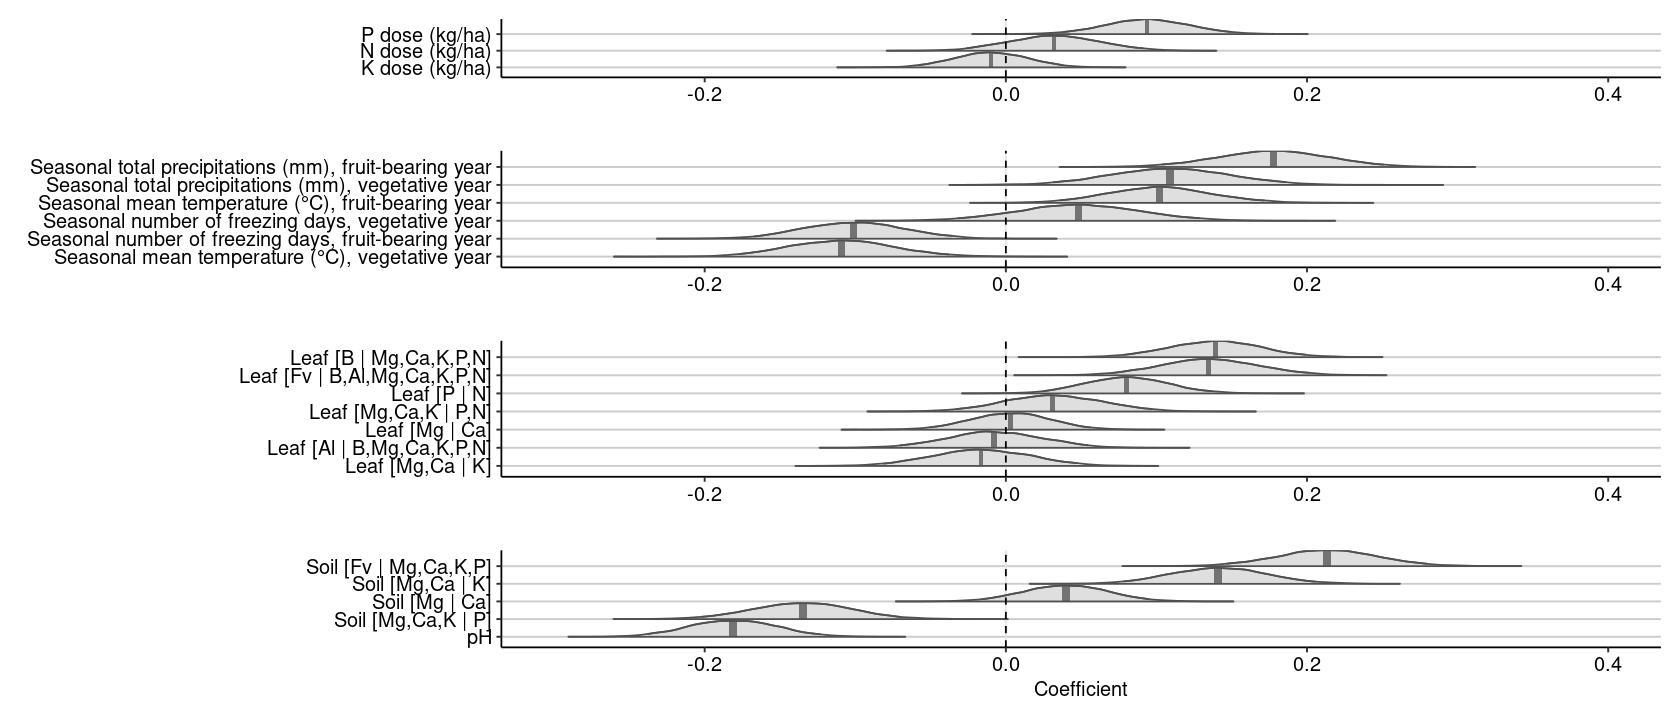

In [60]:
ggb_doses / ggb_weather / ggb_leaf / ggb_soil + 
  plot_layout(heights = c(sum(dose_filter), 
                          sum(weather_filter),
                          sum(leaf_filter),
                          sum(soil_filter))) +
  ggsave("images/modlin-bayes_seasonal.png", width = 12, height = 8, dpi = 300)

### Weather current

In this section we investigate the effect of several variables where weather is considered only in the current year, on a monthly basis.

In [61]:
df_stats <- df_ %>%
  select(
    `Berry yield (kg/ha)`,
    `N dose (kg/ha)`,
    `P dose (kg/ha)`,
    `K dose (kg/ha)`,
    `pH H2O`,
    starts_with("Leaf_"),
    starts_with("Soil_"),
    starts_with("weather_current"),
    # Random effects
    Year, Site, Block
  ) %>%
  rename(
    yield = `Berry yield (kg/ha)`,
    doseN = `N dose (kg/ha)`,
    doseP = `P dose (kg/ha)`,
    doseK = `K dose (kg/ha)`,
    pH = `pH H2O`
  ) %>%
  drop_na()

In [62]:
linmod_formula <- yield ~ doseN + doseP + doseK + pH +
  Leaf_Fv.BAlMgCaKPN + Leaf_Al.BMgCaKPN + Leaf_B.MgCaKPN + 
  Leaf_MgCaK.PN + Leaf_P.N + Leaf_MgCa.K + Leaf_Mg.Ca +
  Soil_Fv.MgCaKP + Soil_MgCaK.P + Soil_MgCa.K + Soil_Mg.Ca +
  `weather_current.total_precip_Flower open`

In [63]:
linmod_formula <- yield ~ doseN + doseP + doseK + pH +
  Leaf_Fv.BAlMgCaKPN + Leaf_Al.BMgCaKPN + Leaf_B.MgCaKPN + 
  Leaf_MgCaK.PN + Leaf_P.N + Leaf_MgCa.K + Leaf_Mg.Ca +
  Soil_Fv.MgCaKP + Soil_MgCaK.P + Soil_MgCa.K + Soil_Mg.Ca +
  `weather_current.total_precip_Before flower bud opening` + 
  `weather_current.total_precip_Flower bud opening` +
  `weather_current.total_precip_Flower open` +
  `weather_current.total_precip_Fruit maturation` +
  `weather_current.total_precip_After fruit maturation` +
  `weather_current.mean_temp_Before flower bud opening` +
  `weather_current.mean_temp_Flower bud opening` +
  `weather_current.mean_temp_Flower open` +
  `weather_current.mean_temp_Fruit maturation` +
  `weather_current.mean_temp_After fruit maturation` + 
  `weather_current.frozen_Before flower bud opening`# +
  #`weather_current.frozen_Flower bud opening` # no frozen at that stage

df_stats_recipe <-
  df_stats %>%
  recipe(linmod_formula) %>%
  step_log(all_outcomes(), base = 10) %>% 
  step_normalize(-all_outcomes(), all_numeric()) %>%
  prep()

#### Frequential framework

In [64]:
lm_freq <- lm(linmod_formula, data = juice(df_stats_recipe))

Parsed with column specification:
cols(
  term = col_character(),
  english = col_character()
)



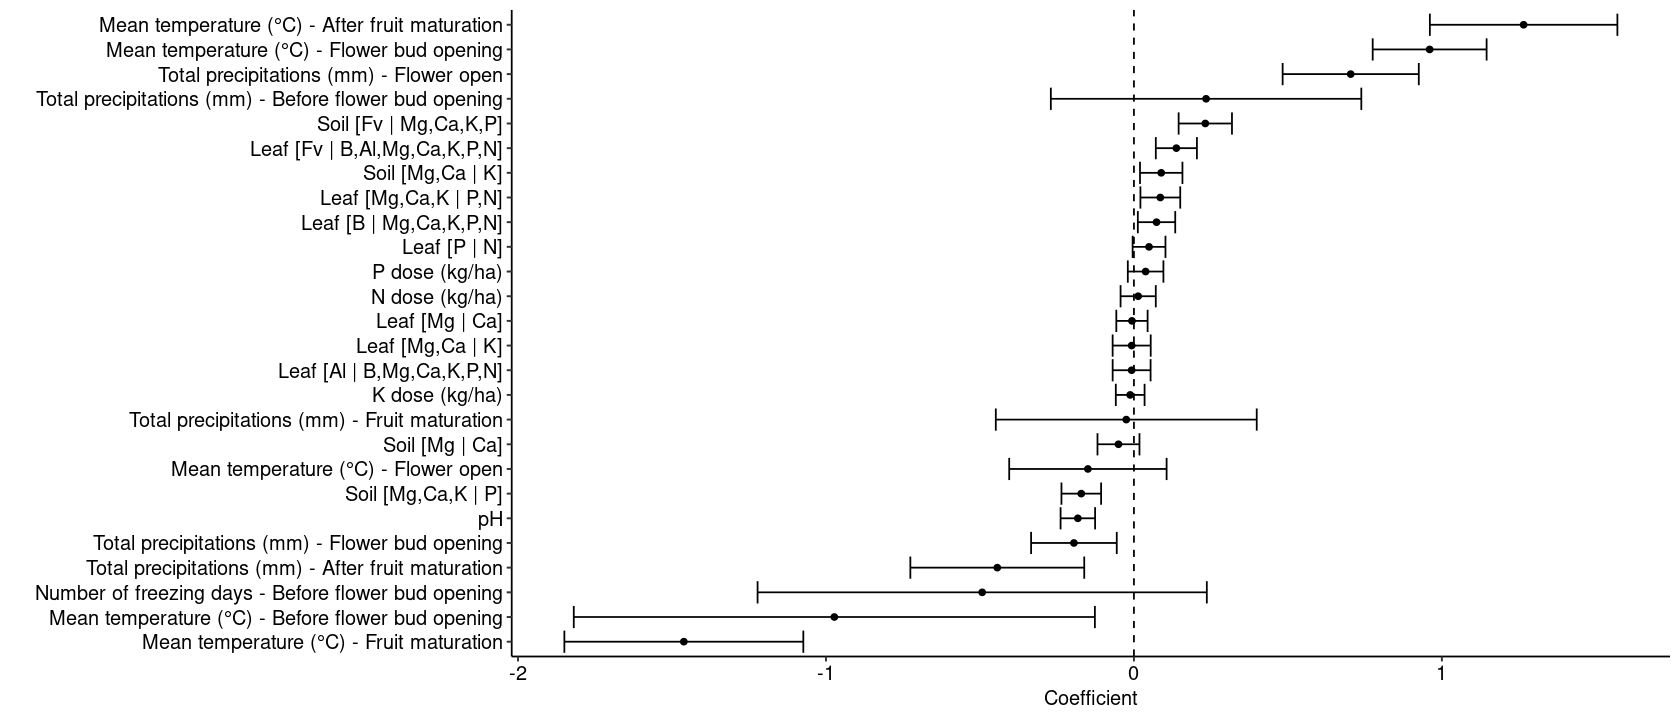

In [65]:
translate_df <- read_csv("data/translate_names.csv")

tidy(lm_freq, conf.int = TRUE) %>%
  filter(term != "(Intercept)") %>%
  left_join(translate_df, by = "term") %>%
  mutate(english = fct_reorder(english, estimate)) %>%
  ggplot(aes(estimate, english)) +
  geom_vline(xintercept = 0, linetype = 2) +
  geom_point() +
  geom_errorbarh(aes(xmin = conf.low, xmax = conf.high)) +
  labs(x = "Coefficient", y = "") +
  theme_pubr() +
  ggsave("images/modlin-freq_monthly.png", width = 8, height = 8, dpi = 300)

#### Bayesian framework

In [66]:
library("rstanarm")
library("tidybayes")
library("bayesplot")

lm_bayes <- stan_glm(
  linmod_formula,
  data = juice(df_stats_recipe),
  family = gaussian(),
  prior = normal(0, 10),
  prior_intercept = normal(0, 10),
  iter = 4000,
  warmup = 1000,
  cores = 4,
  seed = 8578234
)

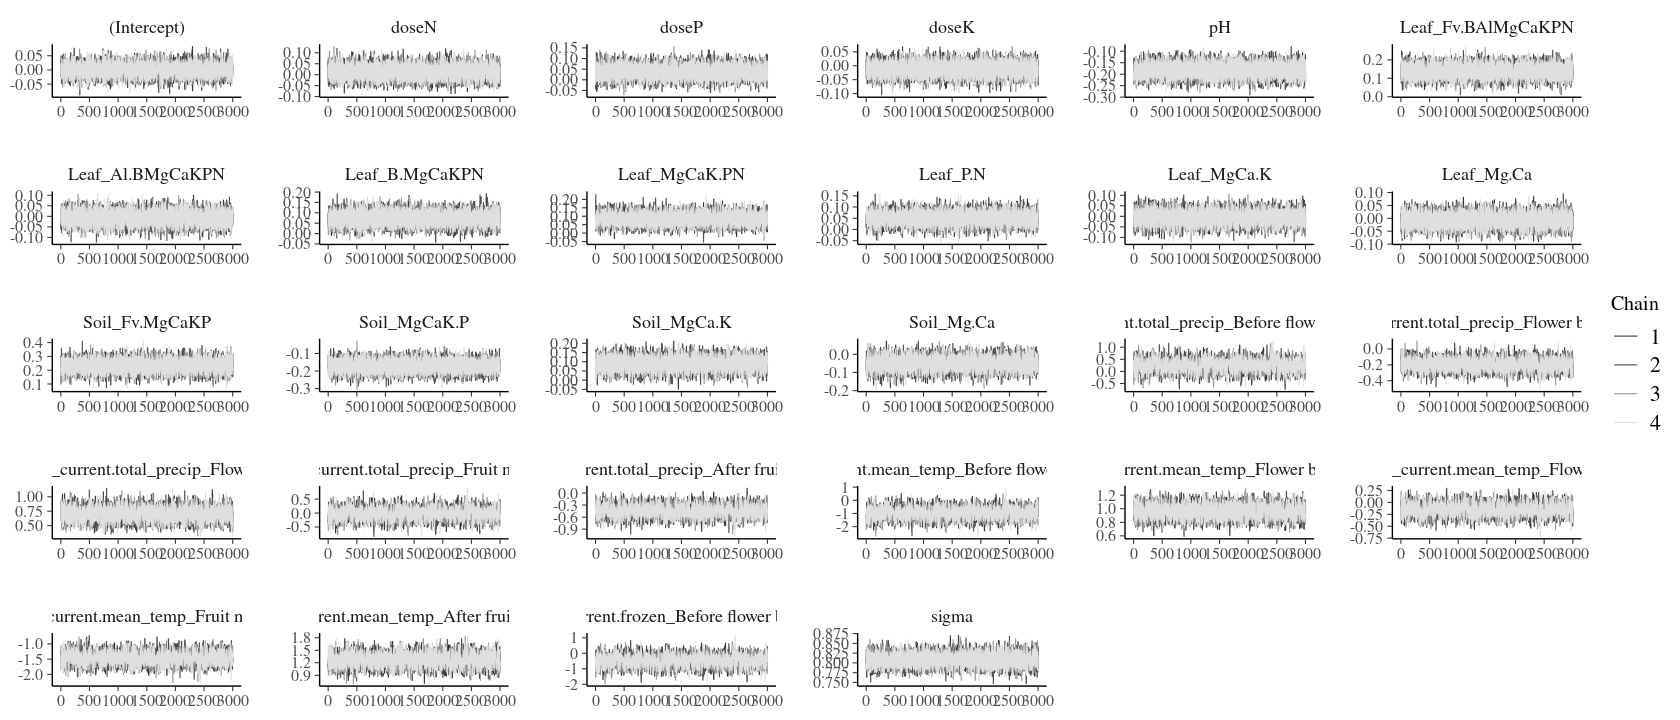

In [67]:
mcmc_trace(lm_bayes)

All caterpillars have constant noise. This is what we want.

In [68]:
lm_summary <- tibble(
  term = names(lm_bayes$coefficients)[-1],
  coefficient = lm_bayes$coefficients[-1]
) %>%
  left_join(translate_df, by = "term")

Plot all at once.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



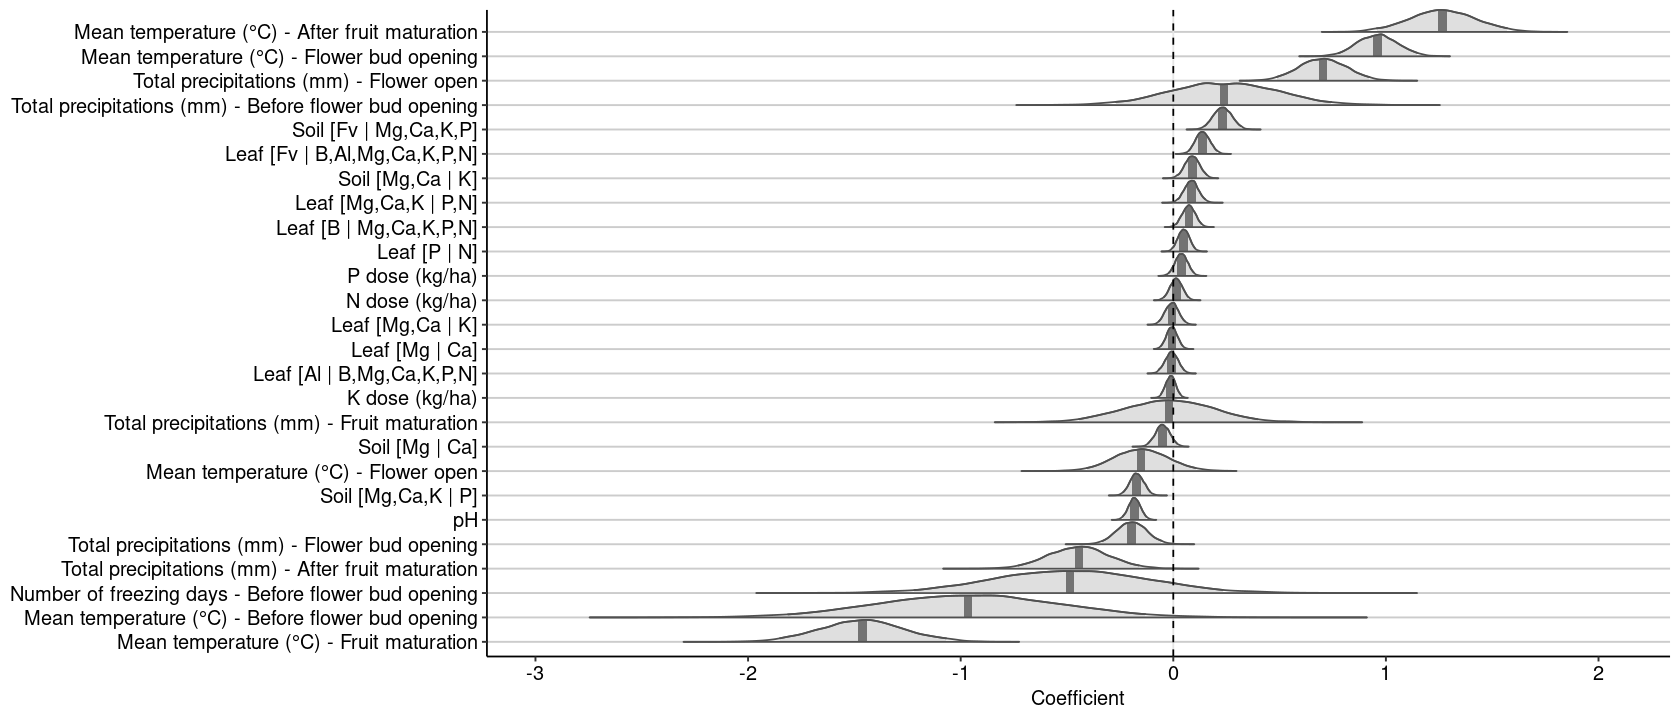

In [69]:
color_scheme_set("gray")
mcmc_areas(
    lm_bayes,
    prob = 0.95,
    pars = lm_summary$term[order(lm_summary$coefficient, decreasing = FALSE)],
    area_method = "equal height"
  ) +
  geom_vline(xintercept = 0, linetype = 2) +
  labs(x = "Coefficient") +
  scale_y_discrete(
    labels = lm_summary$english[order(lm_summary$coefficient, decreasing = FALSE)]
  ) +
  theme_pubr() +
  theme(panel.grid.major.y = element_line(colour = "grey80")) +
  ggsave("images/modlin-bayes_phenology.png", width = 12, height = 8, dpi = 300)

A better visualisation with results facetted by category.

In [70]:
ggb_pheno_range <- c(-2.5, 2)

dose_filter <- str_detect(lm_summary$term, "dose")
dose_order <- order(lm_summary$coefficient[dose_filter], decreasing = FALSE)

ggb_doses <- mcmc_areas(
    lm_bayes,
    prob = 0.95,
    pars = lm_summary$term[dose_filter][dose_order],
    area_method = "equal height"
  ) +
  geom_vline(xintercept = 0, linetype = 2) +
  labs(x = "") +
  scale_y_discrete(
    labels = lm_summary$english[dose_filter][dose_order]
  ) +
  xlim(ggb_pheno_range) +
  theme_pubr() +
  theme(panel.grid.major.y = element_line(colour = "grey80"))

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.



In [71]:
weather_filter <- str_detect(lm_summary$term, "weather")
weather_order <- order(lm_summary$coefficient[weather_filter], decreasing = FALSE)

ggb_weather <- mcmc_areas(
    lm_bayes,
    prob = 0.95,
    pars = lm_summary$term[weather_filter][weather_order],
    area_method = "equal height"
  ) +
  geom_vline(xintercept = 0, linetype = 2) +
  labs(x = "") +
  scale_y_discrete(
    labels = lm_summary$english[weather_filter][weather_order]
  ) +
  xlim(ggb_pheno_range) +
  theme_pubr() +
  theme(panel.grid.major.y = element_line(colour = "grey80"))

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.



In [72]:
leaf_filter <- str_detect(lm_summary$term, "Leaf")
leaf_order <- order(lm_summary$coefficient[leaf_filter], decreasing = FALSE)

ggb_leaf <- mcmc_areas(
    lm_bayes,
    prob = 0.95,
    pars = lm_summary$term[leaf_filter][leaf_order],
    area_method = "equal height"
  ) +
  geom_vline(xintercept = 0, linetype = 2) +
  labs(x = "") +
  scale_y_discrete(
    labels = lm_summary$english[leaf_filter][leaf_order]
  ) +
  xlim(ggb_pheno_range) +
  theme_pubr() +
  theme(panel.grid.major.y = element_line(colour = "grey80"))

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.



In [73]:
soil_filter <- str_detect(lm_summary$term, "Soil") | lm_summary$term == "pH"
soil_order <- order(lm_summary$coefficient[soil_filter], decreasing = FALSE)

ggb_soil <- mcmc_areas(
    lm_bayes,
    prob = 0.95,
    pars = lm_summary$term[soil_filter][soil_order],
    area_method = "equal height"
  ) +
  geom_vline(xintercept = 0, linetype = 2) +
  labs(x = "Coefficient") +
  scale_y_discrete(
    labels = lm_summary$english[soil_filter][soil_order]
  ) +
  xlim(ggb_pheno_range) +
  theme_pubr() +
  theme(panel.grid.major.y = element_line(colour = "grey80"))

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.



Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”


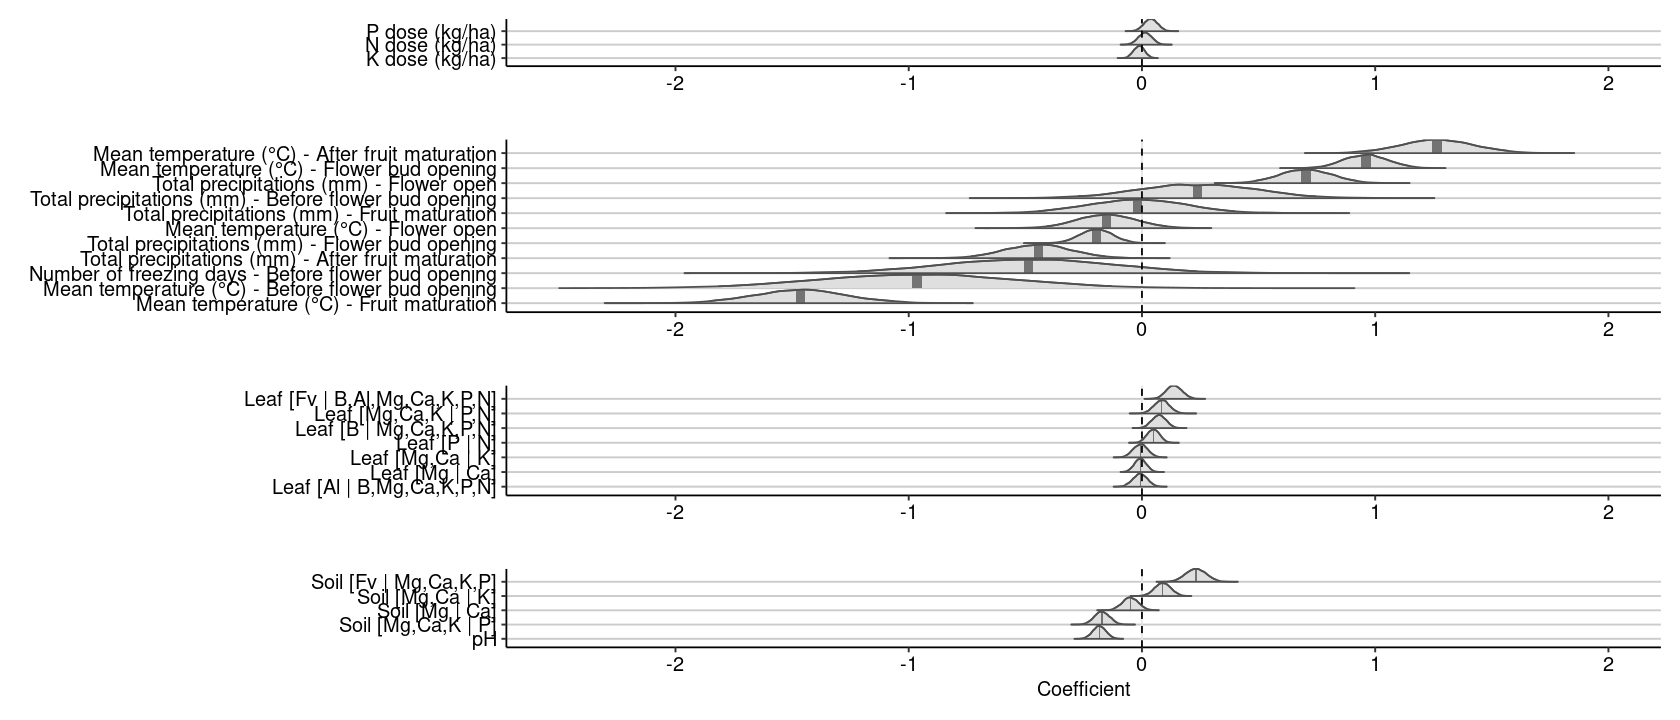

In [74]:
ggb_doses / ggb_weather / ggb_leaf / ggb_soil + 
  plot_layout(heights = c(sum(dose_filter), 
                          sum(weather_filter),
                          sum(leaf_filter),
                          sum(soil_filter))) +
  ggsave("images/modlin-bayes_phenology.png", width = 12, height = 8, dpi = 300)

## Predictive modelling

While the previous models aimed at investigating effects, the model developped in this section aims at predicting outcomes.

I throw a random seed to make sure that the notebook can be reproduced.

In [75]:
set.seed(3174806) # random.org

Molelling yield from the NPK dosage and soil conditions

In [76]:
df_npk <- df_ %>%
  select(
    `Berry yield (kg/ha)`,
    `N dose (kg/ha)`,
    `P dose (kg/ha)`,
    `K dose (kg/ha)`,
    `pH H2O`,
    starts_with("Leaf_"),
    starts_with("Soil_"),
    starts_with("weather_before")
  ) %>%
  rename(
    yield = `Berry yield (kg/ha)`,
    doseN = `N dose (kg/ha)`,
    doseP = `P dose (kg/ha)`,
    doseK = `K dose (kg/ha)`,
    pH = `pH H2O`
  ) %>%
  drop_na()

Remove GDD since it is redundant with mean temperature, and freezing days since they are not consistent from a year to another, which is unreliable for prediction.

In [77]:
df_npk <- df_npk %>% 
  select(
      -starts_with("weather_before.GDD"),
      -starts_with("weather_before.frozen"))

Many machine learning functions reject spaces in column names. The following code create more universal column names from now on.

In [78]:
df_npk_init_colnames <- tibble(term = names(df_npk),
                               term_model = make.names(names(df_npk), unique=TRUE))
names(df_npk) <- df_npk_init_colnames$term_model

The following variables will be used for modelling.

In [79]:
names(df_npk)

[1] "yield"                                                
 [2] "doseN"                                                
 [3] "doseP"                                                
 [4] "doseK"                                                
 [5] "pH"                                                   
 [6] "Leaf_Fv.BAlMgCaKPN"                                   
 [7] "Leaf_Al.BMgCaKPN"                                     
 [8] "Leaf_B.MgCaKPN"                                       
 [9] "Leaf_MgCaK.PN"                                        
[10] "Leaf_P.N"                                             
[11] "Leaf_MgCa.K"                                          
[12] "Leaf_Mg.Ca"                                           
[13] "Soil_Fv.MgCaKP"                                       
[14] "Soil_MgCaK.P"                                         
[15] "Soil_MgCa.K"                                          
[16] "Soil_Mg.Ca"                                           
[17] "weather_before.total_precip_Before.flower.bud.opening"
[18] "weather_before.total_precip_Flower.bud.opening"       
[19] "weather_before.total_precip_Flower.open"              
[20] "weather_before.total_precip_Fruit.maturation"         
[21] "weather_before.total_precip_After.fruit.maturation"   
[22] "weather_before.mean_temp_Before.flower.bud.opening"   
[23] "weather_before.mean_temp_Flower.bud.opening"          
[24] "weather_before.mean_temp_Flower.open"                 
[25] "weather_before.mean_temp_Fruit.maturation"            
[26] "weather_before.mean_temp_After.fruit.maturation"

Train / test split.

In [80]:
npk_split <- initial_split(df_npk, prop = 0.7)

npk_train <- training(npk_split)
npk_test <- testing(npk_split)

Preprocessing recipe.

In [81]:
npk_recipe <- npk_train %>%
  recipe(yield ~ .) %>%
  #step_log(all_outcomes(), base = 10) %>% # toggle
  step_normalize(all_numeric()) %>%
  #step_inverse(all_outcomes()) %>% # toggle
  prep()

#mean_logy <- mean(log10(npk_train$yield)) # toggle
#sd_logy <- sd(log10(npk_train$yield)) # toggle

mean_y <- mean(npk_train$yield)
sd_y <- sd(npk_train$yield)

mean_npk_train <- npk_train %>%
  apply(., 2, mean)

sd_npk_train <- npk_train %>%
  apply(., 2, sd)

# the recipes package does not allow backtransformation yet
# https://github.com/tidymodels/recipes/issues/264

step_back <- function(y) {
  #y <- 1/y # toggle
  #y <- 10 ^ (y * sd_logy + mean_logy) # toggle
  y <- y * sd_y + mean_y
  return(y)
}

train_baked <- bake(npk_recipe, npk_train)
test_baked <-  bake(npk_recipe, npk_test)

write_csv(x = train_baked, path = "output/train_baked.csv")
write_csv(x = test_baked, path = "output/test_baked.csv")

### Variable importance

Variable importance in the model can be assessed with extreme gradient boosted tree modeling with **`caret`**.

In [82]:
library("caret")
set.seed(2779781) # random.org

train_control <- trainControl(
  method = "repeatedcv",
  number = 3
)

# These parameters minimise bias and return similar R² in training
# and testing
tune_xgb <- expand.grid( # xgbTree
  nrounds = 50, # not too much to avoid overfit
  max_depth = 2, #c(1, 2, 4, 6, 8, 10), # few avoids overfit
  eta = 0.25, #c(0.001, 0.01, 0.1), # not too high to avoid bias
  gamma = 1,
  colsample_bytree = 0.75,
  min_child_weight = 7, #c(3, 5, 7)
  subsample = 0.95#c(0.3, 0.5, 0.8) # too high or too low can create a bias
)

Loading required package: lattice


Attaching package: ‘caret’


The following objects are masked from ‘package:rstanarm’:

    compare_models, R2


The following object is masked from ‘package:compositions’:

    R2


The following objects are masked from ‘package:yardstick’:

    precision, recall, sensitivity, specificity


The following object is masked from ‘package:purrr’:

    lift




In [83]:
m_fit <- train(yield ~ .,
               data = train_baked,
               method = "xgbTree",
               trControl = train_control,
               tuneGrid = tune_xgb,
               verbose = FALSE
)

[16:46:01] WARNING: amalgamation/../src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:01] WARNING: amalgamation/../src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:01] WARNING: amalgamation/../src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:02] WARNING: amalgamation/../src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.


Quick actual-predicted check.

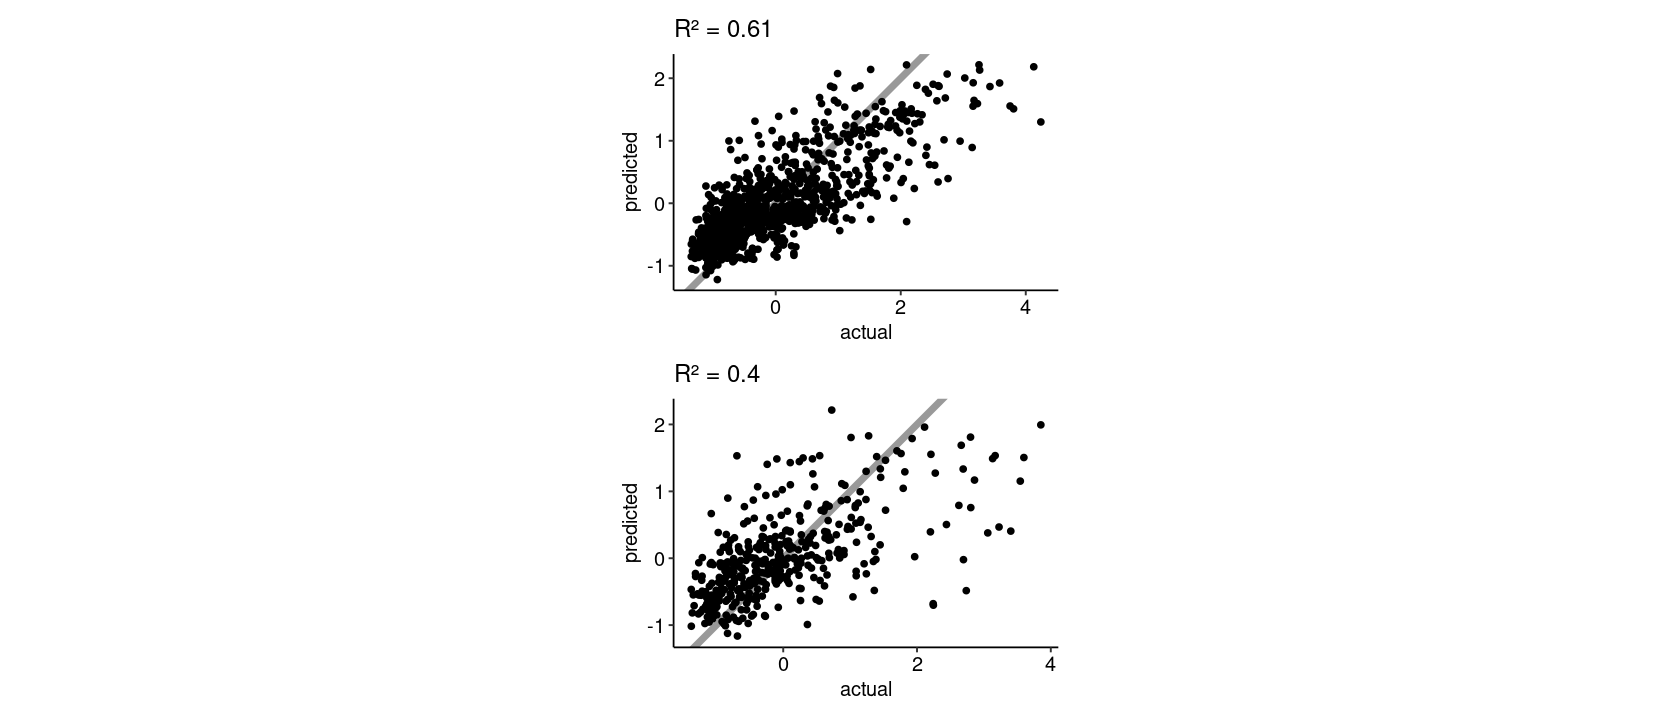

In [84]:
rsq_tr <- cor(train_baked$yield, predict(m_fit))^2
rsq_te <- cor(test_baked$yield, predict(m_fit, newdata = test_baked))^2

gg_tr <- tibble(actual = train_baked$yield,
                predicted = predict(m_fit)) %>%
  ggplot(aes(x = actual, y = predicted)) +
  geom_abline(slope = 1, intercept = 0, colour = "gray60", lwd = 2) +
  geom_point() +
  labs(title = paste("R² =", round(rsq_tr, 2))) +
  theme_pubr() +
  coord_equal()

gg_te <- tibble(actual = test_baked$yield,
       predicted = predict(m_fit, newdata = test_baked)) %>%
  ggplot(aes(x = actual, y = predicted)) +
  geom_abline(slope = 1, intercept = 0, colour = "gray60", lwd = 2) +
  geom_point() +
  labs(title = paste("R² =", round(rsq_te, 2))) +
  theme_pubr() +
  coord_equal()

gg_tr / gg_te

Importance of variables in the model.

In [85]:
translate_df_nbt <- translate_df %>% # translate table no back tick
  mutate(term = str_replace(term, "`", ""),
         term = str_replace(term, "`", ""))

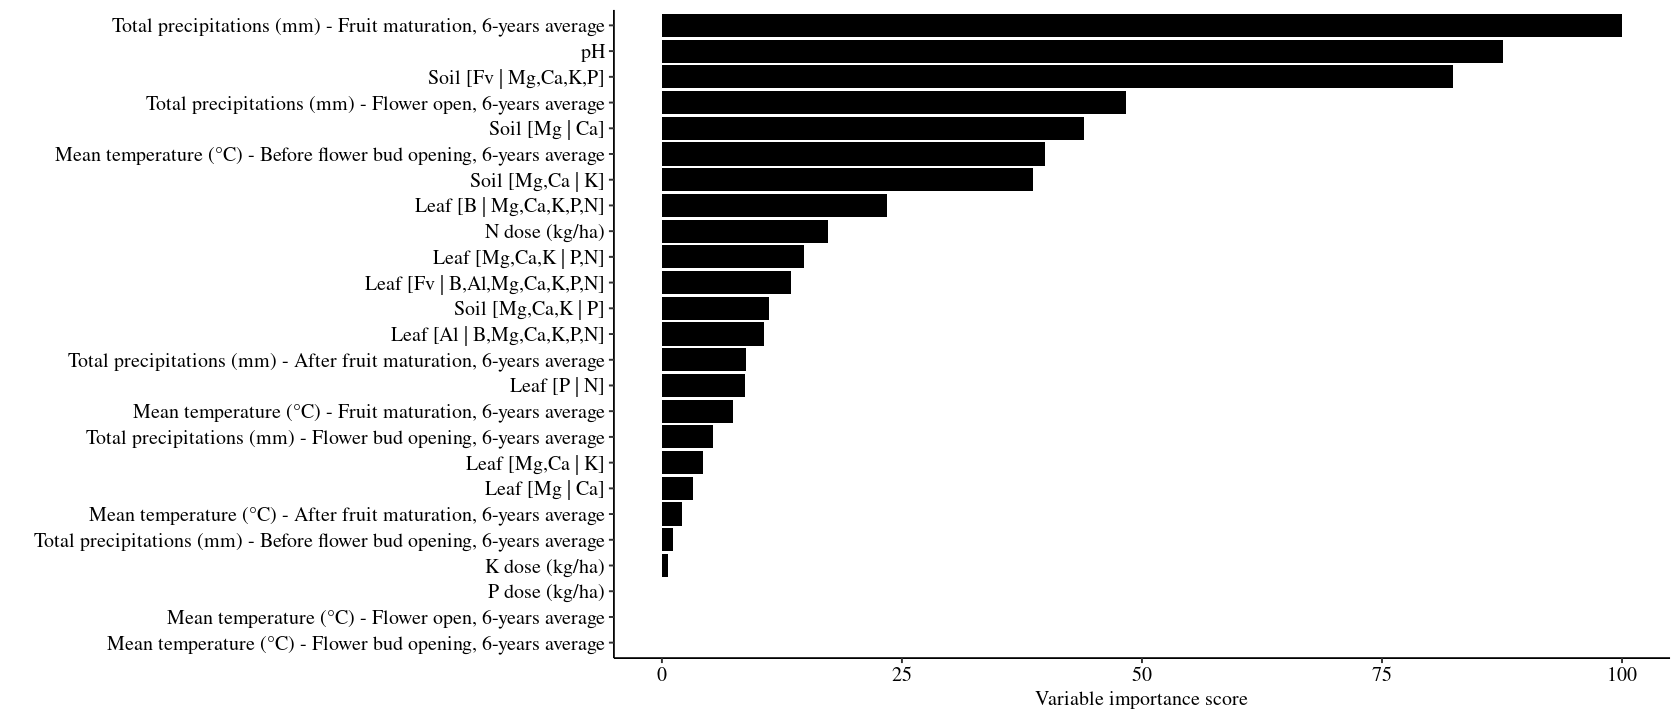

In [86]:
tibble(term_model = rownames(varImp(m_fit)$importance),
       score = varImp(m_fit)$importance[, 1]) %>%
  left_join(df_npk_init_colnames, by = "term_model") %>%
  select(-term_model) %>%
  left_join(translate_df_nbt, by = "term")  %>%
  mutate(english = fct_reorder(factor(english), score)) %>%
  ggplot(aes(y = score, x = english)) +
  geom_bar(stat = "identity", fill = "black", lwd = 0) +
  labs(x = "", y = "Variable importance score") +
  coord_flip() +
  theme_pubr() +
  theme(text=element_text(family="serif")) +
  ggsave("images/varimp.png", width = 6, height = 5, dpi = 300)

⚠️ Feature importance changes widely by changing the random seeds. It is considered exploratory, but not reliable.

### Prediction model

Variable importance can't be assessed with Gaussian processes, which is a great tool to model smooth phenomenons like those occuring in agroecosystems ([Coulibali et al. 2020](https://doi.org/10.1101/2020.03.12.988626)).

In [87]:
tune_gp <- expand.grid( # gaussprRadial
  sigma = 0.1#c(0.05, 0.1, 0.15, 0.2)
)

m_fit <- train(yield ~ .,
               data = train_baked,
               method = "gaussprRadial",
               trControl = train_control,
               tuneGrid = tune_gp,
               verbose = FALSE
)

Create tables to plot observed vs predicted.

In [88]:
train_pred <- tibble(
  yield = npk_train$yield,
  pred = step_back(predict(m_fit, newdata = bake(npk_recipe, npk_train)))
)

test_pred <- tibble(
  yield = npk_test$yield,
  pred = step_back(predict(m_fit, newdata = bake(npk_recipe, npk_test)))
)

rsq_tr <- cor(train_pred$yield, train_pred$pred)^2
rsq_te <- cor(test_pred$yield, test_pred$pred)^2

rmse_tr <- mean(abs(train_pred$yield - train_pred$pred))
rmse_te <- mean(abs(test_pred$yield - test_pred$pred))

Plot observed vs predicted.

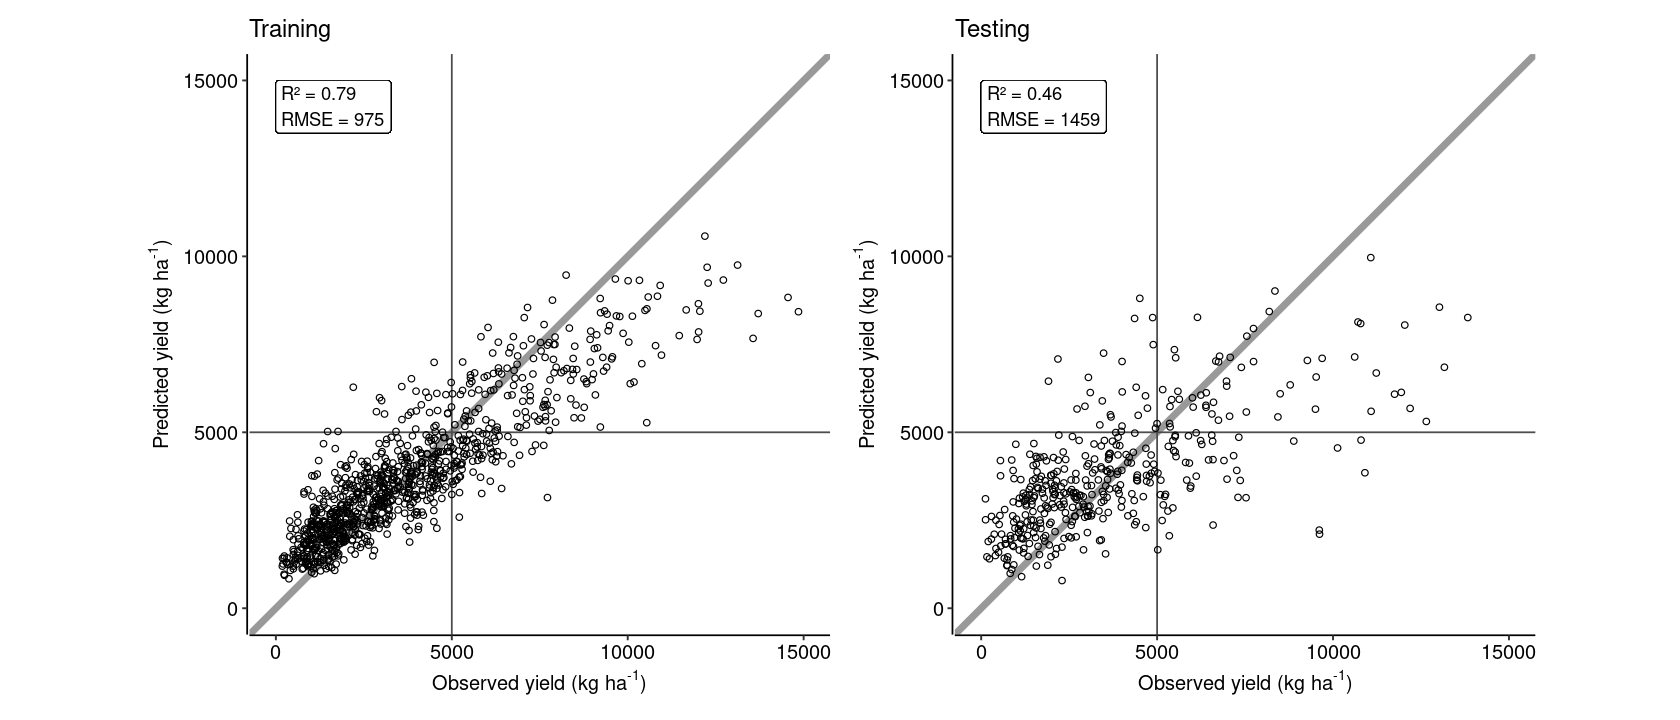

In [89]:
delimiter <- 5000
gg_pred_f <- function(data, rsq, rmse, title) {
  data %>%
    ggplot(aes(x = yield, y = pred)) +
    geom_abline(slope = 1, intercept = 0, colour = "gray60", lwd = 2) +
    geom_vline(xintercept = delimiter, colour = "gray30") +
    geom_hline(yintercept = delimiter, colour = "gray30") +
    geom_label(x = 0, y = 15000,
               vjust = 1, hjust = 0,
               label = paste("R² =", signif(rsq, 2), "\nRMSE =", round(rmse, 0))) +
    geom_point(pch = 1) +
    labs(x = expression("Observed yield (kg ha"^"-1"*")"),
         y = expression("Predicted yield (kg ha"^"-1"*")"), 
         title = title) +
    expand_limits(x = c(0, 15000), y = c(0, 15000)) +
    coord_equal() +
    theme_pubr()# +
    #theme(text=element_text(family="serif"))
}

gg_training <- gg_pred_f(train_pred, rsq_tr, rmse_tr, "Training")
gg_testing <- gg_pred_f(test_pred, rsq_te, rmse_te, "Testing")

gg_training + gg_testing

ggsave("images/modpred.png", width = 10, height = 5, dpi = 300)

Binary classification.

In [90]:
delimiter <- 5000
test_bc <- test_pred %>%
  mutate(
    yield = case_when(
      yield >= delimiter ~ "HY",
      TRUE ~ "LY"
    ),
    pred = case_when(
      pred >= delimiter ~ "HY",
      TRUE ~ "LY"
    )
  )
test_cm <- table(test_bc)
print("Accuracy")
(test_cm[1, 1] + test_cm[2, 2]) / sum(test_cm)
print("PPV")
test_cm[2, 2] / sum(test_cm[2, ])
print("NPV")
test_cm[1, 1] / sum(test_cm[1, ])

[1] "Accuracy"


[1] 0.826506

[1] "PPV"


[1] 0.9203822

[1] "NPV"


[1] 0.5346535

# Predictive modelling usage with conditional features

We use a seed to assure reproducibility.

In [91]:
set.seed(808668) # random.org

Among our features, only weather is uncontrollable. We can intervene to affect soil chemistry, leaf nutrients and NPK dosage.

In [92]:
conditional_features <- df_npk %>%
  select(starts_with("weather"), -yield) %>%
  names()

managed_features <- df_npk %>%
  select(-starts_with("weather"), -yield) %>%
  names()

We randomly sample a low performing site whose ionome should be investigated, extract its ionome and predict its yield.

In [93]:
observation <- df_npk %>% 
  filter(yield < 3000) %>% 
  sample_n(1)

I recall the original table to recover the ID of the randomly selected observation.

In [94]:
observation_id <- df_source %>%
  filter(`Berry yield (kg/ha)` == observation$yield,
         `pH H2O` == observation$pH) %>%
  pull(id)
print(paste0("The randomly selection row ID is ", observation_id, "."))

[1] "The randomly selection row ID is 1269."


We set convergence parameters. `max_iter` is the number of steps in the Markov chain. The `radius` is the Euclidean distance where to scan around the point at each step. The initial radius, `radius[1]` is also the base radius, i.e. if a point with better yield is found, the radius goes back to this initial radius (`radius[1]`), else it is multiplied by `radius_factor` to enlarge scanning. Finally `n_rad` is the number of points to sample around the ionome of the preceeding step.

In [95]:
max_iter <- 20
radius <- c(10)
radius_factor <- 1.5 # for adaptative search
radius_limits <- c(0.5, 50)
## if the max is too high, all explored ionome risk to be filtered out due
## to extrapolation (see Mahalanobis distance below). The upper limit
## should be set in relation to the p in qchisq below.
n_rad <- 1000

To scan around a point, we create a new table. This new table has the same names than the one on which the model was fitted. Conditional features are kept constant. Managed features are filled with NAs, except the first row, corresponding to the "misbalanced observation", which initializes the Markov chain.

In [96]:
features_iterations <- observation %>%
  slice(rep(row_number(), max_iter))
for (col in managed_features) features_iterations[2:max_iter, col] <- NA
iterations_yield <- c(step_back(predict(m_fit, newdata = bake(npk_recipe, observation))))

We use a mahalanobis distance to ensure that the algorithm doesn't explore too far from the theoretical multivariate normal distribution of the features. To compute the Mahalanobis distance, we need the mean, the (invert) covariance and a critical (squared) distance.

In [97]:
contr_mean <- apply(train_baked %>% select(one_of(managed_features), -yield), 2, mean) # should be zero
contr_sd <- apply(train_baked %>% select(one_of(managed_features), -yield), 2, mean)
contr_icov <- solve(cov(train_baked %>% select(one_of(managed_features), -yield)))
crit_dist <- qchisq(p = 0.99, df = length(contr_mean))

The prediction will be based on baked data.

In [98]:
features_iterations_baked <- bake(npk_recipe, features_iterations) %>% select(-yield)

And stored in a matrix.

In [99]:
iterations_managed <- features_iterations_baked %>%
  select(managed_features) %>%
  as.matrix()

Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(managed_features)` instead of `managed_features` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.



At each iteration, we bind a table of contitional features to the table containing n_rad explorations.

In [100]:
observation_condition_baked <- observation %>% 
  bake(npk_recipe, .)  %>%
  select(!c(managed_features, "yield")) %>%
  slice(rep(row_number(), n_rad))

... and fire the Markov chain.

[1] "Iteration 2 - yield improved to 4598.2275833992"
[1] "Iteration 3 - no yield improvement."
[1] "Iteration 4 - no yield improvement."
[1] "Iteration 5 - no yield improvement."
[1] "Iteration 6 - all points are out of the hyperellipsoid."
[1] "Iteration 7 - all points are out of the hyperellipsoid."
[1] "Iteration 8 - all points are out of the hyperellipsoid."
[1] "Iteration 9 - all points are out of the hyperellipsoid."
[1] "Iteration 10 - all points are out of the hyperellipsoid."
[1] "Iteration 11 - all points are out of the hyperellipsoid."
[1] "Iteration 12 - all points are out of the hyperellipsoid."
[1] "Iteration 13 - all points are out of the hyperellipsoid."
[1] "Iteration 14 - all points are out of the hyperellipsoid."
[1] "Iteration 15 - all points are out of the hyperellipsoid."
[1] "Iteration 16 - all points are out of the hyperellipsoid."
[1] "Iteration 17 - all points are out of the hyperellipsoid."
[1] "Iteration 18 - all points are out of the hyperellipsoid."
[1] "

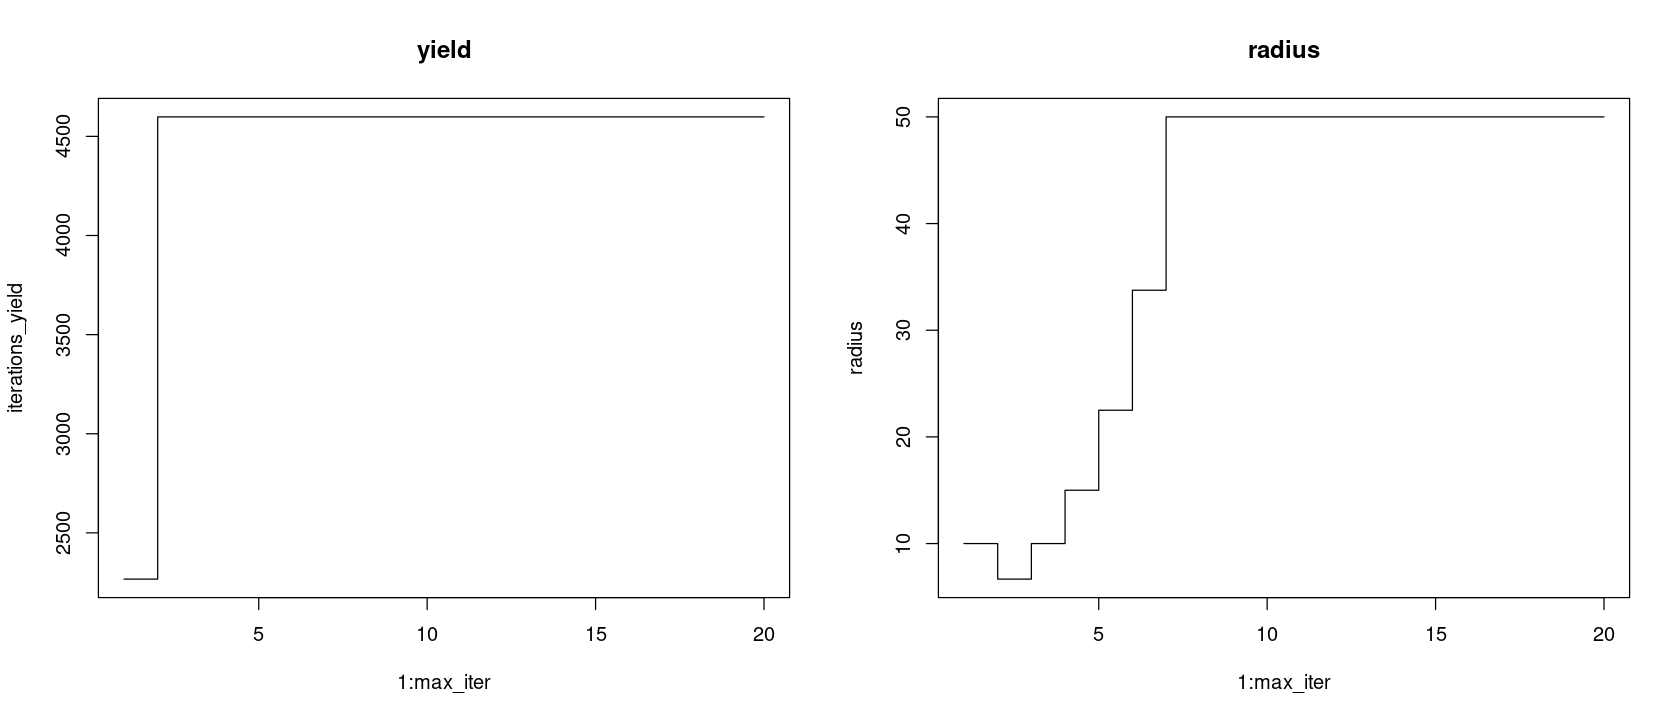

In [101]:
for (i in 2:max_iter) {
  # print(paste(i, "/", max_iter))
  offset <- matrix(runif(length(managed_features) * n_rad, -1, 1), 
                   ncol = length(managed_features),
                   nrow = n_rad)
  offset <- t(apply(offset, 1, function(x) radius[i-1] * x / sqrt(sum(x^2))))
  offset <- offset * runif(length(offset), 0, 1)
  observation_search <- t(apply(offset, 1, function(x) x + iterations_managed[i-1, ]))

  # Compute the Mahalanobis distance
  maha_dist <- mahalanobis(observation_search, contr_mean, contr_icov, inverted = TRUE)
  # filter out search ionomes outside the Mahalanobis distance limit
  df_search <- data.frame(observation_search) %>%
    bind_cols(observation_condition_baked) %>%
    filter(maha_dist < crit_dist) %>%
    mutate(doseN = abs(doseN), # assure positive dosage
           doseP = abs(doseP),
           doseK = abs(doseK))
    
  if(nrow(df_search) == 0) { # if no points are generated in the hyper ellipsoid, keep the reference but increase radius
    print(paste("Iteration", i, "- all points are out of the hyperellipsoid."))
    iterations_yield[i] <- iterations_yield[i-1]
    iterations_managed[i, ] <- iterations_managed[i-1, ]
    # increase the radius
    radius[i] <- radius[i - 1] * radius_factor
    radius[i] <- ifelse(radius[i] > radius_limits[2], radius_limits[2], radius[i])
  } else {
    # Compute predicted yield
    yield_stochastic <- step_back(predict(m_fit, newdata = df_search))
    if(max(yield_stochastic) > iterations_yield[i-1]) {
      print(paste("Iteration", i, "- yield improved to", max(yield_stochastic)))
      iterations_yield[i] <- max(yield_stochastic)
      iterations_managed[i, ] <- df_search[which.max(yield_stochastic), managed_features] %>% unlist()
      # decrease the radius
      radius[i] <- radius[i - 1] / radius_factor
      radius[i] <- ifelse(radius[i] < radius_limits[1], radius_limits[1], radius[i])
    } else {
      print(paste("Iteration", i, "- no yield improvement."))
      iterations_yield[i] <- iterations_yield[i-1]
      iterations_managed[i, ] <- iterations_managed[i-1, ]
      # increase the radius
      radius[i] <- radius[i - 1] * radius_factor
      radius[i] <- ifelse(radius[i] > radius_limits[2], radius_limits[2], radius[i])
    }
  }
}

par(mfrow = c(1, 2))
plot(1:max_iter, iterations_yield, type = 's', main = "yield")
plot(1:max_iter, radius, type = 's', main = "radius")

Unscale the iterations.

In [102]:
managed_mean <- mean_npk_train[names(mean_npk_train) %in% managed_features]
managed_sd <- sd_npk_train[names(sd_npk_train) %in% managed_features]

In [103]:
iterations_managed_unsc <- apply(iterations_managed, 1, function(x) x * managed_sd + managed_mean) %>% t()

At each step, leaf and soil balances are transformed back to the concentration scale.

In [104]:
iterations_soil <- ilrInv(iterations_managed_unsc[, str_detect(colnames(iterations_managed_unsc), "Soil")],
       V = gsi.buildilrBase(t(sbp_soil)))
colnames(iterations_soil) <- paste0("Soil_", colnames(iterations_soil))

iterations_leaf <- ilrInv(iterations_managed_unsc[, str_detect(colnames(iterations_managed_unsc), "Leaf")],
       V = gsi.buildilrBase(t(sbp_leaf)))
colnames(iterations_leaf) <- paste0("Leaf_", colnames(iterations_leaf))

In [105]:
iterations_managed_comp <- 
  cbind(iterations_managed_unsc[, !(str_detect(colnames(iterations_managed_unsc), "Soil") | str_detect(colnames(iterations_managed_unsc), "Leaf"))],
  iterations_leaf,
  iterations_soil) %>%
  data.frame()

We then create a decent table able to be plotted.

In [106]:
gg_iter <-
  iterations_managed_comp %>%
  mutate(yield = iterations_yield,
         iteration = 1:max_iter) %>%
  pivot_longer(
    cols = -iteration,
    names_to = "variables",
    values_to = "values"
  ) %>% 
  mutate(values = case_when(variables %in% c("yield", "doseN", "doseP", "doseK", "pH") ~ values,
                            TRUE ~ values* 100), # concentrations in %
         units = case_when(variables == "yield" ~ "kg/ha",
                           variables %in% c("doseN", "doseP", "doseK") ~ "kg/ha",
                           variables == "pH" ~ "",
                           TRUE ~ "%")) # units

We extract points obtained at the first iteration and at the end to plot points and labels.

In [107]:
gg_iter_extremes <- gg_iter %>% 
  filter(iteration %in% c(1, max_iter))

gg_iter_extremes_leaf <- gg_iter_extremes %>%
  filter(str_detect(variables, "Leaf")) %>%
  mutate(variables = str_replace(variables, ".*_", ""))

gg_iter_extremes_soil <- gg_iter_extremes %>%
  filter(str_detect(variables, "Soil") | variables == "pH") %>%
  mutate(variables = str_replace(variables, ".*_", ""))

gg_iter_extremes_dose <- gg_iter_extremes %>%
  filter(str_detect(variables, "dose") | variables == "yield") %>%
  mutate(variables = str_replace(variables, "dose", ""))

The following block extracts min and max of the concentrations in the training set.

In [108]:
leaf_train <- npk_train %>% 
  select(starts_with("Leaf")) 
leaf_comp_train <- ilrInv(leaf_train, V = gsi.buildilrBase(t(sbp_leaf))) %>% 
  data.frame()
leaf_comp_range <- leaf_comp_train %>% 
  mutate(id_tr = 1:nrow(.)) %>% 
  pivot_longer(cols = -id_tr, names_to = "variables",
               values_to = "value") %>% 
  group_by(variables) %>% 
  summarise(min = min(value),
            max = max(value)) %>% 
  pivot_longer(cols = -variables,
               names_to = "statistic",
               values_to = "value") %>% 
  mutate(value = value * 100)

soil_train <- npk_train %>% 
  select(starts_with("Soil")) 
soil_comp_train <- ilrInv(soil_train, V = gsi.buildilrBase(t(sbp_soil))) %>% 
  data.frame() %>%
  mutate(pH = npk_train$pH)
soil_comp_range <- soil_comp_train %>%
  mutate(id_tr = 1:nrow(.)) %>% 
  pivot_longer(cols = -id_tr, names_to = "variables",
               values_to = "value") %>% 
  group_by(variables) %>% 
  summarise(min = min(value),
            max = max(value)) %>% 
  pivot_longer(cols = -variables,
               names_to = "statistic",
               values_to = "value") %>% 
  mutate(value = case_when(
    variables == "pH" ~ value,
    TRUE ~ value * 100
  ))

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



Before going further, let's try another approach.

And plots with a lot of pretty theming. First, leaf ionome.

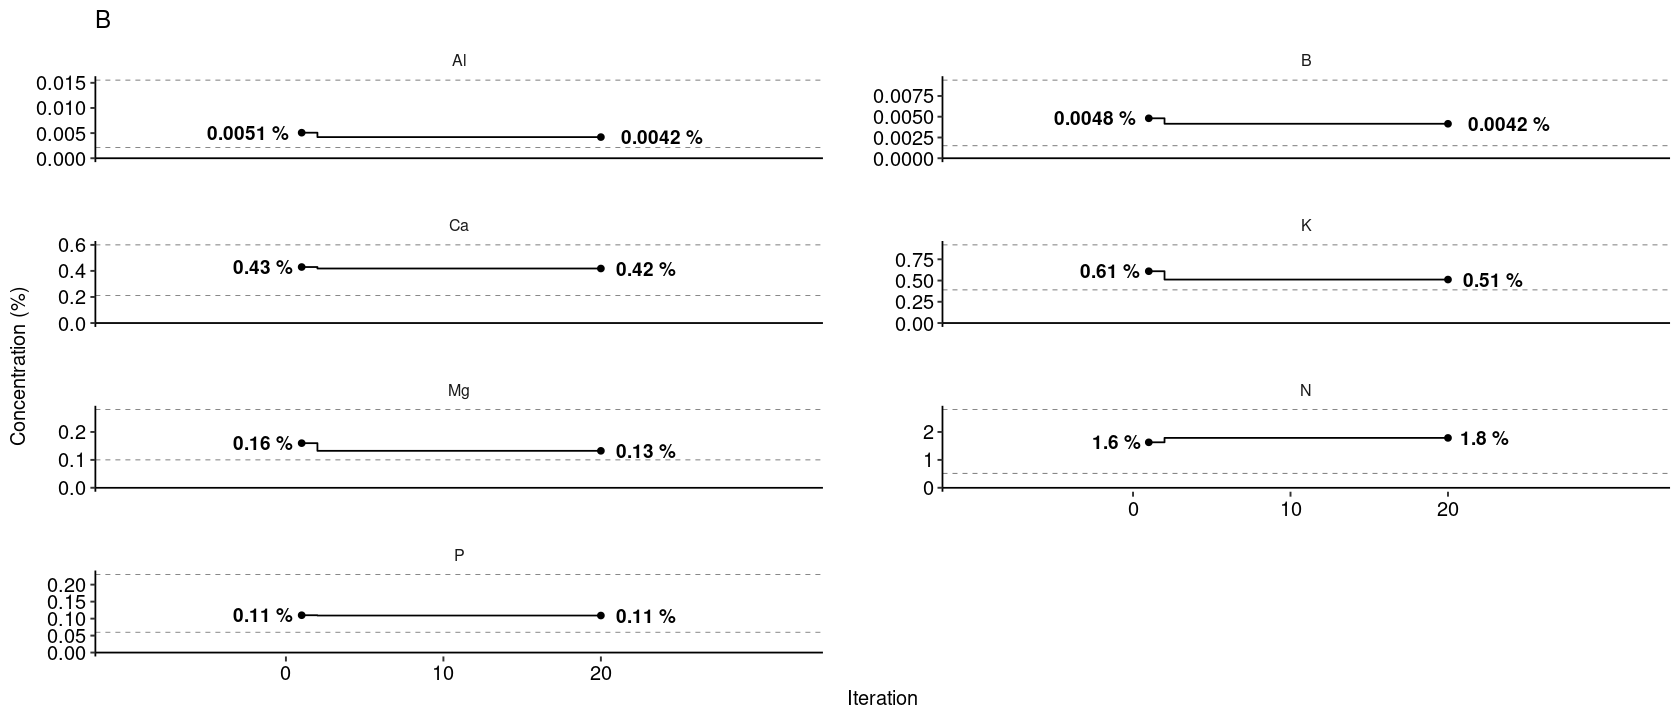

In [109]:
gg_iter %>%
  filter(str_detect(variables, "Leaf")) %>%
  mutate(variables = str_replace(variables, ".*_", "")) %>%
  filter(variables != "Fv") %>%
  ggplot(aes(x = iteration, y = values)) +
  facet_wrap(~variables, scales = "free_y", ncol = 2) +
  geom_hline(data = leaf_comp_range %>% filter(variables != "Fv"),
             aes(group = statistic, yintercept = value),
             colour = "gray30", linetype = 2, lwd = 0.2) +
  geom_step() +
  #geom_point(data = optim_comp, fill = "white", size = 2, pch = 23) +
  geom_point(data = gg_iter_extremes_leaf %>% filter(variables != "Fv")) +
  geom_text(data = gg_iter_extremes_leaf %>% filter(iteration == 1) %>% filter(variables != "Fv"), 
            aes(label = paste(signif(values, 2), units)), 
            hjust = 1.15, 
            fontface = "bold", 
            size = 4) +
  geom_text(data = gg_iter_extremes_leaf %>% filter(iteration == max_iter) %>% filter(variables != "Fv"), 
            aes(label = paste(signif(values, 2), units)), 
            hjust = -0.25, 
            fontface = "bold", 
            size = 4) +
  geom_hline(yintercept = 0) +
  expand_limits(x = c(-10, 32), y = 0) +
  scale_x_continuous(breaks = seq(0, max_iter, by = 10)) +
  labs(x = "Iteration", y = "Concentration (%)", title = "B") +
  #scale_y_continuous(breaks=0) +
  theme_pubr() +
  theme(
    panel.spacing = unit(10, 'mm'),
    panel.grid = element_blank(),
    panel.border = element_blank(),
    strip.background = element_blank(),
    panel.grid.major.x = element_blank(),
    axis.line.x = element_blank(),
    #text = element_text(family = "serif")
  ) +
  ggsave("images/convergence_leaf.png", height = 12, width = 8, dpi = 300)

Then edaphic balances and pH. In this case, the max of the data set are too high. So I need the max of iterations to draw an arrow.

In [110]:
soil_comp_range_it <- gg_iter %>%
  filter(str_detect(variables, "Soil") | variables == "pH") %>%
  mutate(variables = str_replace(variables, ".*_", "")) %>%
  group_by(variables) %>%
  summarise(value = max(values)) %>%
  mutate(statistic = "max_it") %>%
  #select(variables, statistic, value) %>%
  bind_rows(soil_comp_range)

`summarise()` ungrouping output (override with `.groups` argument)



In [111]:
soil_comp_range_it %>% filter(variables != "Fv", statistic != "min") %>% pivot_wider(id_cols = variables, names_from = statistic)

variables,max_it,max
<chr>,<dbl>,<dbl>
Ca,0.012200000,0.38660000
K,0.004807121,0.04290000
Mg,0.001800000,0.02830000
P,0.001700000,0.06420275
pH,4.611270505,6.37000000


The plot for soils needs to show values in mg/kg rather thant %. The following chunk alters the metric of extreme values to mg/kg if not done yet.

In [112]:
if (any(gg_iter_extremes_soil$units == "%")) {
    gg_iter_extremes_soil <- gg_iter_extremes_soil %>%
      mutate(variables = str_replace(variables, ".*_", ""),
             values = case_when(variables != "pH" ~ values * 10000, TRUE ~ values),
             units = case_when(variables != "pH" ~ "mg/kg", TRUE ~ "")) 
    soil_comp_range_it <- soil_comp_range_it %>%
      mutate(value = case_when(variables != "pH" ~ value * 10000, TRUE ~ value)) 
}

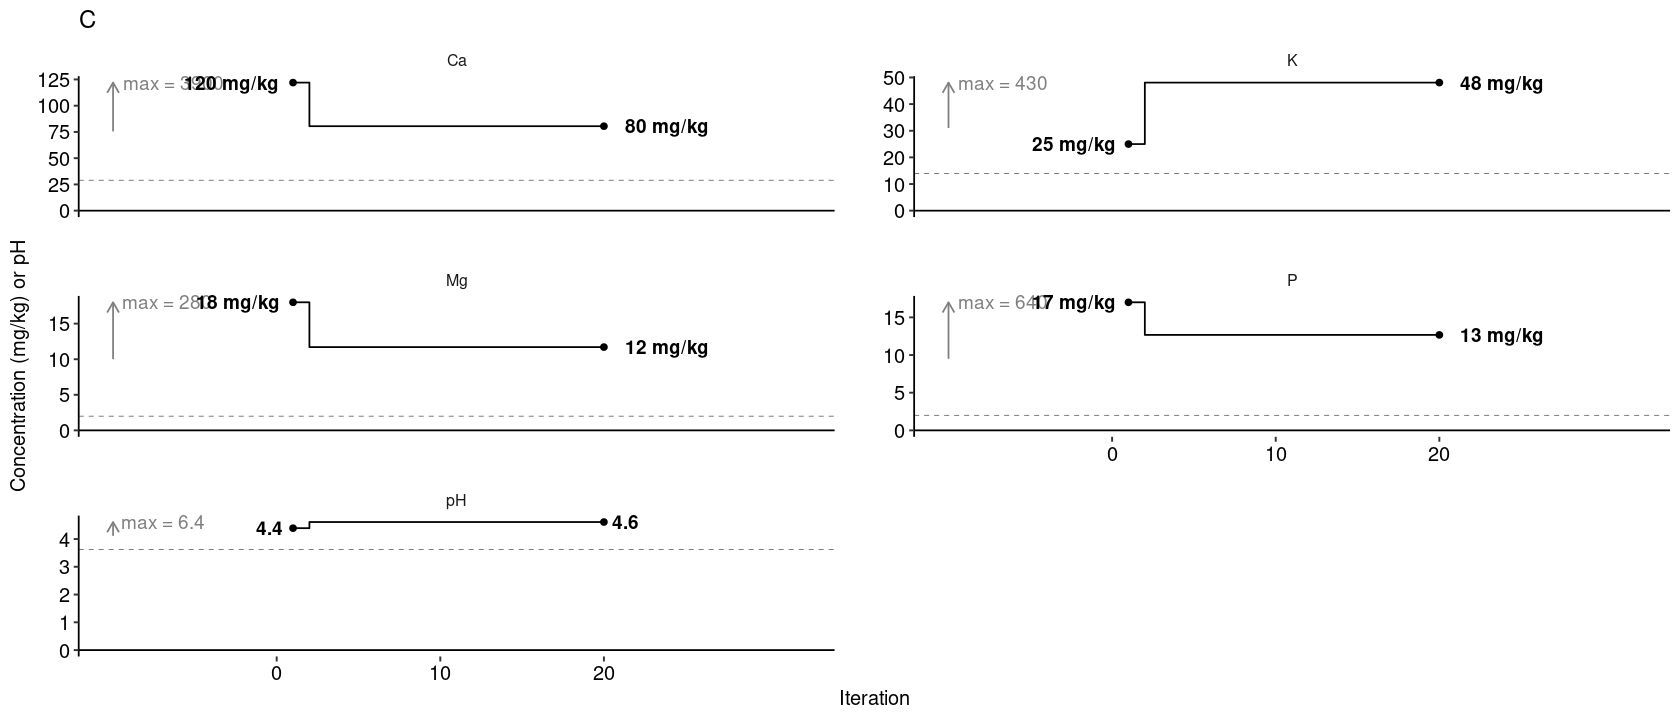

In [113]:
gg_iter %>%
  filter(str_detect(variables, "Soil") | variables == "pH") %>%
  mutate(variables = str_replace(variables, ".*_", ""),
         # alter % to mg/kg
         values = case_when(variables != "pH" ~ values * 10000, TRUE ~ values),
         units = case_when(variables != "pH" ~ "mg/kg", TRUE ~ "")) %>%
  filter(variables != "Fv") %>%
  ggplot(aes(x = iteration, y = values)) +
  facet_wrap(~variables, scales = "free_y", ncol = 2) +
  geom_hline(data = soil_comp_range_it %>% filter(variables != "Fv", statistic == "min"),
             aes(group = statistic, yintercept = value),
             colour = "gray30", linetype = 2, lwd = 0.2) +
  # Arrow and text
  geom_segment(data = soil_comp_range_it %>% filter(variables != "Fv", statistic != "max") %>% pivot_wider(id_cols = variables, names_from = statistic),
               aes(x = -10, y = min + (max_it-min)/2, xend = -10, yend = max_it),
               arrow = arrow(length = unit(0.25, "cm")),
               colour = "gray50") +
  geom_text(data = soil_comp_range_it %>% filter(variables != "Fv", statistic != "min") %>% pivot_wider(id_cols = variables, names_from = statistic),
            aes(x = -10, y = max_it, label = paste("max =", signif(max, 2))),
            hjust = -0.1, colour = "gray50", size = 4) +
  # / Arrow and text
  geom_step() +
  #geom_point(data = optim_comp, fill = "white", size = 2, pch = 23) +
  geom_point(data = gg_iter_extremes_soil %>% filter(variables != "Fv")) +
  geom_text(data = gg_iter_extremes_soil %>% filter(iteration == 1) %>% filter(variables != "Fv"), 
            aes(label = paste(signif(values, 2), units)), 
            hjust = 1.15,
            fontface = "bold", 
            size = 4) +
  geom_text(data = gg_iter_extremes_soil %>% filter(iteration == max_iter) %>% filter(variables != "Fv"), 
            aes(label = paste(signif(values, 2), units)), 
            hjust = -0.25, 
            fontface = "bold", 
            size = 4) +
  geom_hline(yintercept = 0) +
  expand_limits(x = c(-10, 32), y = 0) +
  scale_x_continuous(breaks = seq(0, max_iter, by = 10)) +
  labs(x = "Iteration", y = "Concentration (mg/kg) or pH", title = "C") +
  #scale_y_continuous(breaks=0) +
  theme_pubr() +
  theme(
    panel.spacing = unit(10, 'mm'),
    panel.grid = element_blank(),
    panel.border = element_blank(),
    strip.background = element_blank(),
    panel.grid.major.x = element_blank(),
    axis.line.x = element_blank(),
    #text = element_text(family = "serif")
  ) +
  ggsave("images/convergence_soil.png", height = 8, width = 8, dpi = 300)

Finally, dosages and yield.

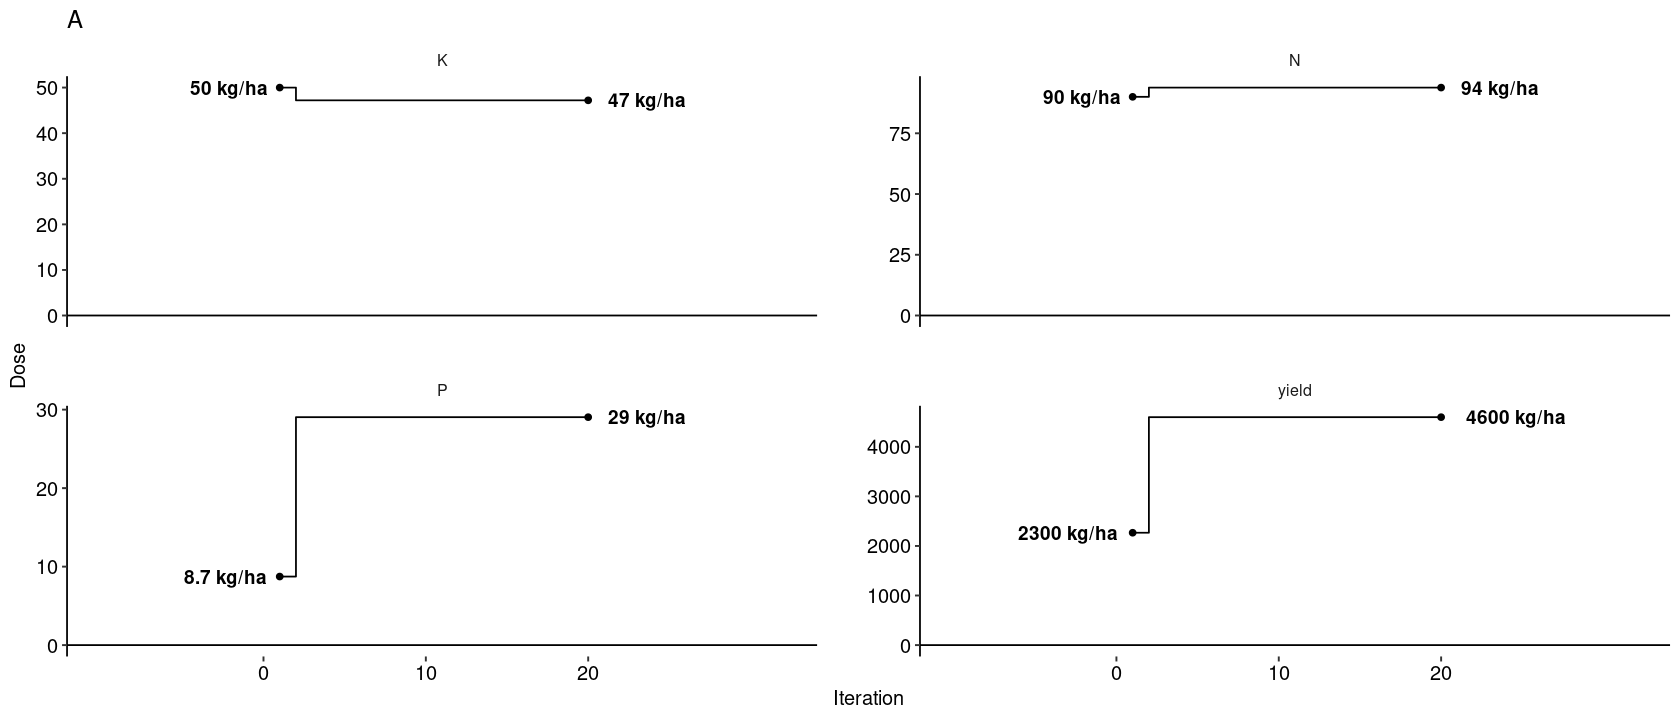

In [114]:
gg_iter %>%
  filter(str_detect(variables, "dose") | variables == "yield") %>%
  mutate(variables = str_replace(variables, "dose", "")) %>%
  ggplot(aes(x = iteration, y = values)) +
  facet_wrap(~variables, scales = "free_y", ncol = 2) +
  #geom_hline(data = soil_comp_range,
  #           aes(group = statistic, yintercept = value),
  #           colour = "gray30", linetype = 2, lwd = 0.2) +
  geom_step() +
  #geom_point(data = optim_comp, fill = "white", size = 2, pch = 23) +
  geom_point(data = gg_iter_extremes_dose) +
  geom_text(data = gg_iter_extremes_dose %>% filter(iteration == 1), 
            aes(label = paste(signif(values, 2), units)), 
            hjust = 1.15, 
            fontface = "bold", 
            size = 4) +
  geom_text(data = gg_iter_extremes_dose %>% filter(iteration == max_iter), 
            aes(label = paste(signif(values, 2), units)), 
            hjust = -0.25, 
            fontface = "bold", 
            size = 4) +
  geom_hline(yintercept = 0) +
  expand_limits(x = c(-10, 32), y = 0) +
  scale_x_continuous(breaks = seq(0, max_iter, by = 10)) +
  labs(x = "Iteration", y = "Dose", title = "A") +
  #scale_y_continuous(breaks=0) +
  theme_pubr() +
  theme(
    panel.spacing = unit(10, 'mm'),
    panel.grid = element_blank(),
    panel.border = element_blank(),
    strip.background = element_blank(),
    panel.grid.major.x = element_blank(),
    axis.line.x = element_blank(),
    #text = element_text(family = "serif")
  ) +
  ggsave("images/convergence_dose.png", height = 5, width = 8, dpi = 300)

Aitchison distance between observed and target.

In [115]:
init_leaf <- iterations_managed_unsc[1, str_detect(colnames(iterations_managed_unsc), "Leaf")]
final_leaf <- iterations_managed_unsc[max_iter, str_detect(colnames(iterations_managed_unsc), "Leaf")]

init_soil <- iterations_managed_unsc[1, str_detect(colnames(iterations_managed_unsc), "Soil")]
final_soil <- iterations_managed_unsc[max_iter, str_detect(colnames(iterations_managed_unsc), "Soil")]

In [116]:
print(
    paste(
        "Leaf AD between the observation and the target (using the Markov chain)",
        sqrt(sum((init_leaf - final_leaf) ^ 2))
    )
)

print(
    paste(
        "Soil AD between the observation and the target (using the Markov chain)",
        sqrt(sum((init_soil - final_soil) ^ 2))
    )
)



[1] "Leaf AD between the observation and the target (using the Markov chain) 0.285490846500497"
[1] "Soil AD between the observation and the target (using the Markov chain) 0.908151036133705"


Visualisation of the observed/target ratio for the path algorithm.

In [117]:
gg_ratio_data <- gg_iter_extremes %>%
  pivot_wider(names_from = iteration,
              values_from = values) %>%
  mutate(category = case_when(
           str_detect(variables, "dose") ~ "Dose",
           str_detect(variables, "Leaf") ~ "Leaf",
           str_detect(variables, "Soil") | variables == "pH"  ~ "Soil",
           variables == "yield" ~ "Yield")) %>%
  mutate(ratio = `1` / `20`) %>% 
  filter(!category %in% c("Yield", "Dose")) %>% 
  mutate(variables = str_replace(variables, "_", " "),
         variables = fct_reorder(variables, ratio))

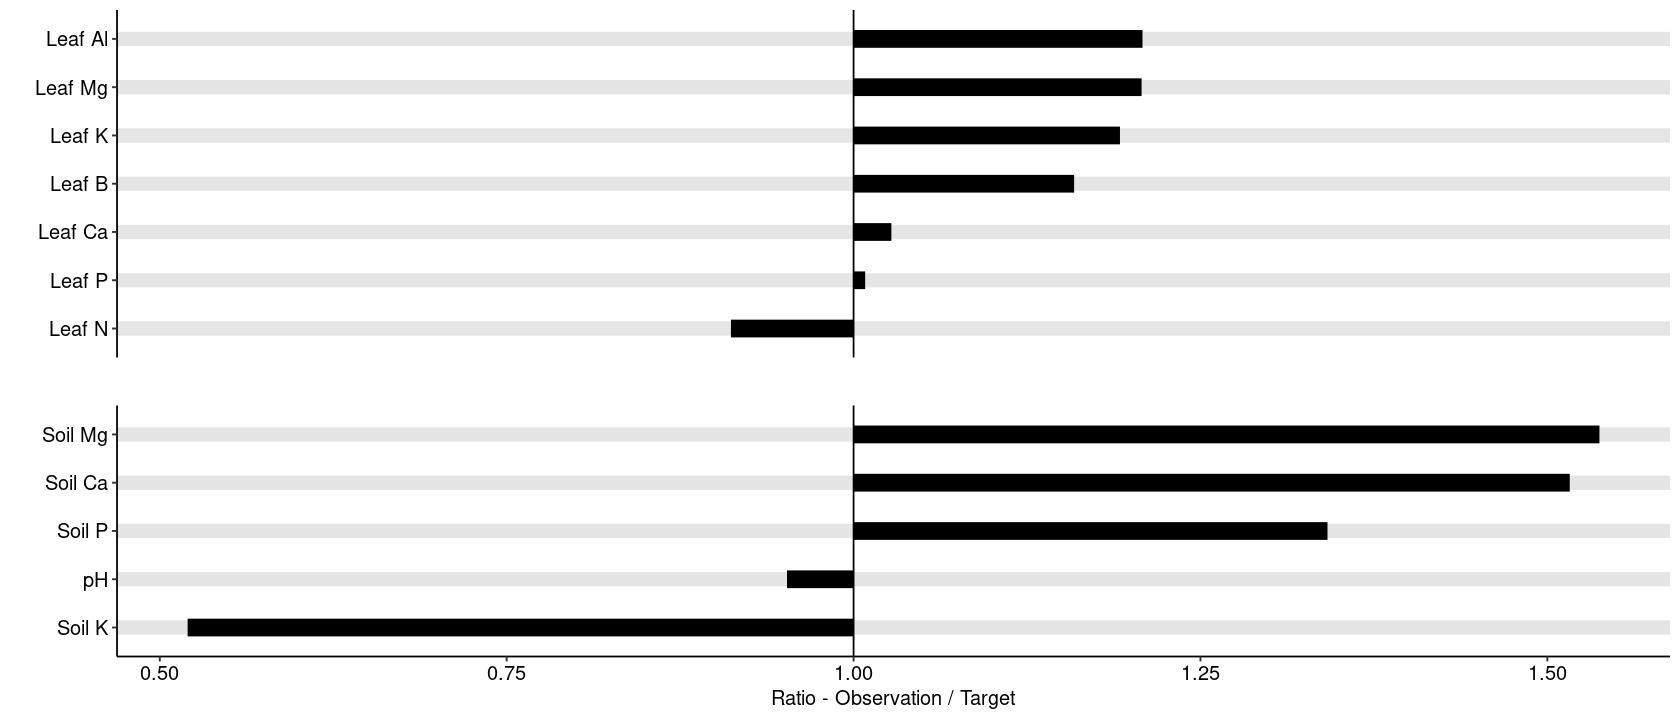

In [118]:
gg_ratio_data %>% 
  filter(!str_detect(variables, "Fv")) %>%
  ggplot(aes(y = ratio, x = variables)) +
  facet_grid(category~., scales = "free", space="free") +
  labs(x = "", y = "Ratio - Observation / Target") +
  #geom_col(fill = "grey70") +
  geom_segment(aes(xend = variables), y = 0, yend = 3, size = 4, colour = "grey90") +
  geom_segment(aes(xend = variables), yend = 1, size = 5) +
  geom_hline(yintercept = 1) +
  #expand_limits(y = 0) +
  coord_flip() +
  theme_pubr() +
  theme(strip.background = element_blank(),
        strip.text.y = element_blank(),
        panel.spacing = unit(2, "lines")) +
  ggsave("images/ratio.png", height = 3, width = 6, dpi = 300)

# Overview of optimal ionomes

The same code is applied to all observations in an external file to obtain overall statistics of targets.

The code takes a lot of time to run, so the results as been savec in a RData file and loaded here.

In [119]:
load("output/opt.RData")

Back transforming the data...

`summarise()` ungrouping output (override with `.groups` argument)



variable,min,q25,median,q75,max
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
N,5.200000e-01,1.850459269,1.959742628,2.099299311,2.94510877
P,6.000000e-02,0.124836910,0.140879031,0.153400174,0.26612526
K,3.369207e-01,0.550284464,0.634399930,0.679896117,1.08197439
Ca,2.336484e-01,0.352939668,0.403811332,0.459167929,0.71176688
Mg,9.487525e-02,0.149657948,0.164904070,0.181784078,0.31154307
B,9.383554e-04,0.002691116,0.004014545,0.004667034,0.01779815
Al,1.596101e-03,0.004247167,0.004865344,0.006153189,0.01848841
Fv,9.527067e+01,96.507429412,96.680176042,96.841664316,98.13235000


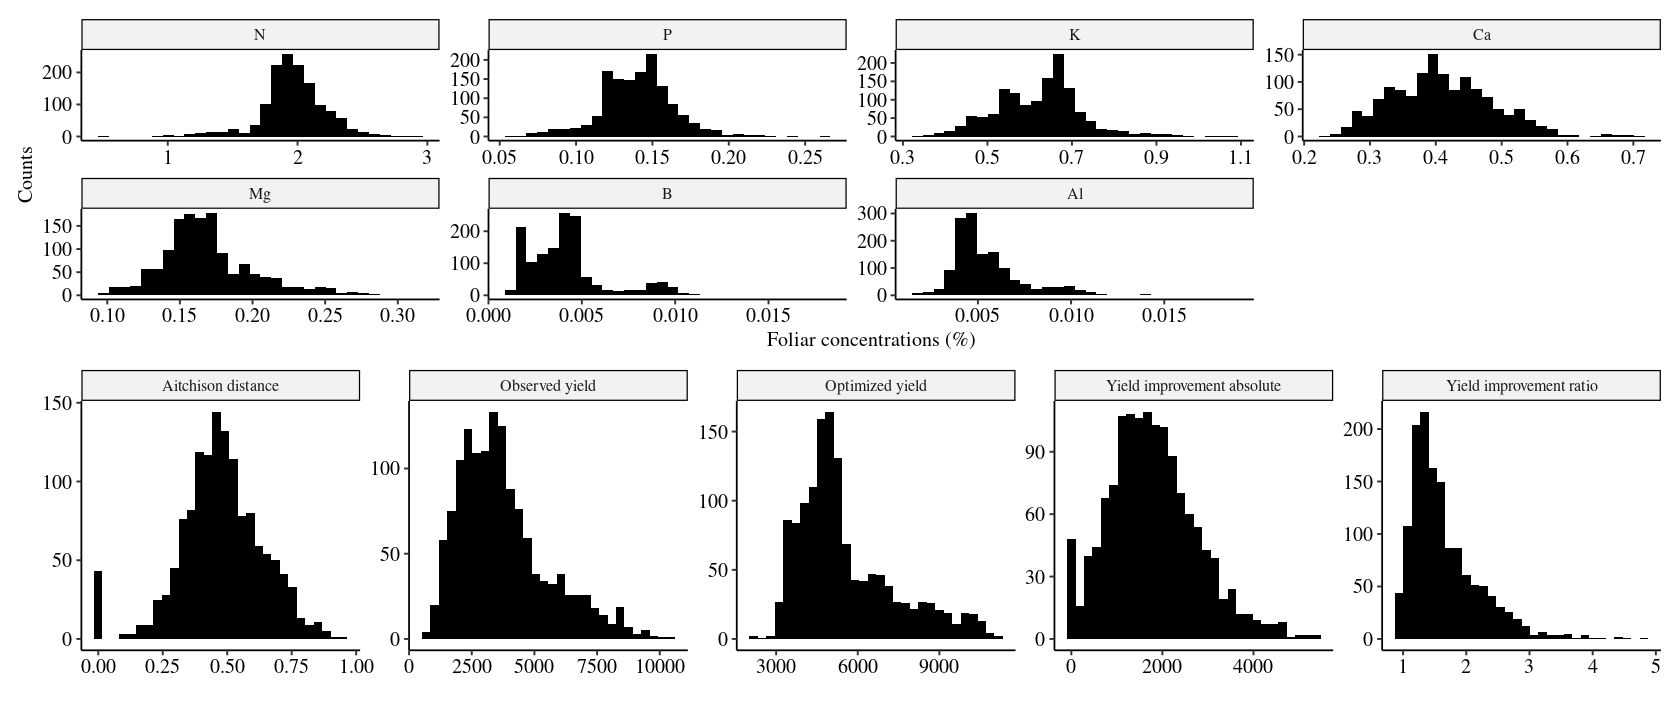

In [120]:
opt_comp <- ilrInv(opt_bal, V = gsi.buildilrBase(t(sbp_leaf))) %>% 
  data.frame() %>% 
  mutate(id = 1:nrow(opt_bal)) %>% 
  pivot_longer(cols = -c(id),
               names_to = "variable", values_to = "value") %>% 
  mutate(value = value * 100,
         variable = factor(variable, levels = c("N", "P", "K", "Ca", "Mg", "B", "Al", "Fv")))

opt_output <- tibble(id = 1:nrow(opt_bal),
                     `Observed yield` = opt_yield[, 1],
                     `Optimized yield` = opt_yield[, 2],
                     `Aitchison distance` = ait_dist) %>% 
  mutate(`Yield improvement ratio` = `Optimized yield` / `Observed yield`,
         `Yield improvement absolute` = `Optimized yield` - `Observed yield`,) %>%
  pivot_longer(cols = -c(id),
               names_to = "variable", values_to = "value")

opt_comp_gg <- opt_comp %>% 
  filter(variable != "Fv") %>% 
  ggplot(aes(x = value)) +
  facet_wrap(~variable, nrow = 2, scales = "free") +
  geom_histogram(bins = 30, fill = "black") +
  labs(x = "Foliar concentrations (%)", y = "Counts") +
  theme_pubr() +
  theme(text = element_text(family = "serif"))

opt_out_gg <- opt_output %>% 
  ggplot(aes(x = value)) +
  facet_wrap(~variable, nrow = 1, scales = "free") +
  geom_histogram(bins = 30, fill = "black") +
  labs(x = "", y = "") +
  theme_pubr() +
  theme(text = element_text(family = "serif"))

opt_comp_gg / opt_out_gg
ggsave("images/opt-distr.png", height = 10, width = 10, dpi = 300)

opt_comp %>% 
  group_by(variable) %>% 
  summarise(min = min(value),
            q25 = quantile(value, prob = 0.25),
            median = median(value),
            q75 = quantile(value, prob = 0.75),
            max = max(value))

The proportion of Aitchison distances shorter than 0.43.

In [121]:
quantInv <- function(distr, value) ecdf(distr)(value) # thanks https://stackoverflow.com/questions/9123800/how-do-i-calculate-the-probability-for-a-given-quantile-in-r
opt_output %>%
  filter(variable == "Aitchison distance") %>%
  pull(value) %>%
  quantInv(., 0.43)

[1] 0.375

The proportion of yields inferior to 5000.

In [122]:
opt_output %>%
  filter(variable == "Optimized yield") %>%
  pull(value) %>%
  quantInv(., 5000)

[1] 0.4776012

## Compare optimal distributions to the literature

In [123]:
nutrients_litt_source <- read_csv("data/literature-standards.csv")
nutrients_litt <- nutrients_litt_source %>%
  pivot_longer(cols = -c(Author, MinMax)) %>%
  pivot_wider(names_from = MinMax, values_from = value)

Parsed with column specification:
cols(
  Author = col_character(),
  MinMax = col_character(),
  N = col_double(),
  P = col_double(),
  K = col_double(),
  Ca = col_double(),
  Mg = col_double(),
  B = col_double(),
  Cu = col_double(),
  Zn = col_double(),
  Mn = col_double(),
  Fe = col_double(),
  Al = col_double()
)



### N

Warning message:
“Removed 2 rows containing missing values (geom_bar).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”


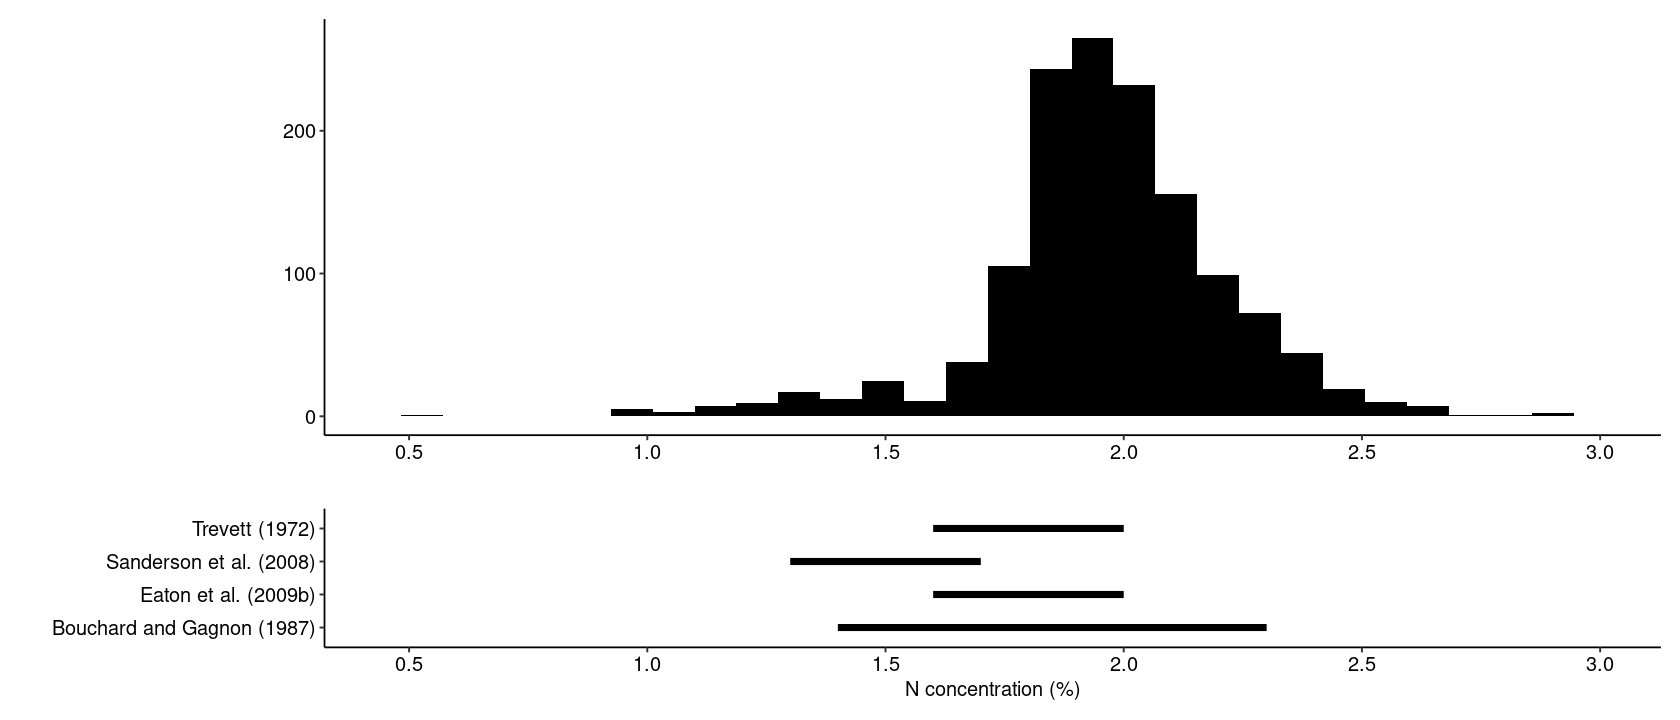

In [124]:
gg_scale <- scale_x_continuous(breaks = seq(0, 3, by = 0.5), lim = c(0.45, 3))

gg_nlitt <- nutrients_litt %>%
  filter(name == "N") %>%
  ggplot(aes(x = Minimum, y = Author)) +
  geom_segment(aes(xend = Maximum, yend = Author), lwd = 2) +
  labs(x = "N concentration (%)", y = "") +
  gg_scale +
  theme_pubr()

gg_ndistr <- opt_comp %>% 
  filter(variable == "N") %>% 
  ggplot(aes(x = value)) +
  geom_histogram(fill = "black", bins = 30) +
  labs(x = "", y = "") +
  gg_scale +
  theme_pubr()

gg_n <- gg_ndistr / gg_nlitt + plot_layout(heights = c(3, 1))
gg_n
ggsave("images/distr_n.png", height = 5, width = 10, dpi = 300)

### P

Warning message:
“Removed 2 rows containing missing values (geom_bar).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”


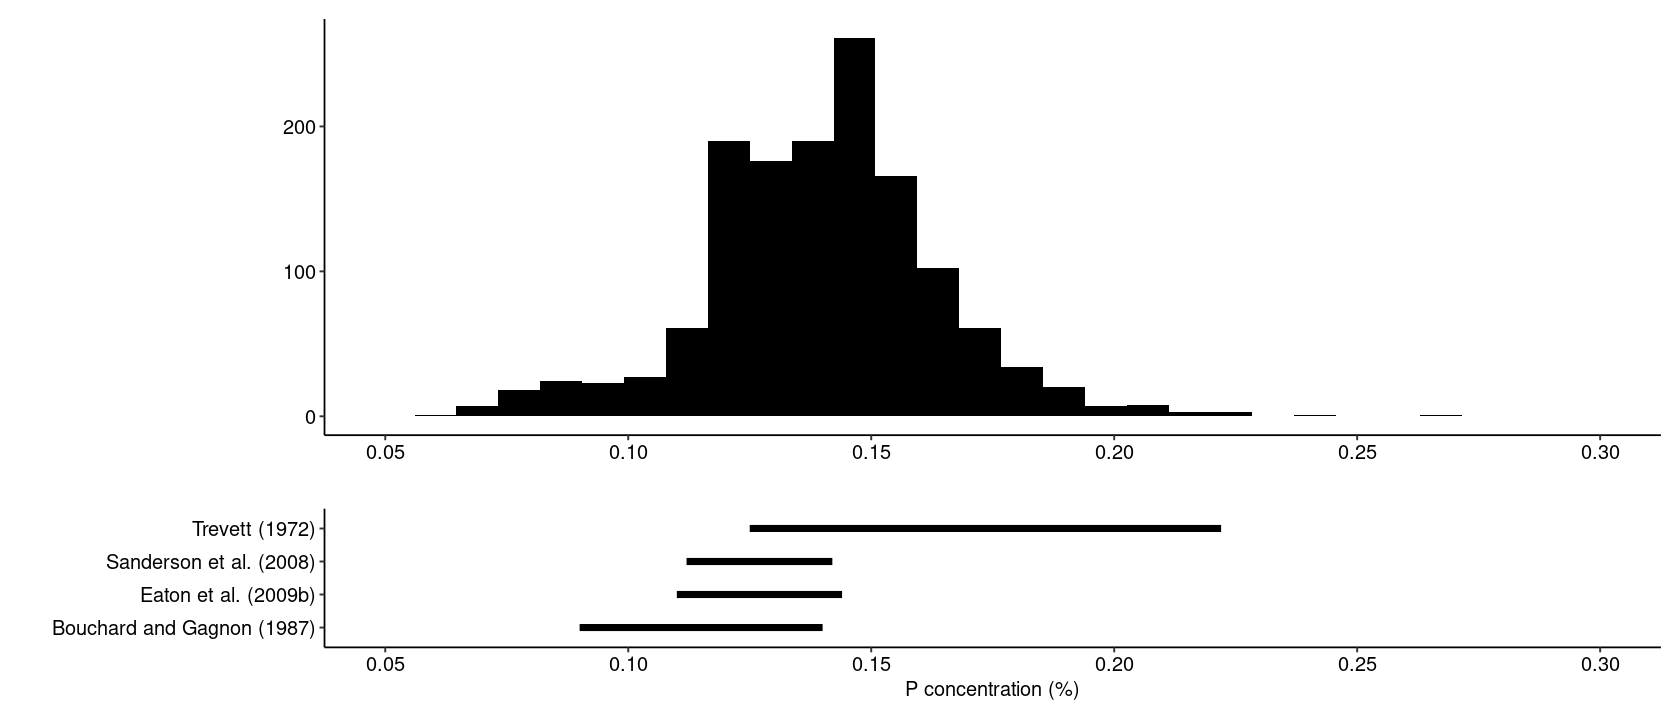

In [125]:
gg_scale <- scale_x_continuous(breaks = seq(0, 0.3, by = 0.05), lim = c(0.05, 0.3))

gg_plitt <- nutrients_litt %>%
  filter(name == "P") %>%
  ggplot(aes(x = Minimum, y = Author)) +
  geom_segment(aes(xend = Maximum, yend = Author), lwd = 2) +
  labs(x = "P concentration (%)", y = "") +
  gg_scale +
  theme_pubr()

gg_pdistr <- opt_comp %>% 
  filter(variable == "P") %>% 
  ggplot(aes(x = value)) +
  geom_histogram(fill = "black", bins = 30) +
  labs(x = "", y = "") +
  gg_scale +
  theme_pubr()

gg_p <- gg_pdistr / gg_plitt + plot_layout(heights = c(3, 1))
gg_p
ggsave("images/distr_p.png", height = 5, width = 10, dpi = 300)

# K

Warning message:
“Removed 2 rows containing missing values (geom_bar).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”


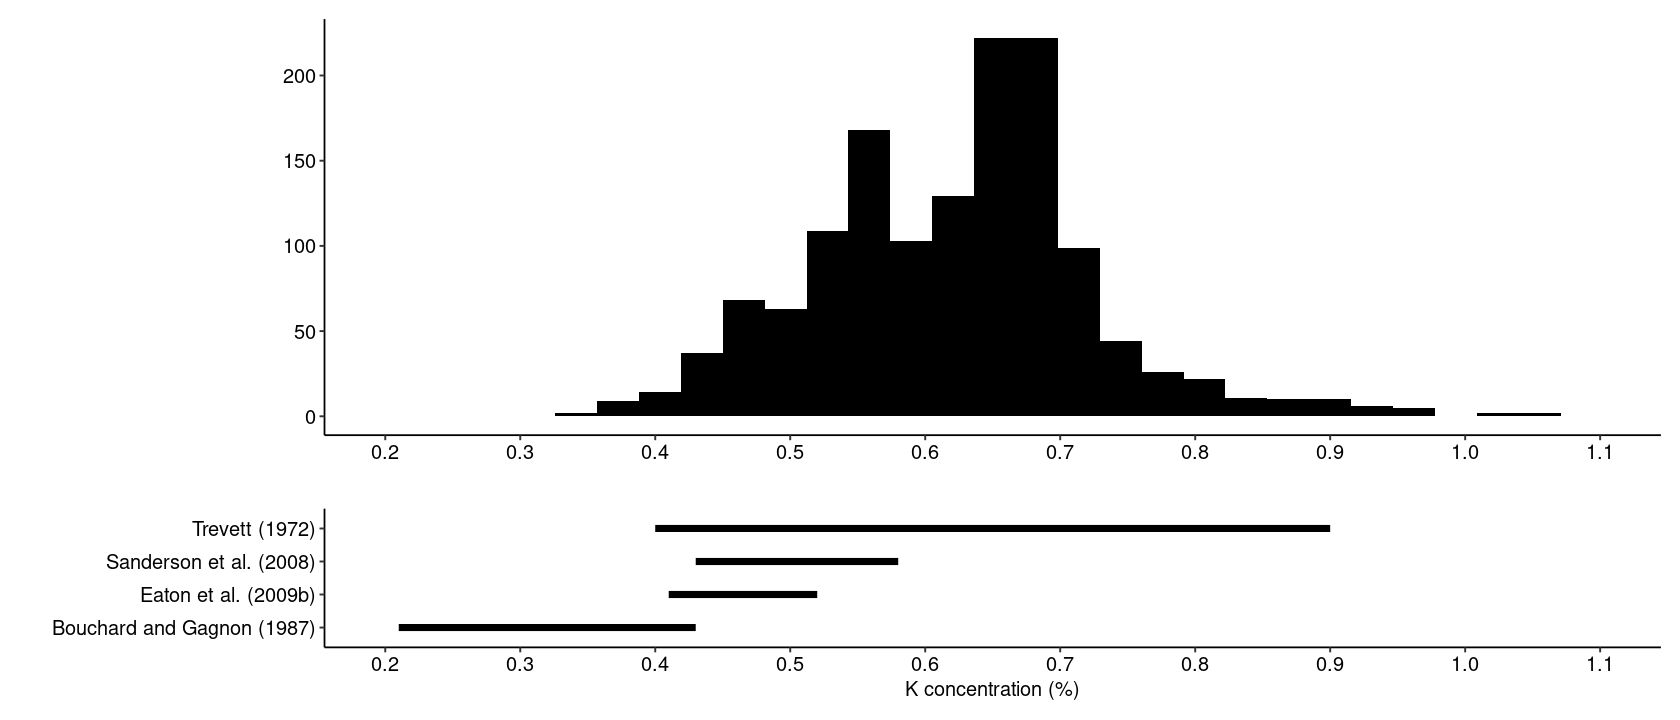

In [126]:
ggscale <- scale_x_continuous(breaks = seq(0, 2, by = 0.1), lim = c(0.2, 1.1))

gg_klitt <- nutrients_litt %>%
  filter(name == "K") %>%
  ggplot(aes(x = Minimum, y = Author)) +
  geom_segment(aes(xend = Maximum, yend = Author), lwd = 2) +
  labs(x = "K concentration (%)", y = "") +
  ggscale +
  theme_pubr()

gg_kdistr <- opt_comp %>% 
  filter(variable == "K") %>% 
  ggplot(aes(x = value)) +
  geom_histogram(fill = "black", bins = 30) +
  labs(x = "", y = "") +
  ggscale +
  theme_pubr()

gg_k <- gg_kdistr / gg_klitt + plot_layout(heights = c(3, 1))
gg_k
ggsave("images/distr_k.png", height = 5, width = 10, dpi = 300)

# Ca

Warning message:
“Removed 2 rows containing missing values (geom_bar).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”


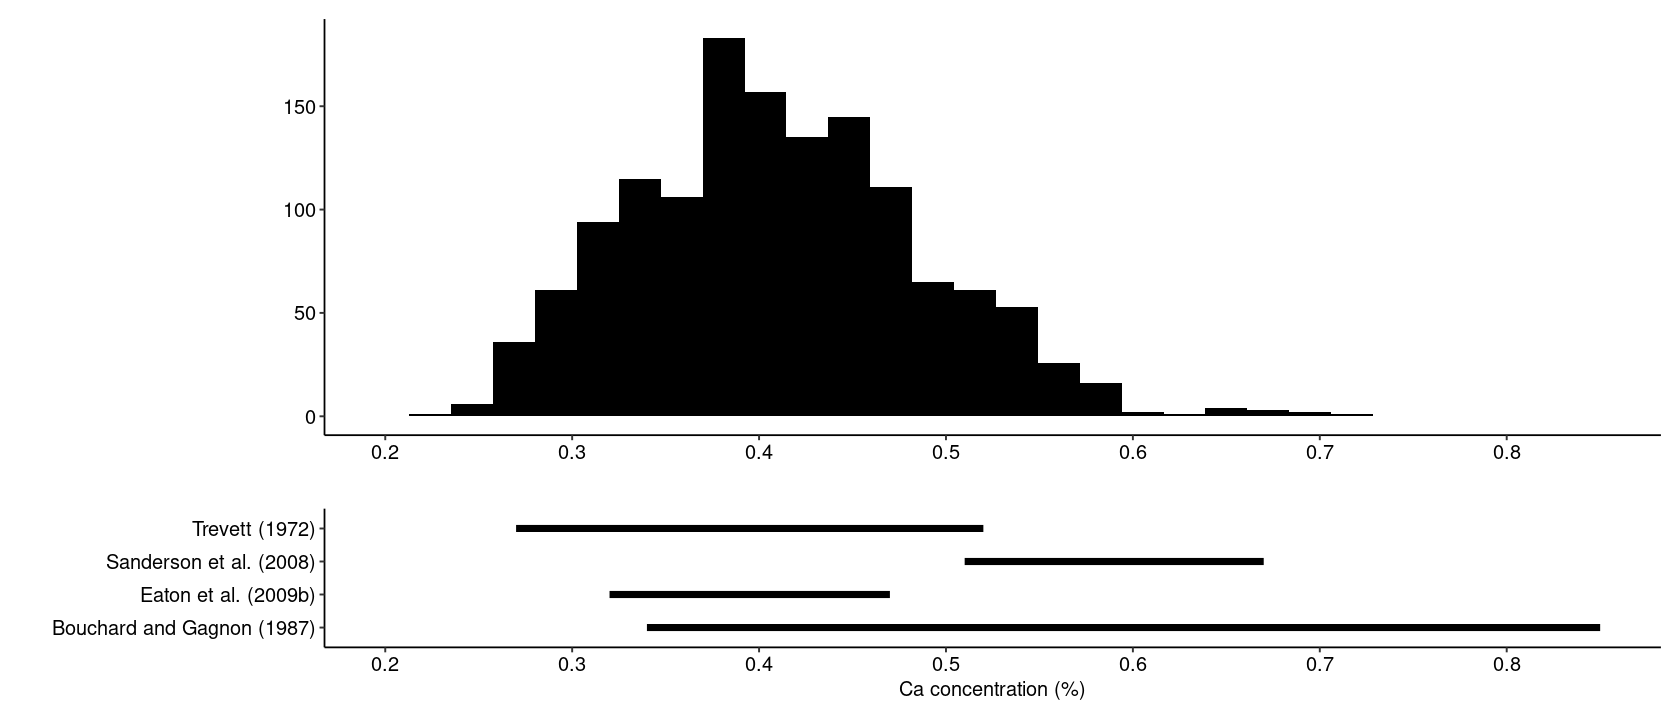

In [127]:
gg_scale <- scale_x_continuous(breaks = seq(0, 1, by = 0.1), lim = c(0.2, 0.85))

gg_calitt <- nutrients_litt %>%
  filter(name == "Ca") %>%
  ggplot(aes(x = Minimum, y = Author)) +
  geom_segment(aes(xend = Maximum, yend = Author), lwd = 2) +
  labs(x = "Ca concentration (%)", y = "") +
  gg_scale +
  theme_pubr()

gg_cadistr <- opt_comp %>% 
  filter(variable == "Ca") %>% 
  ggplot(aes(x = value)) +
  geom_histogram(fill = "black", bins = 30) +
  labs(x = "", y = "") +
  gg_scale +
  theme_pubr()

gg_ca <- gg_cadistr / gg_calitt + plot_layout(heights = c(3, 1))
gg_ca
ggsave("images/distr_ca.png", height = 5, width = 10, dpi = 300)

# Mg

Warning message:
“Removed 2 rows containing missing values (geom_bar).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”


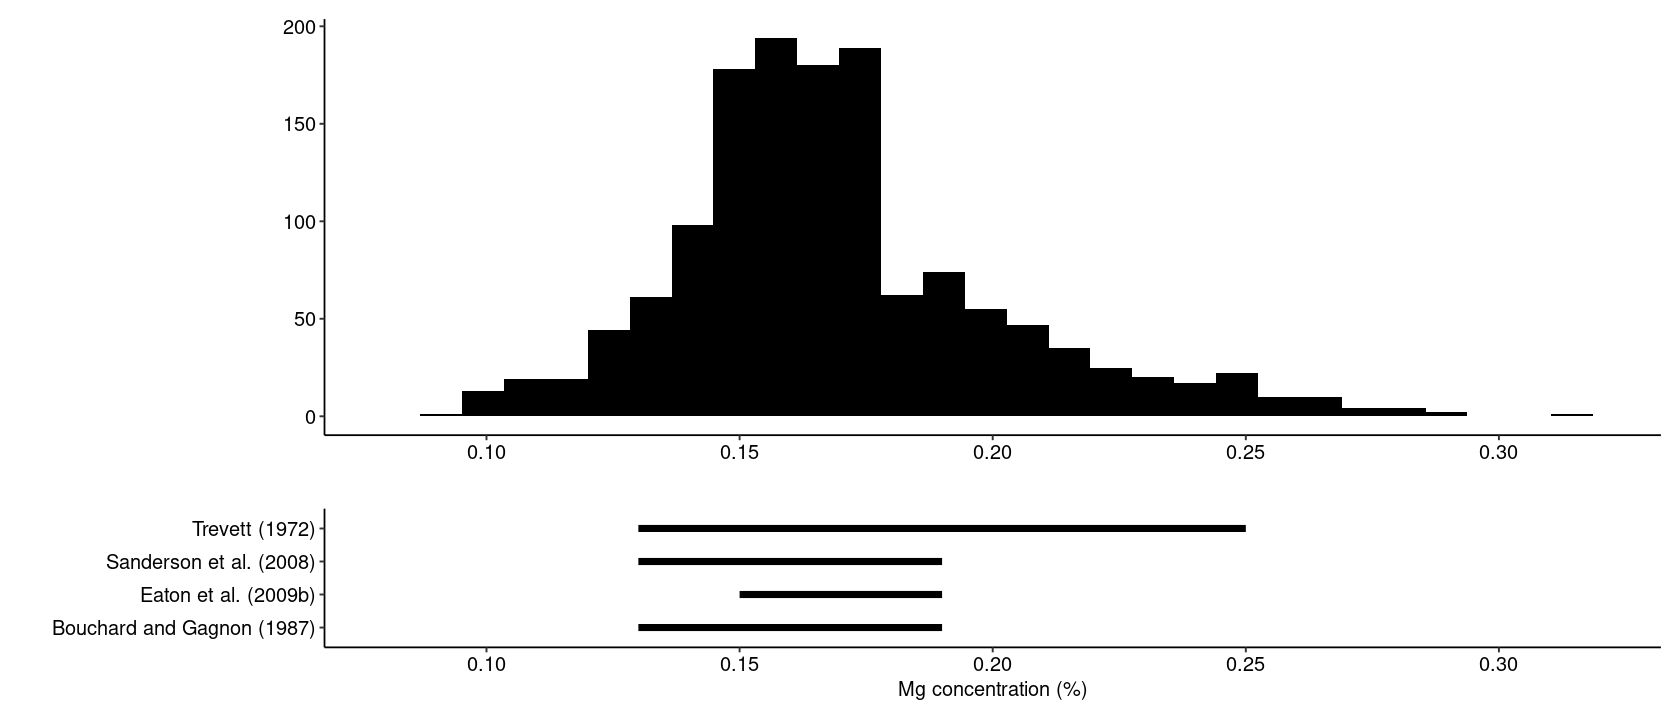

In [128]:
gg_scale <- scale_x_continuous(breaks = seq(0.05, 0.35, by = 0.05), lim = c(0.08, 0.32))

gg_mglitt <- nutrients_litt %>%
  filter(name == "Mg") %>%
  ggplot(aes(x = Minimum, y = Author)) +
  geom_segment(aes(xend = Maximum, yend = Author), lwd = 2) +
  labs(x = "Mg concentration (%)", y = "") +
  gg_scale +
  theme_pubr()

gg_mgdistr <- opt_comp %>% 
  filter(variable == "Mg") %>% 
  ggplot(aes(x = value)) +
  geom_histogram(fill = "black", bins = 30) +
  labs(x = "", y = "") +
  gg_scale +
  theme_pubr()

gg_mg <- gg_mgdistr / gg_mglitt + plot_layout(heights = c(3, 1))
gg_mg
ggsave("images/distr_mg.png", height = 5, width = 10, dpi = 300)

# B

Warning message:
“Removed 1 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”
Warning message:
“Removed 1 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”


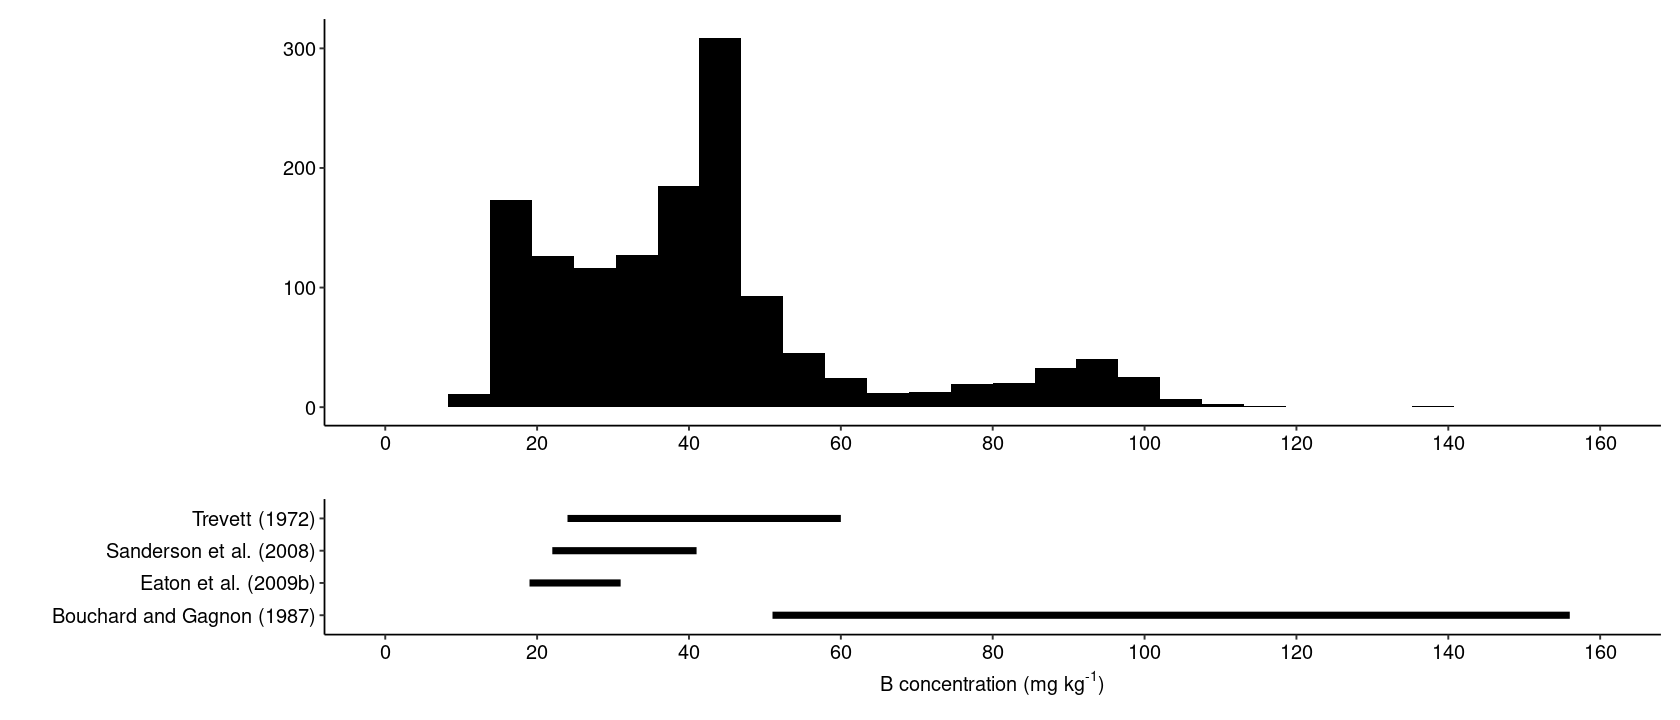

In [129]:
gg_scale <- scale_x_continuous(breaks = seq(0, 180, by = 20), lim = c(0, 160))

gg_blitt <- nutrients_litt %>%
  filter(name == "B") %>%
  ggplot(aes(x = Minimum, y = Author)) +
  geom_segment(aes(xend = Maximum, yend = Author), lwd = 2) +
  labs(x = expression("B concentration (mg kg"^"-1"*")"), y = "") +
  gg_scale +
  theme_pubr()

gg_bdistr <- opt_comp %>% 
  filter(variable == "B") %>% 
  ggplot(aes(x = value * 10000)) +
  geom_histogram(fill = "black", bins = 30) +
  labs(x = "", y = "") +
  gg_scale +
  theme_pubr()

gg_b <- gg_bdistr / gg_blitt + plot_layout(heights = c(3, 1))
gg_b
ggsave("images/distr_b.png", height = 5, width = 10, dpi = 300)

# Al

Warning message:
“Removed 2 rows containing missing values (geom_bar).”
Warning message:
“Removed 3 rows containing missing values (geom_segment).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”
Warning message:
“Removed 3 rows containing missing values (geom_segment).”


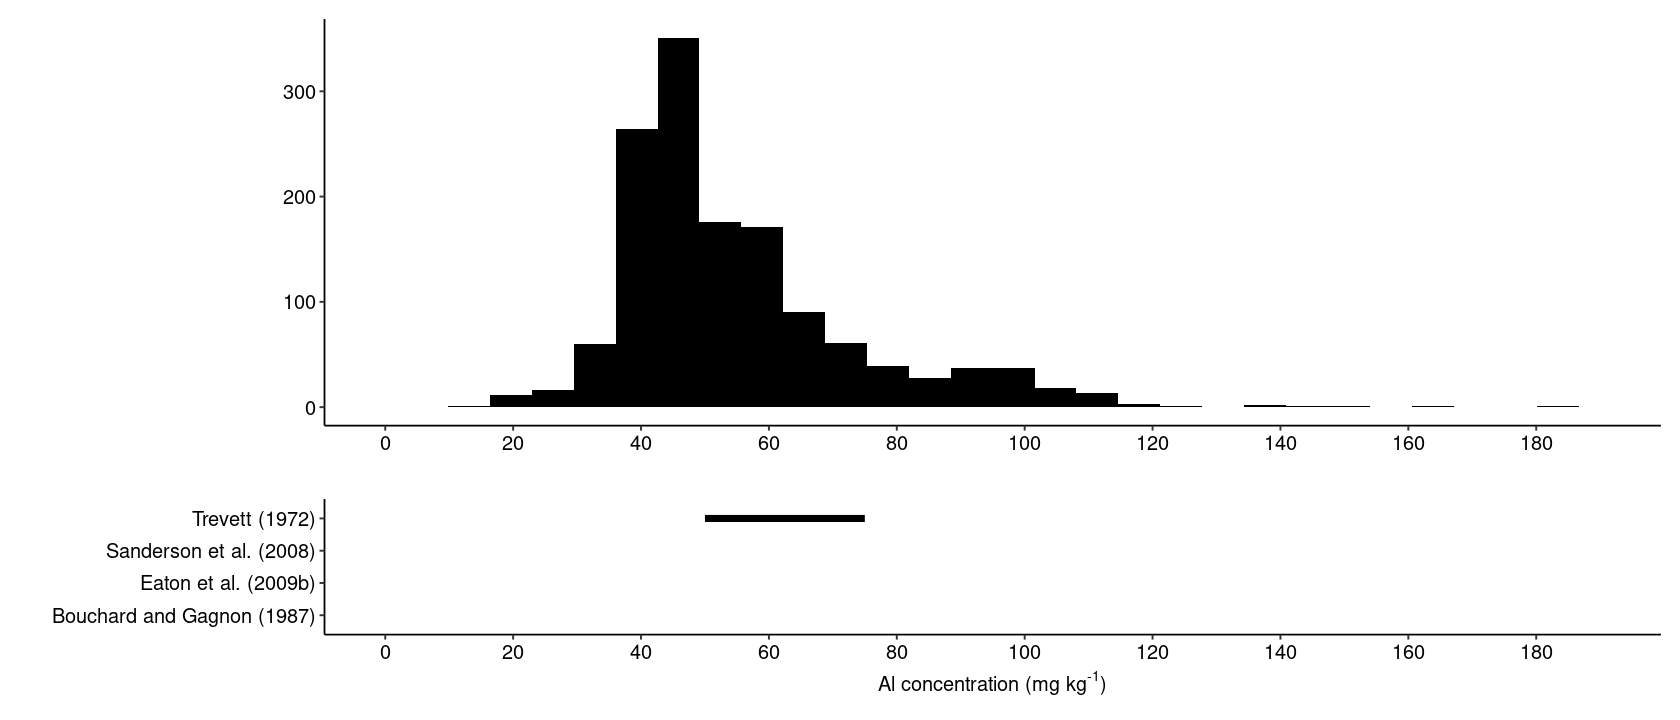

In [130]:
gg_scale <- scale_x_continuous(breaks = seq(0, 200, by = 20), lim = c(0, 190))

gg_allitt <- nutrients_litt %>%
  filter(name == "Al") %>%
  ggplot(aes(x = Minimum, y = Author)) +
  geom_segment(aes(xend = Maximum, yend = Author), lwd = 2) +
  labs(x = expression("Al concentration (mg kg"^"-1"*")"), y = "") +
  gg_scale +
  theme_pubr()

gg_aldistr <- opt_comp %>% 
  filter(variable == "Al") %>% 
  ggplot(aes(x = value * 10000)) +
  geom_histogram(fill = "black", bins = 30) +
  labs(x = "", y = "") +
  gg_scale +
  theme_pubr()

gg_al <- gg_aldistr / gg_allitt + plot_layout(heights = c(3, 1))
gg_al
ggsave("images/distr_al.png", height = 5, width = 10, dpi = 300)

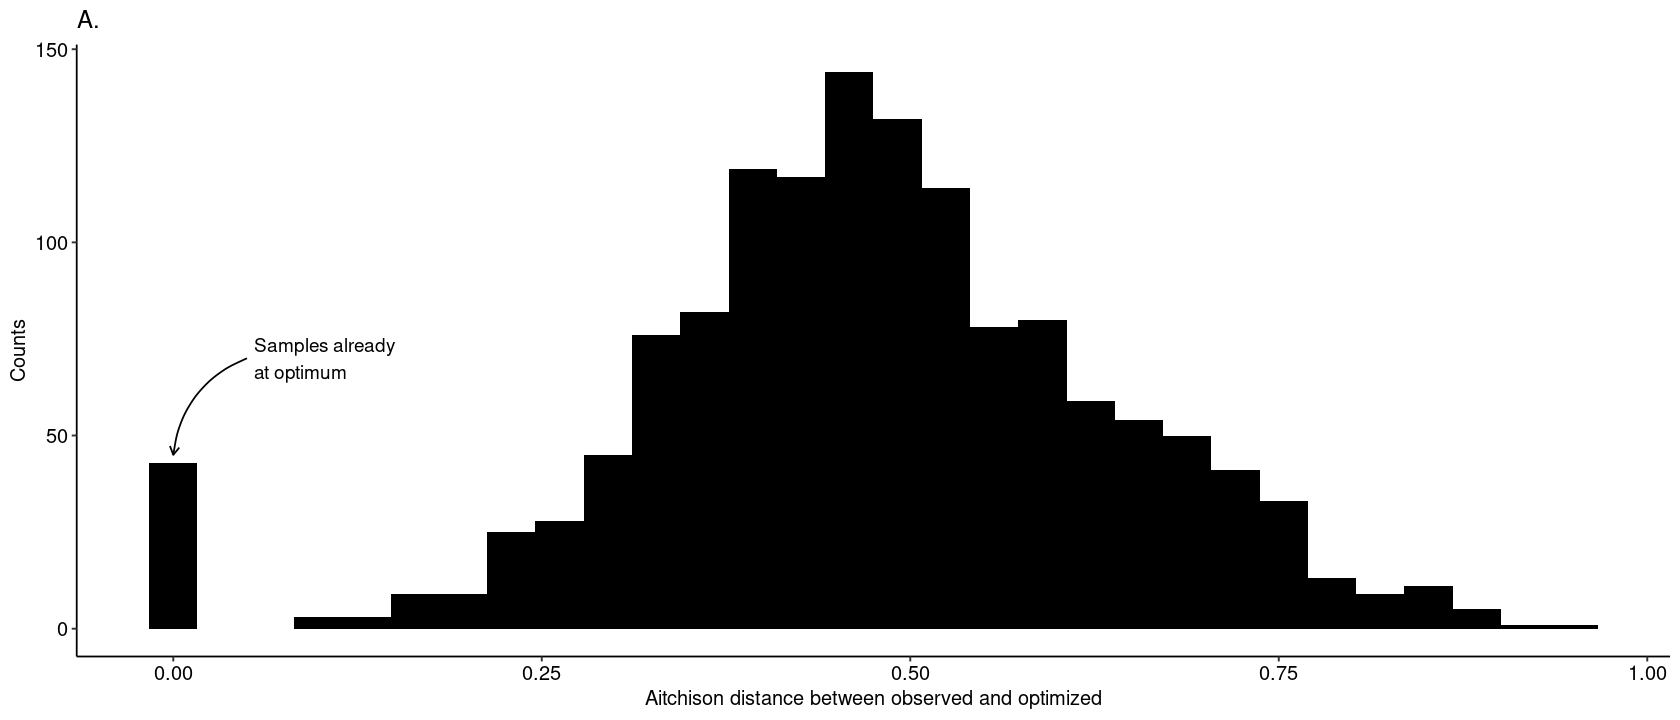

In [131]:
opt_output %>%
  filter(variable == "Aitchison distance") %>%
  ggplot(aes(x = value)) +
  geom_histogram(fill = "black", bins = 30) +
  annotate(
    geom = "curve", x = 0.05, y = 70, xend = 0, yend = 45, 
    curvature = .3, arrow = arrow(length = unit(2, "mm"))
  ) +
  annotate(geom = "text", x = 0.055, y = 70, label = "Samples already\nat optimum", hjust = "left", size = 4) +
  labs(title = "A.", x = "Aitchison distance between observed and optimized", y = "Counts") +
  theme_pubr() +
  ggsave("images/distr_aitdist.png", height = 5, width = 8, dpi = 300)

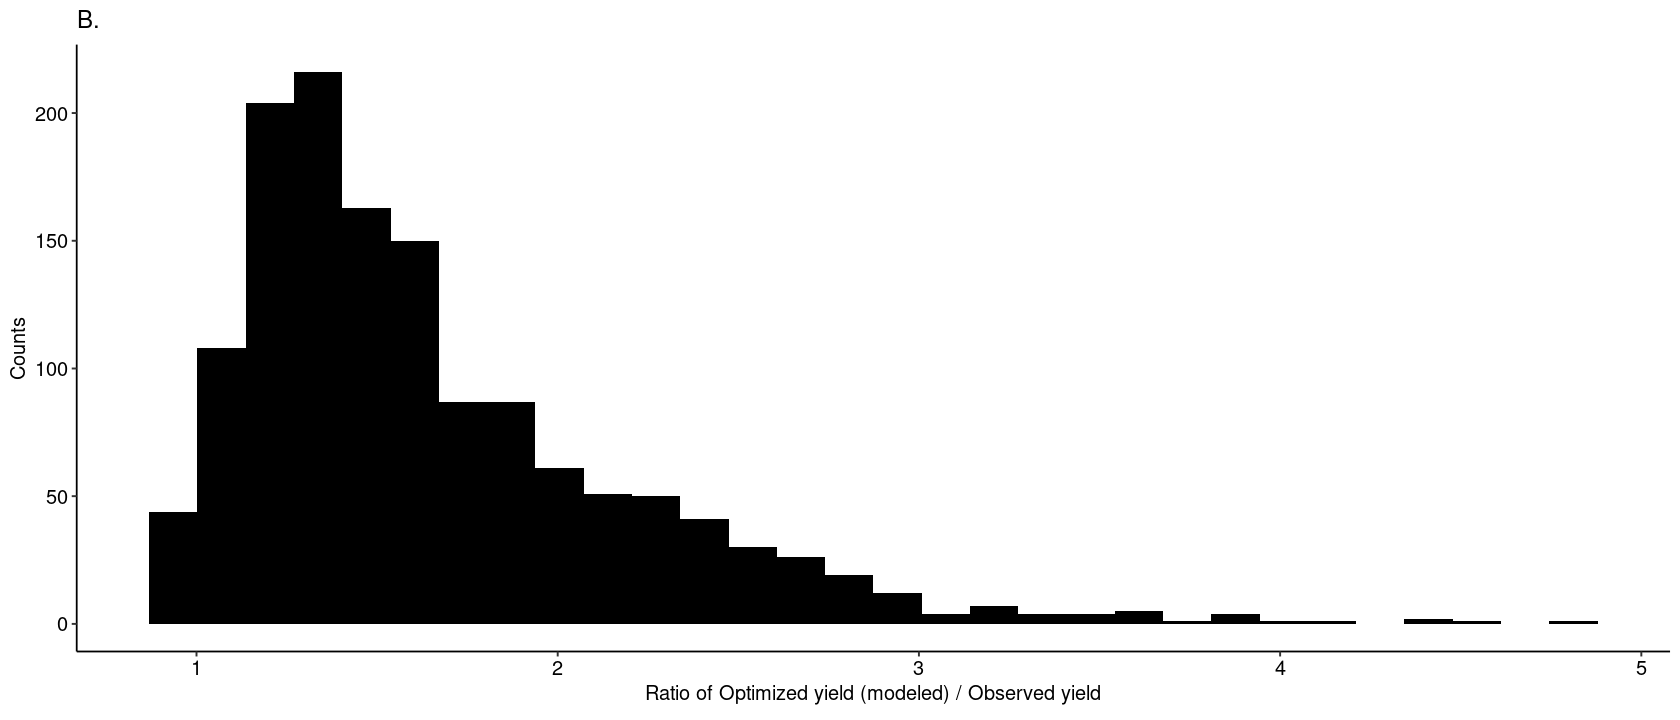

In [132]:
opt_output %>%
  filter(variable == "Yield improvement ratio") %>%
  ggplot(aes(x = value)) +
  geom_histogram(fill = "black", bins = 30) +
  labs(title = "B.", x = expression("Ratio of Optimized yield (modeled) / Observed yield"), y = "Counts") +
  theme_pubr() +
  ggsave("images/distr_yield_ratio.png", height = 5, width = 8, dpi = 300)

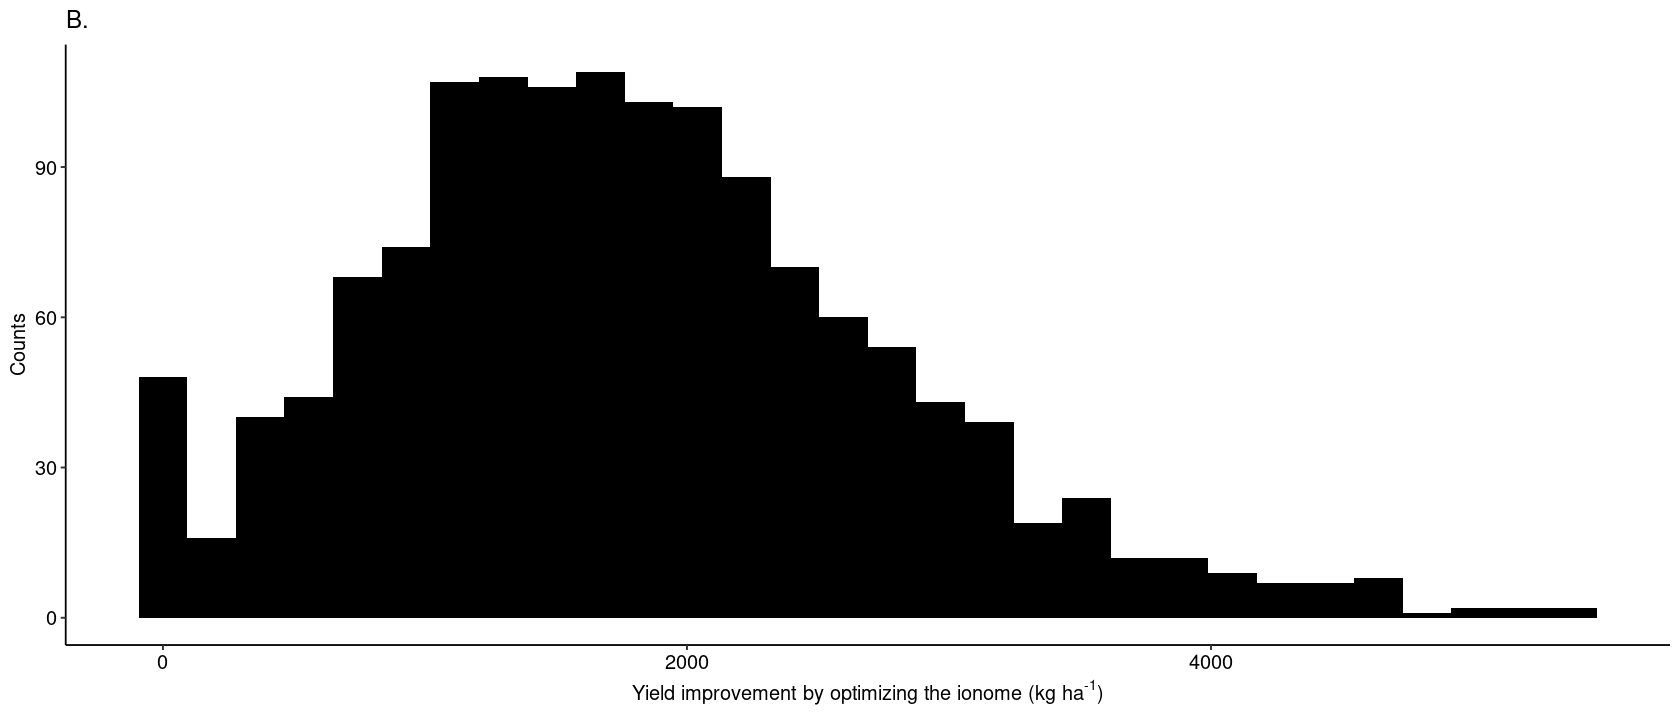

In [133]:
opt_output %>%
  #filter(variable == "Yield improvement ratio") %>%
  filter(variable == "Yield improvement absolute") %>%
  ggplot(aes(x = value)) +
  geom_histogram(fill = "black", bins = 30) +
  labs(title = "B.", x = expression("Yield improvement by optimizing the ionome (kg ha"^"-1"*")"), y = "Counts") +
  theme_pubr() +
  ggsave("images/distr_yield.png", height = 5, width = 8, dpi = 300)

In [134]:
opt_output %>%
  filter(variable %in% c("Aitchison distance", "Yield improvement ratio", "Yield improvement absolute")) %>%
  group_by(variable) %>%
  summarise(median = median(value))

`summarise()` ungrouping output (override with `.groups` argument)



variable,median
<chr>,<dbl>
Aitchison distance,0.47242
Yield improvement absolute,1701.58926
Yield improvement ratio,1.50337


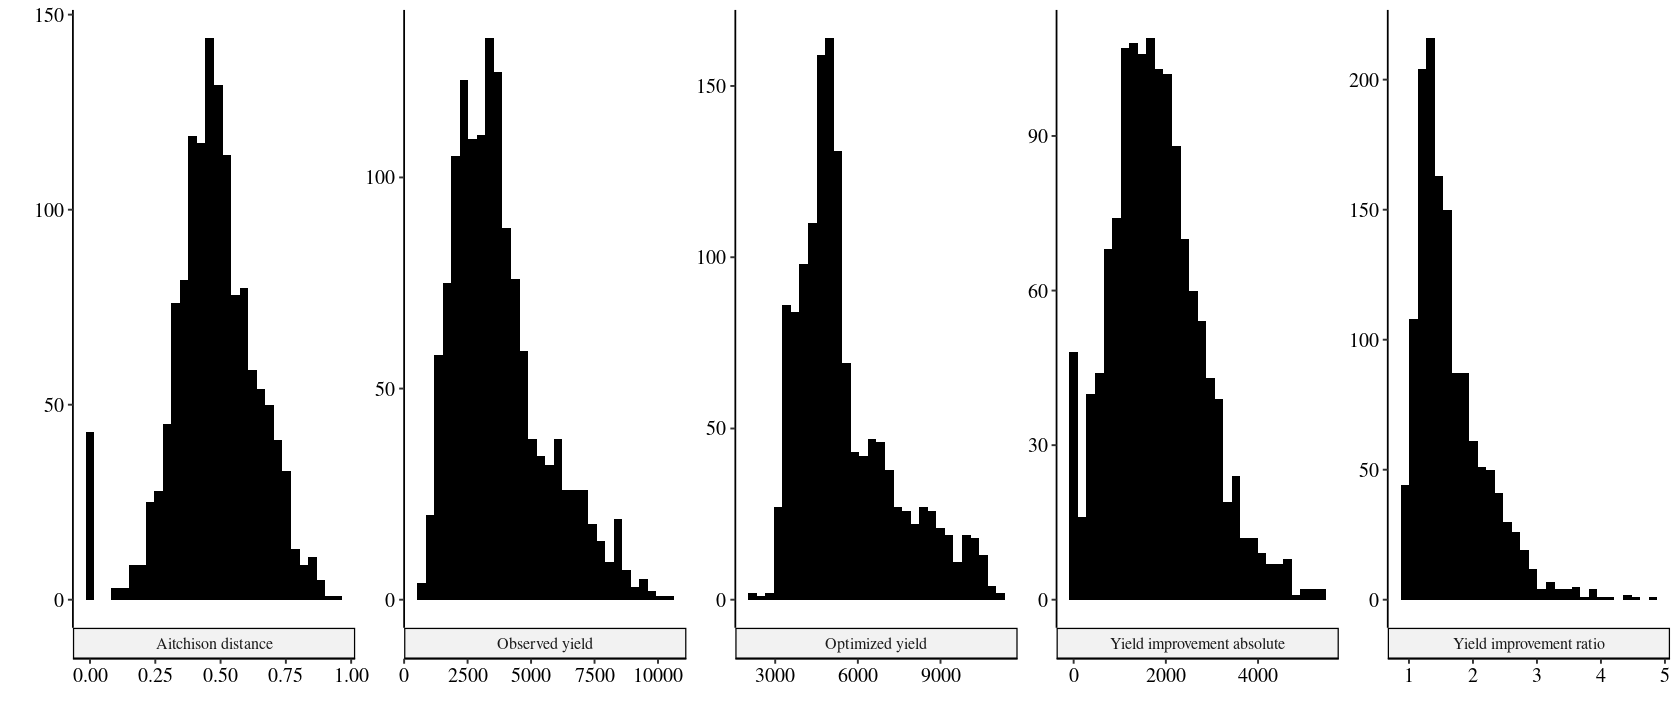

In [135]:
opt_output %>% 
  ggplot(aes(x = value)) +
  facet_wrap(~variable, nrow = 1, scales = "free", strip.position="bottom") +
  geom_histogram(bins = 30, fill = "black") +
  labs(x = "", y = "") +
  theme_pubr() +
  theme(text = element_text(family = "serif"))